### Overview
This is the specification for the main assignment of the Deep Learning class.
The goal of the project is to perform a systematic investigation of a number of Deep Learning
methods in the context of text and image processing tasks, and to benchmark these methods
against classical methods where appropriate.
This assignment has been designed to give you a range of task elements that you can use to build
up your skills in Deep Learning. As such this project specification is detailed and descriptive.
The outputs for this project will be a report, source code, and trained models. Details on what is
to be included in each of these pieces are detailed below. The report along with a code archive
(.zip), is to be submitted via Brightspace. The code archive should not include your trained models
- instead demo code should be able to retrieve your models from a public URL as needed.
Your implementation should be made in Keras / TensorFlow with Notebook files such that your
code can be opened and run within Google Colab -- though it is noted that training may in practice
need to be run on a local machine for full training to take place.
Note that you cannot use any alternative data set or coding framework.

### Part 1: Lyric Genre Prediction Task - 50% (of project total)
The core of this project is based around a simple task -- performing genre analysis on the “MultiLingual Lyrics for Genre Classification” dataset on kaggle.
https://www.kaggle.com/datasets/mateibejan/multilingual-lyrics-for-genre-classification
This is an extensive dataset that is split into training and testing subsets. The testing dataset
should be used for final testing only. The training dataset should be all training and validation
tasks as appropriate.

This first part of the task is to perform a number of analyses based on training from scratch to
predict genre based on initially on song lyrics and then on song lyrics and artist.

Below I’ve set out several different comparisons that you are to perform. You can think of these
as being individual chunks of analysis. These do not necessarily build on each other. It is up to
you to decide whether these are done in isolation or not. The key point is that you understand
yourself what you are doing, and that this understanding is reflected both in well documented
code, and in your report.

Your models should be designed to minimize overfitting as appropriate.
You should consider the investigation of hyperparamters, though full grid search may not be
feasible.

This initial set of models should be based on models predicting based on lyrics only.
In all cases you should record your results as graphs for Training and Validation data and report
the test result after training has been completed. Please select whatever loss functions or metrics
you think are appropriate based on notes provided in class, or more widely based on what is
appropriate in a text classification task.

### Data Preprocessing

In [2]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout, Embedding, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Flatten, Input, Embedding, SimpleRNN, Dropout, Dense, Concatenate, Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model, load_model
from gensim.models import Word2Vec
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

# read the train and test csv files from the data/lyrics folder and create a dataframe
def read_lyrics():
    train = pd.read_csv(os.path.join('data', 'lyrics', 'train.csv')) # read the train csv file 
    test = pd.read_csv(os.path.join('data', 'lyrics', 'test.csv')) # read the test csv file
    return train, test

train, test = read_lyrics()

train.head()

Artist                     Song Genre Language  \
0  12 stones            world so cold  Rock       en   
1  12 stones                   broken  Rock       en   
2  12 stones             3 leaf loser  Rock       en   
3  12 stones  anthem for the underdog  Rock       en   
4  12 stones               adrenaline  Rock       en   

                                              Lyrics  
0  It starts with pain, followed by hate\nFueled ...  
1  Freedom!\nAlone again again alone\nPatiently w...  
2  Biting the hand that feeds you, lying to the v...  
3  You say you know just who I am\nBut you can't ...  
4  My heart is beating faster can't control these...

In [3]:
# data exploration
print(train.shape)
print(train.columns)

(290183, 5)
Index(['Artist', 'Song', 'Genre', 'Language', 'Lyrics'], dtype='object')


In [4]:
# check for missing values
print(train.isnull().sum())

Artist       0
Song         1
Genre        0
Language     4
Lyrics      35
dtype: int64


In [5]:
# check for duplicates
print(train.duplicated().sum())

28477


In [6]:
# check for unique values
print(train.nunique())

Artist       11152
Song        164357
Genre           10
Language        33
Lyrics      249297
dtype: int64


In [7]:
print(train['Genre'].nunique())

10


In [8]:
# clean the data
train = train.dropna()

In [9]:
train.shape

(290143, 5)

### Exploratory Data Analysis

In [10]:
# print and example of the lyrics
print(train['Lyrics'][1000])

So I got my boots on,
Got the right amount of leather
And I'm doing me up with a black colored liner
And I'm working my strut but I know it don't matter
All we need in this world is some love
There's a thin line 'tween the dark side,
And the light side, baby tonight
It's a struggle, gotta rumble, tryin'a find it
[Chorus:]
But if I had you,
That would be the only thing I'd ever need
Yeah if I had you,
The money, fame and fortune never could compete
If I had you,
Life would be a party, it'd be ecstasy
Yeah, if I had you
Y-y-y-y-you y-y-y-y-y-you y-y-y-y-y-you
If I had you
From New York to La getting high, rock and rolling
Get a room trash it up 'til it's ten in the morning
Girls in stripper heels, boys rolling in Maserati's
What they need in this world is some love
There's a thin line 'tween the wild time,
And a flat-line, baby tonight
It's a struggle gotta rumble, tryin'a find it
[Chorus:]
But if I had you,
That would be the only thing I'd ever need
Yeah if I had you,
The money, fame an

In [11]:
def clean_text(text):
    """
    Cleans the input text by performing the following operations:
    - Removes special characters.
    - Removes single characters.
    - Removes multiple spaces.
    - Converts text to lowercase.
    Args:
    text (str): The input text to be cleaned.
    Returns:
    str: The cleaned text.
    """
    # remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # convert to lowercase
    text = text.lower()
    return text
    

def prepare_lyrics(lyrics):
    lyrics = lyrics.apply(clean_text)
    return lyrics

train['Lyrics'] = prepare_lyrics(train['Lyrics'])
test['Lyrics'] = prepare_lyrics(test['Lyrics'])

In [12]:
# print and example of the lyrics
print(train['Lyrics'][1000])

so got my boots on got the right amount of leather and im doing me up with black colored liner and im working my strut but know it dont matter all we need in this world is some love theres thin line tween the dark side and the light side baby tonight its struggle gotta rumble tryina find it chorus but if had you that would be the only thing id ever need yeah if had you the money fame and fortune never could compete if had you life would be party itd be ecstasy yeah if had you yyyyyou yyyyyyou yyyyyyou if had you from new york to la getting high rock and rolling get room trash it up til its ten in the morning girls in stripper heels boys rolling in maseratis what they need in this world is some love theres thin line tween the wild time and flatline baby tonight its struggle gotta rumble tryina find it chorus but if had you that would be the only thing id ever need yeah if had you the money fame and fortune never could compete if had you life would be party itd be ecstasy yeah if had you

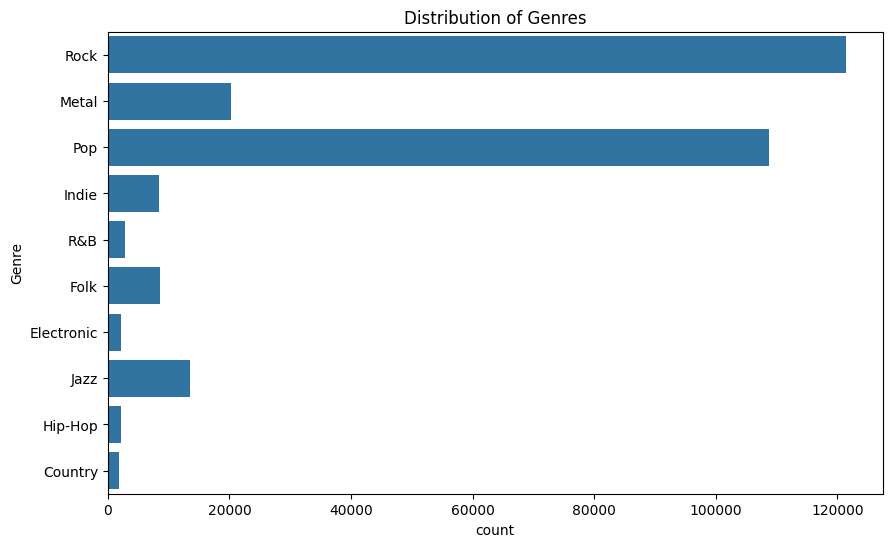

In [13]:
# visualise the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(train['Genre'])
plt.title('Distribution of Genres')
plt.show()

In [14]:
# balance the data
train['Genre'].value_counts()

Genre
Rock          121390
Pop           108693
Metal          20286
Jazz           13545
Folk            8644
Indie           8449
R&B             2793
Hip-Hop         2240
Electronic      2213
Country         1890
Name: count, dtype: int64

In [15]:
"""
This script performs downsampling on a dataset to balance the classes based on the 'Genre' column.

Steps:
1. Extract the minority class (Country genre) from the training dataset.
2. Extract the majority classes (Rock, Pop, Metal, Jazz, Hip-Hop, Folk, Indie, R&B, Electronic genres) from the training dataset.
3. Downsample each majority class to match the number of samples in the minority class using sklearn's resample function.
4. Combine the downsampled majority classes with the minority class to create a balanced dataset.
5. Display the value counts of each genre in the downsampled training dataset.

Dependencies:
- pandas as pd
- sklearn.utils.resample

Variables:
- train: The original training dataset.
- train_country: Subset of the training dataset containing only the Country genre.
- train_rock, train_pop, train_metal, train_jazz, train_hiphop, train_folk, train_indie, train_rnb, train_electronic: Subsets of the training dataset containing each respective genre.
- train_rock_downsampled, train_pop_downsampled, train_metal_downsampled, train_jazz_downsampled, train_hiphop_downsampled, train_folk_downsampled, train_indie_downsampled, train_rnb_downsampled, train_electronic_downsampled: Downsampled subsets of each respective genre.
- train_downsampled: The final balanced training dataset containing the downsampled majority classes and the minority class.
"""
# minority class
train_country = train[train['Genre'] == 'Country']

# majority classes
train_rock = train[train['Genre'] == 'Rock']
train_pop = train[train['Genre'] == 'Pop']
train_metal = train[train['Genre'] == 'Metal']
train_jazz = train[train['Genre'] == 'Jazz']
train_hiphop = train[train['Genre'] == 'Hip-Hop']
train_folk = train[train['Genre'] == 'Folk']
train_indie = train[train['Genre'] == 'Indie']
train_rnb = train[train['Genre'] == 'R&B']
train_electronic = train[train['Genre'] == 'Electronic']

train_rock_downsampled = resample(train_rock, replace=False, n_samples=len(train_country), random_state=42)
train_pop_downsampled = resample(train_pop, replace=False, n_samples=len(train_country), random_state=42)
train_metal_downsampled = resample(train_metal, replace=False, n_samples=len(train_country), random_state=42)
train_jazz_downsampled = resample(train_jazz, replace=False, n_samples=len(train_country), random_state=42)
train_jazz_downsampled = resample(train_jazz, replace=False, n_samples=len(train_country), random_state=42)
train_hiphop_downsampled = resample(train_hiphop, replace=False, n_samples=len(train_country), random_state=42)
train_folk_downsampled = resample(train_folk, replace=False, n_samples=len(train_country), random_state=42)
train_indie_downsampled = resample(train_indie, replace=False, n_samples=len(train_country), random_state=42)
train_rnb_downsampled = resample(train_rnb, replace=False, n_samples=len(train_country), random_state=42)
train_electronic_downsampled = resample(train_electronic, replace=False, n_samples=len(train_country), random_state=42)

# combine the downsampled majority classes with the minority class
train_downsampled = pd.concat([train_country, train_rock_downsampled, train_pop_downsampled, train_metal_downsampled, train_jazz_downsampled, train_hiphop_downsampled, train_folk_downsampled, train_indie_downsampled, train_rnb_downsampled, train_electronic_downsampled])

train_downsampled['Genre'].value_counts()



Genre
Country       1890
Rock          1890
Pop           1890
Metal         1890
Jazz          1890
Hip-Hop       1890
Folk          1890
Indie         1890
R&B           1890
Electronic    1890
Name: count, dtype: int64

In [16]:
"""
Constants used to maintain consistency across initial training.

Attributes:
    UNITS (int): Number of units in the neural network layers.
    EMBEDDING_DIM (int): Dimension of the embedding layer.
    OUTPUT_DIM (int): Dimension of the output layer.
    BATCH_SIZE (int): Number of samples per gradient update.
    EPOCHS (int): Number of epochs to train the model.
    DROPOUT_RATE (float): Fraction of the input units to drop.
    DENSE_ACTIVATION (str): Activation function to use in dense layers.
    OPTIMIZER (str): Optimizer to use for training the model.
    VALIDATION_SPLIT (float): Fraction of the training data to be used as validation data.
"""
UNITS=64
EMBEDDING_DIM=100
OUTPUT_DIM=10
BATCH_SIZE=32
EPOCHS=5
DROPOUT_RATE=0.5
DENSE_ACTIVATION='relu'
OPTIMIZER='adam'
VALIDATION_SPLIT=0.2

In [17]:
"""
This script sets up two Keras callbacks for training a deep learning model: EarlyStopping and ReduceLROnPlateau.

Callbacks:
    - EarlyStopping: Monitors the training process and stops training when a monitored metric has stopped improving.
        Parameters:
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            patience (int): Number of epochs with no improvement after which training will be stopped.
            restore_best_weights (bool): Whether to restore model weights from the epoch with the best value of the monitored quantity.

    - ReduceLROnPlateau: Reduces the learning rate when a monitored metric has stopped improving.
        Parameters:
            monitor (str): Quantity to be monitored.
            factor (float): Factor by which the learning rate will be reduced. new_lr = lr * factor.
            patience (int): Number of epochs with no improvement after which learning rate will be reduced.
            min_lr (float): Lower bound on the learning rate.

The callbacks are stored in a list named `callbacks` and can be passed to the `fit` method of a Keras model.
"""

early_stopping = EarlyStopping(
    min_delta=0.001, # minimum amount of change to count as an improvement
    patience=3, # how many epochs to wait before stopping
    restore_best_weights=True,
)

reduceOnPlateau = ReduceLROnPlateau(
    monitor='val_loss', # value being monitored for improvement
    factor=0.1, # factor by which the learning rate will be reduced
    patience=2, # number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6, # lower bound on the learning rate
)

callbacks = [early_stopping, reduceOnPlateau]

In [18]:
# Plotting helper functions
def plot_training_results(history, metric='accuracy'):
    plt.figure(figsize=(10, 6))
    plt.plot(history[metric], label='Training ' + metric)
    plt.plot(history['val_'+metric], label='Validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title('Training and Validation ' + metric)
    plt.legend()
    plt.show()

In [19]:
def prepare_data(train, test):
    """
    Prepares the data for training and testing by encoding the target variable, 
    tokenizing and padding the lyrics, and optionally including artist information.
    Parameters:
    train (pd.DataFrame): Training data containing 'Genre', 'Lyrics', and optionally 'Artist' columns.
    test (pd.DataFrame): Testing data containing 'Genre', 'Lyrics', and optionally 'Artist' columns.
    include_artist (bool): Whether to include artist information in the features. Default is False.
    Returns:
    tuple: 
        If include_artist is False:
            - x_train_lyrics (np.ndarray): Padded sequences of training lyrics.
            - x_test_lyrics (np.ndarray): Padded sequences of testing lyrics.
            - y_train (np.ndarray): One-hot encoded training target variable.
            - y_test (np.ndarray): One-hot encoded testing target variable.
            - vocab_size_lyrics (int): Vocabulary size of the lyrics.
            - max_length_lyrics (int): Maximum length of the lyrics sequences.
            - le (LabelEncoder): Fitted label encoder.
        If include_artist is True:
            - x_train (np.ndarray): Combined padded sequences of training lyrics and artist.
            - x_test (np.ndarray): Combined padded sequences of testing lyrics and artist.
            - y_train (np.ndarray): One-hot encoded training target variable.
            - y_test (np.ndarray): One-hot encoded testing target variable.
            - vocab_size_lyrics (int): Vocabulary size of the lyrics.
            - vocab_size_artist (int): Vocabulary size of the artist names.
            - max_length_lyrics (int): Maximum length of the lyrics sequences.
            - max_length_artist (int): Maximum length of the artist sequences.
            - le (LabelEncoder): Fitted label encoder.
    """

    # Encode the target variable
    le = LabelEncoder()
    y_train = le.fit_transform(train['Genre'])  # Encode the target variable
    y_train = to_categorical(y_train)  # One-hot encode the target variable
    
    y_test = le.transform(test['Genre'])  # Encode the target variable
    y_test = to_categorical(y_test)  # One-hot encode the target variable
    
    # Tokenize and pad the lyrics
    lyrics_tokenizer = Tokenizer(oov_token="<UNK>")
    lyrics_tokenizer.fit_on_texts(train['Lyrics'])
    
    # Convert the lyrics to sequences
    x_train_lyrics = lyrics_tokenizer.texts_to_sequences(train['Lyrics'])
    x_test_lyrics = lyrics_tokenizer.texts_to_sequences(test['Lyrics'])
    
    # Get the vocabulary size and maximum length of the lyrics
    vocab_size_lyrics = len(lyrics_tokenizer.word_index) + 1
    max_length_lyrics = max([len(s.split()) for s in train['Lyrics']])
    
    # Pad the sequences
    x_train_lyrics = pad_sequences(x_train_lyrics, maxlen=max_length_lyrics, padding='post')
    x_test_lyrics = pad_sequences(x_test_lyrics, maxlen=max_length_lyrics, padding='post')
     
    # Tokenize and pad the artist names
    artist_tokenizer = Tokenizer(oov_token="<UNK>")
    artist_tokenizer.fit_on_texts(train['Artist'])
    
    x_train_artist = artist_tokenizer.texts_to_sequences(train['Artist'])
    x_test_artist = artist_tokenizer.texts_to_sequences(test['Artist'])
    
    vocab_size_artist = len(artist_tokenizer.word_index) + 1
    max_length_artist = max([len(s.split()) for s in train['Artist']])
    
    x_train_artist = pad_sequences(x_train_artist, maxlen=max_length_artist, padding='post')
    x_test_artist = pad_sequences(x_test_artist, maxlen=max_length_artist, padding='post')
    
    # Combine the lyrics and artist features
    x_train = np.concatenate([x_train_lyrics, x_train_artist], axis=1)
    x_test = np.concatenate([x_test_lyrics, x_test_artist], axis=1)
    
    return x_train, x_test, y_train, y_test, vocab_size_lyrics, vocab_size_artist, max_length_lyrics, max_length_artist, le, lyrics_tokenizer, artist_tokenizer

In [20]:
def evaluate_model(model, X_test, y_test, le):
    """
    Evaluate the given model on the test data and print various evaluation metrics.

    Parameters:
    model (keras.Model): The trained model to evaluate.
    X_test (numpy.ndarray): The test data features.
    y_test (numpy.ndarray): The test data labels.
    le (sklearn.preprocessing.LabelEncoder): The label encoder used to transform the target variable.

    Returns:
    None

    Prints:
    - Loss and accuracy of the model on the test data.
    - Classification report including precision, recall, f1-score, and support.
    - Confusion matrix.
    - Accuracy score.

    Additionally:
    - Creates a DataFrame to visualize the actual vs predicted results.
    - Plots a count plot comparing the actual and predicted values.
    """
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')
    # make predictions
    y_pred = model.predict(X_test)

    # convert the predictions to the target variable
    y_pred = le.inverse_transform(y_pred.argmax(axis=1))

    # convert the test target variable to the original values
    y_test = le.inverse_transform(y_test.argmax(axis=1))

    print(accuracy_score(y_test, y_pred))
        
    # Print classification report
    print(classification_report(y_test, y_pred))

    # create a results df
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })

    # plot the results
    plt.figure(figsize=(10, 6))
    sns.countplot(results_df['Actual'], color='blue', alpha=0.7, label='Actual')
    sns.countplot(results_df['Predicted'], color='red', alpha=0.7, label='Predicted')
    plt.legend()
    plt.title('Actual vs Predicted')
    plt.show()

    # visualize the results
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.crosstab(results_df['Actual'], results_df['Predicted'], normalize='index'), annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

In [21]:
"""
This script prepares and separates data for a deep learning project involving lyrics and artist information.

Functions:
    prepare_data(train_downsampled, test, include_artist=True): Prepares the training and testing data, including artist information if specified.

Variables:
    X_train (ndarray): Training data containing both lyrics and artist features.
    X_test (ndarray): Testing data containing both lyrics and artist features.
    y_train (ndarray): Training labels.
    y_test (ndarray): Testing labels.
    vocab_size_lyrics (int): Vocabulary size for lyrics.
    vocab_size_artist (int): Vocabulary size for artist information.
    max_length_lyrics (int): Maximum length of lyrics sequences.
    max_length_artist (int): Maximum length of artist sequences.
    le (LabelEncoder): Label encoder for artist information.
    lyrics_tokenizer (Tokenizer): Tokenizer for lyrics.
    artist_tokenizer (Tokenizer): Tokenizer for artist information.

Data Separation:
    X_train_lyrics (ndarray): Training data containing only lyrics features.
    X_train_artist (ndarray): Training data containing only artist features.
    X_test_lyrics (ndarray): Testing data containing only lyrics features.
    X_test_artist (ndarray): Testing data containing only artist features.

Prints:
    Shape of X_train_lyrics: Shape of the training data containing only lyrics features.
    Shape of X_train_artist: Shape of the training data containing only artist features.
"""
# Prepare data with artist information
X_train, X_test, y_train, y_test, vocab_size_lyrics, vocab_size_artist, max_length_lyrics, max_length_artist, le, lyrics_tokenizer, artist_tokenizer = prepare_data(
    train_downsampled, test
)

# Separate lyrics and artist features
X_train_lyrics = X_train[:, :max_length_lyrics]
X_train_artist = X_train[:, max_length_lyrics:]
X_test_lyrics = X_test[:, :max_length_lyrics]
X_test_artist = X_test[:, max_length_lyrics:]

print("Shape of X_train_lyrics:", X_train_lyrics.shape)
print("Shape of X_train_artist:", X_train_artist.shape)

Shape of X_train_lyrics: (18900, 2009)
Shape of X_train_artist: (18900, 7)


### Base Models Lyrics Only

#### RNN Variants
The first sub-assignment is to compare performance on the classification task across Recurrent
Network Variants. Specifically compare LSTM and Basic RNN models. You are free to choose
your own state size for the recurrent network, however please use the same state size for both
RNN variants.
Also compare a single layer LSTM implementation to a multi-layer LSTM implementation.

In [ ]:
def create_rnn_model(
    input_dim, 
    embedding_dim, 
    dense_units, 
    dropout_rate, 
    max_length, 
    dense_activation='relu', 
    optimizer='adam', 
    max_length_artist=None,
    artist_vocab_size=None
):
    """
    Creates an RNN model for text classification with optional artist information.
    Args:
        input_dim (int): Size of the vocabulary for the lyrics input.
        embedding_dim (int): Dimension of the embedding space.
        dense_units (int): Number of units in the dense layer.
        dropout_rate (float): Dropout rate for regularization.
        max_length (int): Maximum length of the lyrics input sequences.
        dense_activation (str, optional): Activation function for the dense layer. Defaults to 'relu'.
        optimizer (str, optional): Optimizer to use for compiling the model. Defaults to 'adam'.
        max_length_artist (int, optional): Maximum length of the artist input sequences. Defaults to None.
        artist_vocab_size (int, optional): Size of the vocabulary for the artist input. Defaults to None.
    Returns:
        keras.Model: Compiled RNN model.
    """
    inputs_combined = []
    features = []
    
    # Lyrics input
    lyrics_input = Input(shape=(max_length,), name="Lyrics_Input")
    lyrics_embedding = Embedding(input_dim, embedding_dim, input_length=max_length)(lyrics_input)
    lyrics_rnn = SimpleRNN(units=dense_units, return_sequences=False)(lyrics_embedding)
    lyrics_dropout = Dropout(dropout_rate)(lyrics_rnn)

    # Append inputs and features
    inputs_combined.append(lyrics_input)
    features.append(lyrics_dropout)

    # Artist input (optional)
    if artist_vocab_size is not None:
        print("Artist information included")
        artist_input = Input(shape=(max_length_artist,), name="Artist_Input")
        artist_embedding = Embedding(artist_vocab_size, embedding_dim, input_length=1)(artist_input)
        artist_rnn = SimpleRNN(units=dense_units, return_sequences=False)(artist_embedding)
        artist_dropout = Dropout(dropout_rate)(artist_rnn)
        inputs_combined.append(artist_input)
        features.append(artist_dropout)
    
    # Combine features
    if len(features) > 1:
        combined_features = Concatenate()(features)
    else:
        combined_features = features[0]
    
    # Dense layers
    dense = Dense(dense_units, activation=dense_activation)(combined_features)
    dropout = Dropout(dropout_rate)(dense)
    
    # Output layer
    output = Dense(OUTPUT_DIM, activation='softmax', name="Output")(dropout)
    
    # Build and compile model
    model = Model(inputs=inputs_combined, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

##### RNN Training and Evaluation, Lyrics Only

In [ ]:
# create the model
basic_rnn_model = create_rnn_model(
    input_dim=vocab_size_lyrics, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=max_length_lyrics, 
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER
)
basic_rnn_model.summary()

# train the model, save the history
basic_rnn_history = basic_rnn_model.fit(
    X_train_lyrics, y_train, 
    validation_split=VALIDATION_SPLIT, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=callbacks
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Lyrics_Input (InputLayer)       │ (None, 2009)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 2009, 100)      │     8,113,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,128,970 (31.01 MB)

 Trainable params: 8,128,970 (31.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 128s 269ms/step - accuracy: 0.1250 - loss: 2.2152 - val_accuracy: 0.0000e+00 - val_loss: 4.1478 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 126s 267ms/step - accuracy: 0.1227 - loss: 2.1642 - val_accuracy: 0.0000e+00 - val_loss: 4.2043 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 126s 267ms/step - accuracy: 0.1216 - loss: 2.1141 - val_accuracy: 0.0000e+00 - val_loss: 4.6185 - learning_rate: 0.0010
Epoch 4/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 126s 267ms/step - accuracy: 0.1312 - loss: 2.0947 - val_accuracy: 0.0000e+00 - val_loss: 4.4233 - learning_rate: 1.0000e-04


##### Results

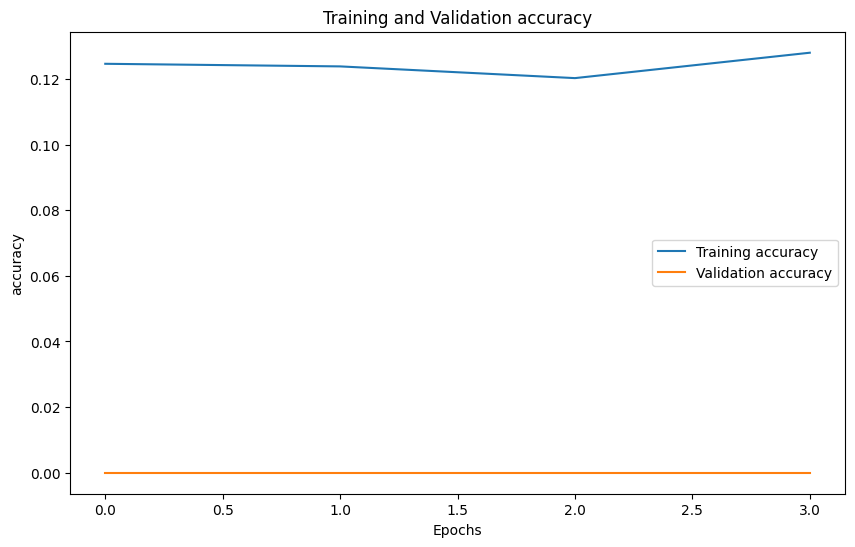

248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.1062 - loss: 2.4079
Loss: 2.4130847454071045
Accuracy: 0.10560806840658188
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step
0.10560806553245117
              precision    recall  f1-score   support

     Country       0.10      0.78      0.18       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.05      0.02      0.03       495
     Hip-Hop       0.17      0.03      0.06       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.00      0.00      0.00       660
       Metal       0.10      0.10      0.10       810
         Pop       0.14      0.06      0.09      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.12      0.01      0.02      1410

    accuracy                           0.11      7935
   macro avg       0.07      0.10      0.05      7935
weighted avg       0.09      0.11      0.05      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

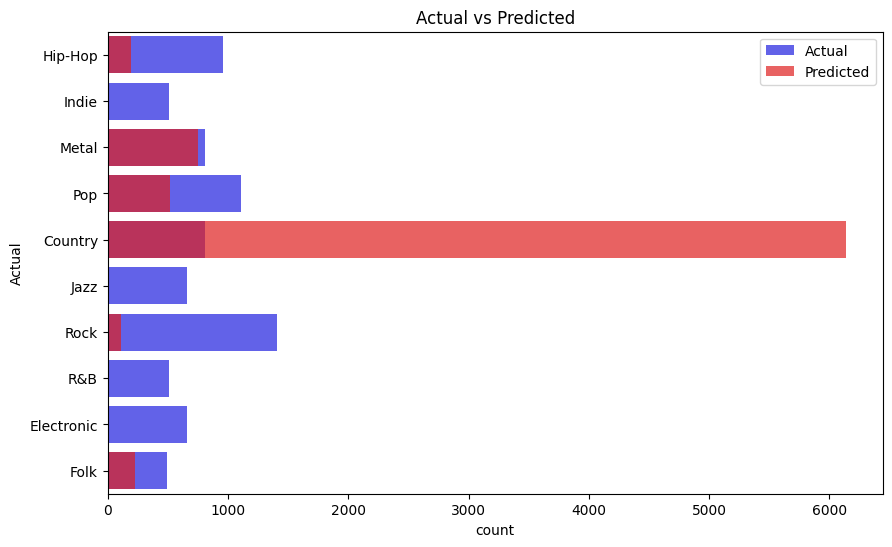

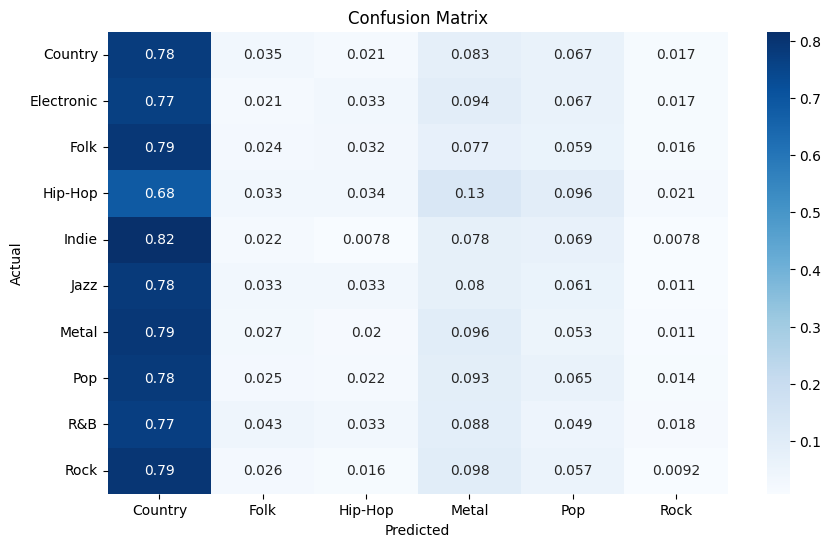

In [95]:
# plot the training results
plot_training_results(basic_rnn_history.history)
plot_training_results(basic_rnn_history.history, metric='loss')

# evaluate the model
evaluate_model(basic_rnn_model, X_test_lyrics, y_test, le)

# save the model
basic_rnn_model.save('models/basic_rnn_model.keras')

# save the history
basic_rnn_history_df = pd.DataFrame(basic_rnn_history.history)

# save the history to a csv file
basic_rnn_history_df.to_csv('results/basic_rnn_history.csv', index=False)

#### LSTM Variants

In [ ]:
def create_single_lstm_model(
    input_dim, 
    embedding_dim, 
    dense_units, 
    dropout_rate, 
    max_length, 
    dense_activation='relu', 
    optimizer='adam', 
    max_length_artist=None,
    artist_vocab_size=None
):
    """
    Create a single LSTM model with optional artist input.
    
    Parameters:
        input_dim (int): Vocabulary size for lyrics.
        embedding_dim (int): Embedding dimension for lyrics.
        dense_units (int): Number of units in LSTM and dense layers.
        dropout_rate (float): Dropout rate for regularization.
        max_length (int): Maximum sequence length for lyrics.
        dense_activation (str): Activation function for dense layers.
        optimizer (str): Optimizer for model training.
        artist_vocab_size (int): Vocabulary size for artist data (optional).
        output_dim (int): Number of output classes.
    
    Returns:
        model (keras.Model): Compiled Keras model.
    """
    inputs_combined = []
    features = []
    
    # Lyrics input and LSTM processing
    lyrics_input = Input(shape=(max_length,), name="Lyrics_Input")
    lyrics_embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)(lyrics_input)
    lyrics_lstm = LSTM(dense_units)(lyrics_embedding)
    lyrics_dropout = Dropout(dropout_rate)(lyrics_lstm)
    inputs_combined.append(lyrics_input)
    features.append(lyrics_dropout)

    # Optional artist input
    if artist_vocab_size is not None:
        artist_input = Input(shape=(max_length_artist,), name="Artist_Input")
        artist_embedding_layer = Embedding(artist_vocab_size, embedding_dim, input_length=max_length_artist)(artist_input)
        artist_lstm = LSTM(dense_units)(artist_embedding_layer)
        artist_dense = Dense(embedding_dim, activation=dense_activation)(artist_lstm)
        inputs_combined.append(artist_input)
        features.append(artist_dense)

    # Combine features if both are present
    if len(features) > 1:
        combined_features = Concatenate()(features)
    else:
        combined_features = features[0]
    
    # Fully connected layers
    dense_layer = Dense(dense_units, activation=dense_activation)(combined_features)
    dropout_layer = Dropout(dropout_rate)(dense_layer)
    
    # Output layer
    output = Dense(OUTPUT_DIM, activation='softmax', name="Output")(dropout_layer)
    
    # Build and compile the model
    model = Model(inputs=inputs_combined, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

##### Single Layer LSTM Training and Evaluation, Lyrics Only

In [44]:
# Create the model
basic_lstm_single_layer_model = create_single_lstm_model(
    input_dim=vocab_size_lyrics, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=max_length_lyrics, 
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER
)

# Print the model summary
basic_lstm_single_layer_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Lyrics_Input (InputLayer)       │ (None, 2009)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 2009, 100)      │     8,113,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,160,650 (31.13 MB)

 Trainable params: 8,160,650 (31.13 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Train lyrics-only model
basic_lstm_single_layer_model_history = basic_lstm_single_layer_model.fit(
    X_train_lyrics, y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    callbacks=callbacks
)

Epoch 1/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 286s 602ms/step - accuracy: 0.1271 - loss: 2.1685 - val_accuracy: 0.0000e+00 - val_loss: 5.6628 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 3237s 7s/step - accuracy: 0.1242 - loss: 2.1031 - val_accuracy: 0.0000e+00 - val_loss: 6.4223 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 287s 607ms/step - accuracy: 0.1233 - loss: 2.0899 - val_accuracy: 0.0000e+00 - val_loss: 7.1079 - learning_rate: 0.0010


##### Results

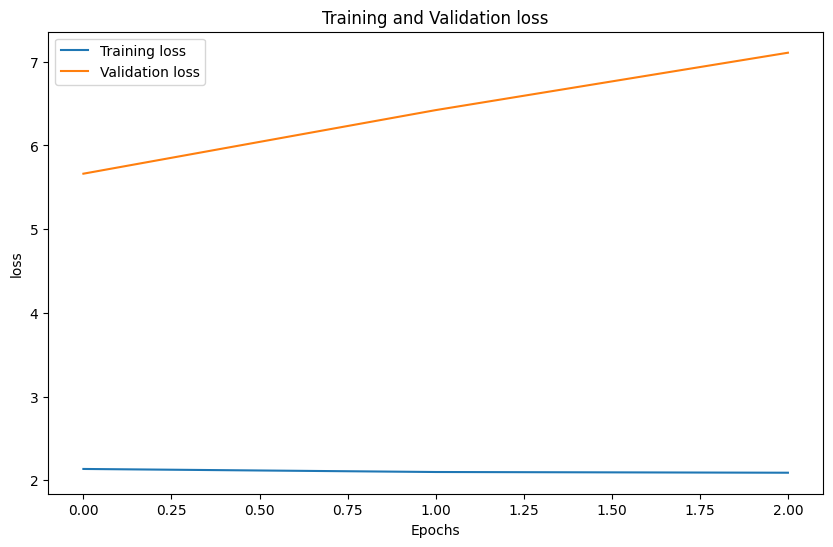

248/248 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.1076 - loss: 2.6019
Loss: 2.6109237670898438
Accuracy: 0.10207939147949219
248/248 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step
0.10207939508506617
              precision    recall  f1-score   support

     Country       0.10      1.00      0.19       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.00      0.00      0.00       495
     Hip-Hop       0.00      0.00      0.00       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.00      0.00      0.00       660
       Metal       0.00      0.00      0.00       810
         Pop       0.00      0.00      0.00      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.00      0.00      0.00      1410

    accuracy                           0.10      7935
   macro avg       0.01      0.10      0.02      7935
weighted avg       0.01      0.10      0.02      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

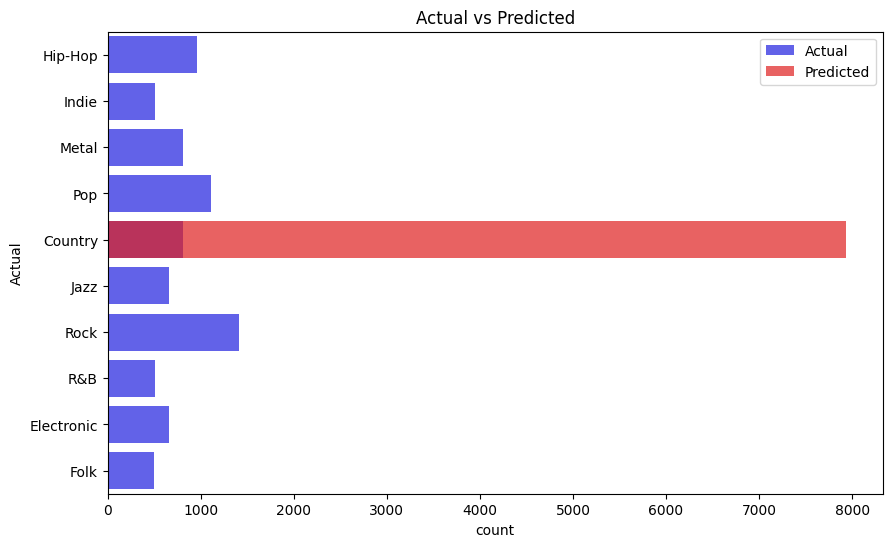

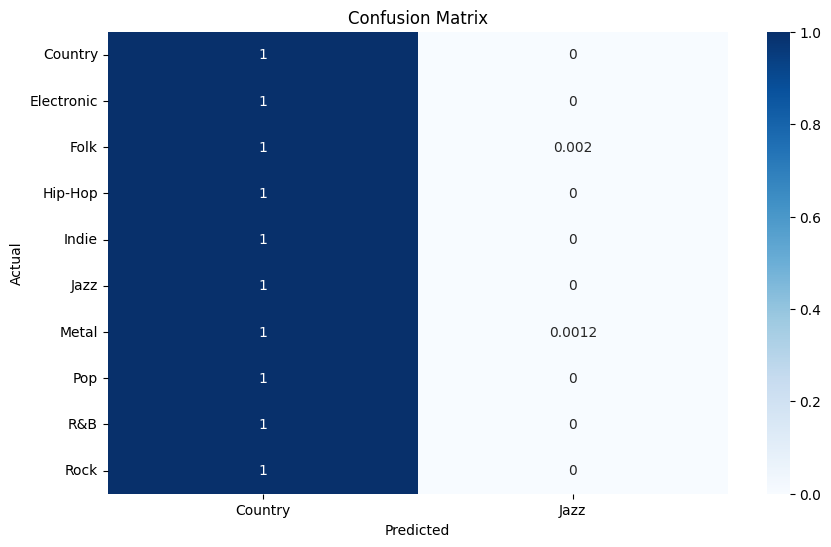

In [98]:
# plot the training results
plot_training_results(basic_lstm_single_layer_model_history.history)
plot_training_results(basic_lstm_single_layer_model_history.history, metric='loss')

# Evaluate lyrics-only model
evaluate_model(basic_lstm_single_layer_model, X_test_lyrics, y_test, le)

# save the model
basic_lstm_single_layer_model.save('models/basic_lstm_single_layer_model.keras')

# save the history
basic_lstm_single_layer_model_history_df = pd.DataFrame(basic_lstm_single_layer_model_history.history)

# save the history to a csv file
basic_lstm_single_layer_model_history_df.to_csv('results/basic_lstm_single_layer_model_history.csv', index=False)

##### Multi-Layer LSTM Training and Evaluation, Lyrics Only

In [ ]:
def create_multi_lstm_model(
    input_dim, 
    embedding_dim,
    dense_units,
    dropout_rate,
    max_length,
    dense_activation='relu',
    optimizer='adam',
    max_length_artist=None,
    artist_vocab_size=None
):
    """
    Create a multi-layer LSTM model with optional artist input.
    
    Parameters:
        input_dim (int): Vocabulary size for lyrics.
        embedding_dim (int): Embedding dimension for lyrics.
        dense_units (int): Number of units in LSTM and dense layers.
        dropout_rate (float): Dropout rate for regularization (default: 0.5).
        max_length (int): Maximum sequence length for lyrics.
        dense_activation (str): Activation function for dense layers.
        optimizer (str): Optimizer for model training.
        artist_vocab_size (int): Vocabulary size for artist data (optional).
        output_dim (int): Number of output classes.
    
    Returns:
        model (keras.Model): Compiled Keras model.
    """
    inputs_combined = []
    features = []
    
    # Lyrics input and embedding
    lyrics_input = Input(shape=(max_length,), name="Lyrics_Input")
    lyrics_embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)(lyrics_input)
    
    # Multi-layer LSTM for lyrics
    lstm_layer_1 = LSTM(dense_units, return_sequences=True)(lyrics_embedding)
    lstm_layer_2 = LSTM(dense_units)(lstm_layer_1)

    # Dropout layer
    lyrics_dropout = Dropout(dropout_rate)(lstm_layer_2)
    features.append(lyrics_dropout)
    inputs_combined.append(lyrics_input)

    # Optional artist input
    if artist_vocab_size is not None:
        artist_input = Input(shape=(max_length_artist,), name="Artist_Input")
        artist_embedding_layer = Embedding(artist_vocab_size, embedding_dim, input_length=max_length_artist)(artist_input)
        artist_lstm = LSTM(dense_units)(artist_embedding_layer)
        artist_dense = Dense(embedding_dim, activation=dense_activation)(artist_lstm)
        inputs_combined.append(artist_input)
        features.append(artist_dense)
    
    # Combine features if both are present
    if len(features) > 1:
        combined_features = Concatenate()(features)
    else:
        combined_features = features[0]
    
    # Fully connected layers
    dense_layer = Dense(dense_units, activation=dense_activation)(combined_features)
    dropout_layer = Dropout(dropout_rate)(dense_layer)
    
    # Output layer
    output = Dense(OUTPUT_DIM, activation='softmax', name="Output")(dropout_layer)
    
    # Build and compile the model
    model = Model(inputs=inputs_combined, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [48]:
# create the model
basic_multi_layer_lstm_model = create_multi_lstm_model(
    input_dim=vocab_size_lyrics, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=max_length_lyrics, 
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER
)

# train the model
basic_multi_layer_lstm_model_history = basic_multi_layer_lstm_model.fit(X_train_lyrics, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=callbacks)

Epoch 1/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 604s 1s/step - accuracy: 0.1244 - loss: 2.1869 - val_accuracy: 0.0000e+00 - val_loss: 5.1051 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 586s 1s/step - accuracy: 0.1271 - loss: 2.1032 - val_accuracy: 0.0000e+00 - val_loss: 6.2668 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 601s 1s/step - accuracy: 0.1297 - loss: 2.0912 - val_accuracy: 0.0000e+00 - val_loss: 6.7271 - learning_rate: 0.0010


In [49]:
basic_lstm_single_layer_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Lyrics_Input (InputLayer)       │ (None, 2009)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 2009, 100)      │     8,113,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,481,952 (93.39 MB)

 Trainable params: 8,160,650 (31.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,321,302 (62.26 MB)

##### Results

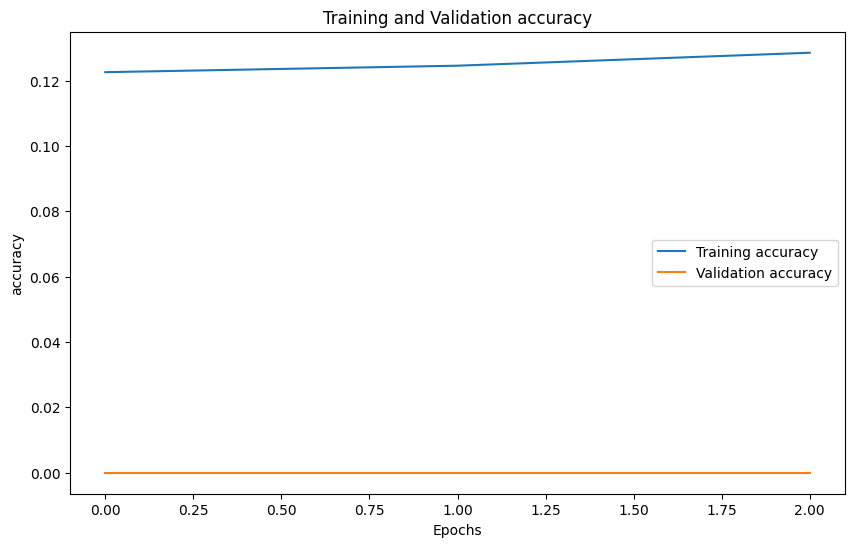

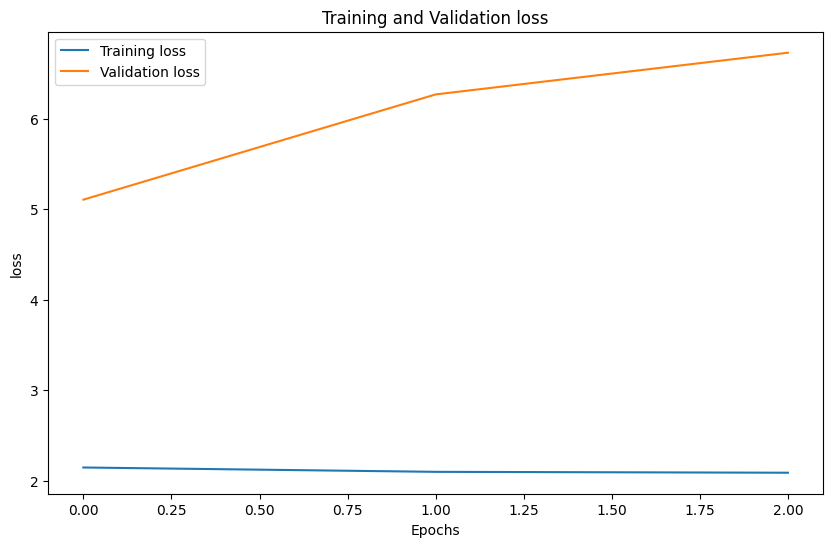

248/248 ━━━━━━━━━━━━━━━━━━━━ 59s 238ms/step - accuracy: 0.1076 - loss: 2.5422
Loss: 2.54951548576355
Accuracy: 0.10207939147949219
248/248 ━━━━━━━━━━━━━━━━━━━━ 57s 231ms/step
0.10207939508506617
              precision    recall  f1-score   support

     Country       0.10      1.00      0.19       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.00      0.00      0.00       495
     Hip-Hop       0.00      0.00      0.00       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.00      0.00      0.00       660
       Metal       0.00      0.00      0.00       810
         Pop       0.00      0.00      0.00      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.00      0.00      0.00      1410

    accuracy                           0.10      7935
   macro avg       0.01      0.10      0.02      7935
weighted avg       0.01      0.10      0.02      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

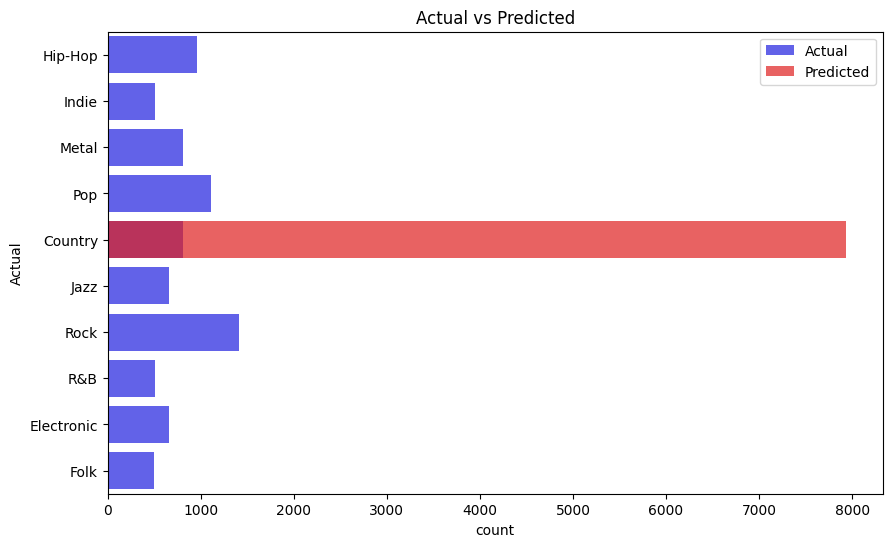

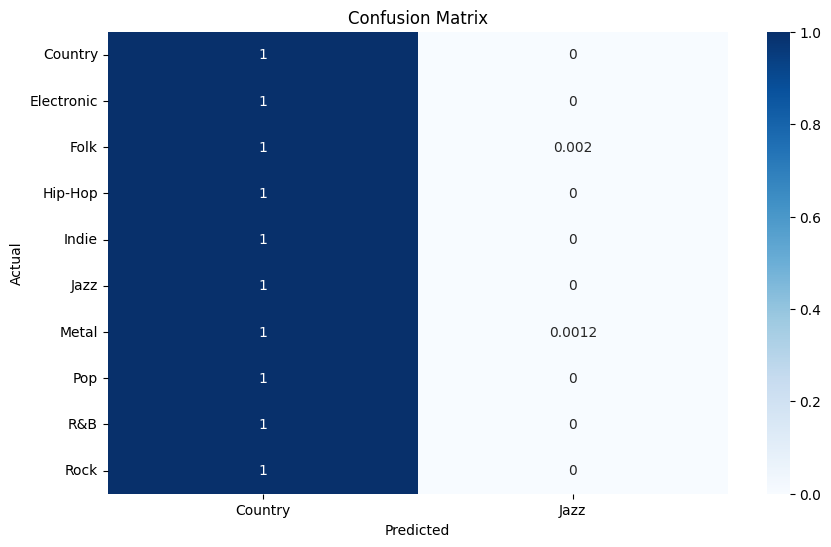

In [99]:
# plot the training results
plot_training_results(basic_multi_layer_lstm_model_history.history)
plot_training_results(basic_multi_layer_lstm_model_history.history, metric='loss')

# evaluate the model
evaluate_model(basic_multi_layer_lstm_model, X_test_lyrics, y_test, le)

# save the model
basic_multi_layer_lstm_model.save('models/basic_multi_layer_lstm_model.keras')

# save the history
basic_multi_layer_lstm_model_history_df = pd.DataFrame(basic_multi_layer_lstm_model_history.history)

# save the history to a csv file
basic_multi_layer_lstm_model_history_df.to_csv('results/basic_multi_layer_lstm_model_history.csv', index=False)

#### CNN Variants
As mentioned in the lecture notes, CNNs are designed to model local features while LSTMs are
very good at handling long range dependencies. Investigate the use of CNNs with multiple and
heterogeneous kernel sizes both as an alternative to an LSTM solution, and as an additional layer
before a LSTM solution.

In [30]:
def create_cnn_model(input_dim, 
                    embedding_dim,
                    dense_units,
                    dropout_rate,
                    max_length,
                    dense_activation='relu',
                    optimizer='adam',
                    max_length_artist=None,
                    artist_vocab_size=None,
                    kernel_size=3):
    # Create a list to store the inputs and features
    inputs_combined = []
    features = []
                
    # create an embedding layer
    embedding = Embedding(input_dim, embedding_dim, input_length=max_length) # Create an Embedding layer
    inputs = Input(shape=(max_length,)) # Define the input layer

    # create dense layers
    dense = embedding(inputs) # Add the Embedding layer
    dense = Conv1D(128, kernel_size, activation=dense_activation)(dense) # Add a Conv1D layer with 128 filters, a kernel size of 5 and ReLU activation
    dense = GlobalMaxPooling1D()(dense) # Add a GlobalMaxPooling1D layer, which will extract the most important features from the output of the Conv1D layer
    dense = Dense(dense_units, activation=dense_activation)(dense) # Add a Dense layer with 64 units and ReLU activation
    dense = Dropout(dropout_rate)(dense) # Add a Dropout layer with a dropout rate of 0.5
    features.append(dense) # Append the dense layer to the features list
    inputs_combined.append(inputs) # Append the input layer to the inputs list
    # Conditionally include artist input if vocab size is provided
    # Optional artist input using CNN
    if artist_vocab_size is not None:
        print("Artist information included")
        # Artist input
        artist_input = Input(shape=(max_length_artist,), name="Artist_Input")

        # Artist embedding
        artist_embedding = Embedding(artist_vocab_size, embedding_dim, input_length=max_length_artist)(artist_input)
        artist_dropout = Dropout(dropout_rate)(artist_embedding)
        
        # CNN for artist
        artist_conv = Conv1D(filters=128, kernel_size=5, activation=dense_activation)(artist_dropout)
        artist_pool = GlobalMaxPooling1D()(artist_conv)
        artist_dense = Dense(dense_units, activation=dense_activation)(artist_pool)
        artist_dropout = Dropout(dropout_rate)(artist_dense)
        features.append(artist_dropout)
        inputs_combined.append(artist_input)
    
    
    # Combine features if both are present
    if len(features) > 1:
        combined = Concatenate()(features)
    else:
        combined = features[0]
    
    # Dense layers
    combined_dense = Dense(dense_units, activation=dense_activation)(combined)
    combined_dropout = Dropout(dropout_rate)(combined_dense)
    
    # Output layer
    output = Dense(OUTPUT_DIM, activation='softmax', name="Output")(combined_dropout)
    
    # Build and compile the model
    model = Model(inputs=inputs_combined, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # return the model
    return model

##### CNN Lyrics Training & Evaluation

In [52]:
# create the model
basic_cnn_model = create_cnn_model(
    input_dim=vocab_size_lyrics, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=max_length_lyrics, 
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER
)

# train the model
basic_cnn_model_history = basic_cnn_model.fit(X_train_lyrics, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, callbacks=callbacks)

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.1517 - loss: 2.1516 - val_accuracy: 0.0000e+00 - val_loss: 5.9972 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.2967 - loss: 1.7806 - val_accuracy: 0.0000e+00 - val_loss: 6.4500 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.4122 - loss: 1.5100 - val_accuracy: 0.0000e+00 - val_loss: 8.7320 - learning_rate: 0.0010


In [53]:
# model summary
basic_cnn_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2009)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 2009, 100)      │     8,113,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2007, 128)      │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,495,584 (93.44 MB)

 Trainable params: 8,165,194 (31.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,330,390 (62.30 MB)

##### Results

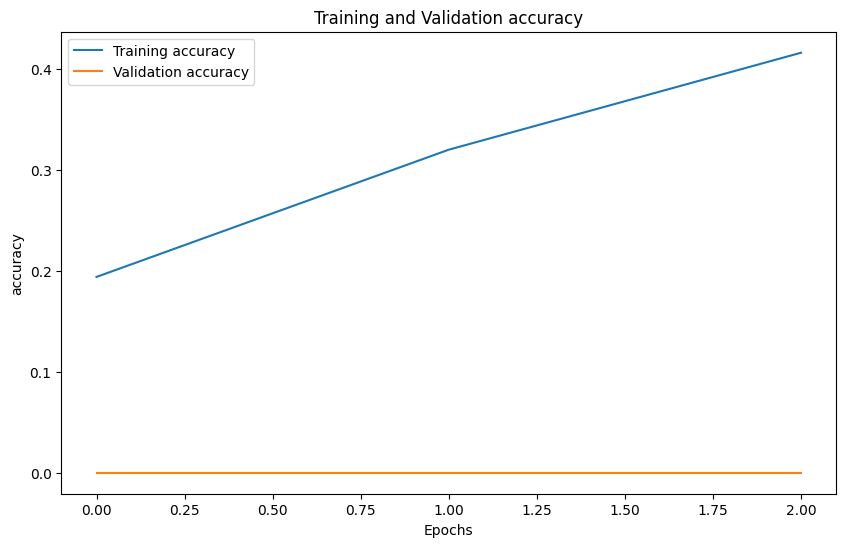

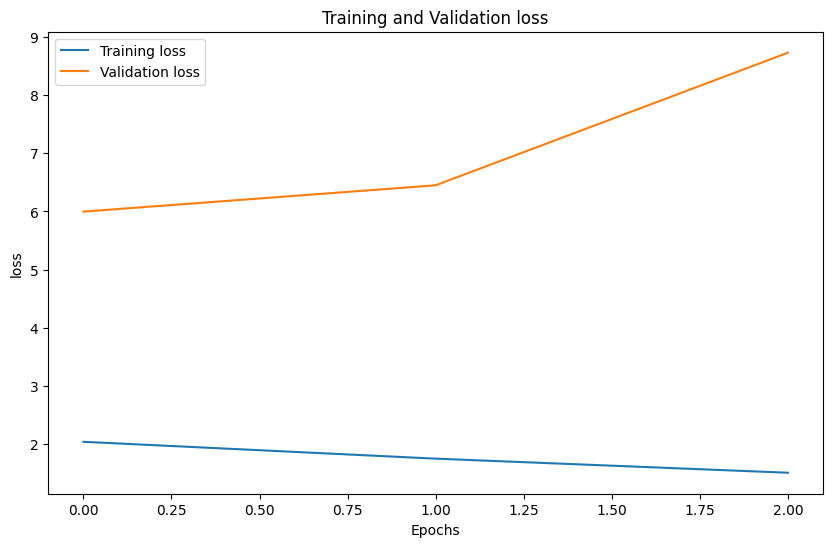

248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2531 - loss: 2.4134
Loss: 2.4301743507385254
Accuracy: 0.2530560791492462
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
0.25305608065532453
              precision    recall  f1-score   support

     Country       0.22      0.14      0.17       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.09      0.09      0.09       495
     Hip-Hop       0.76      0.82      0.79       960
       Indie       0.10      0.05      0.06       510
        Jazz       0.13      0.68      0.22       660
       Metal       0.38      0.22      0.28       810
         Pop       0.22      0.16      0.18      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.26      0.17      0.20      1410

    accuracy                           0.25      7935
   macro avg       0.21      0.23      0.20      7935
weighted avg       0.25      0.25      0.23      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

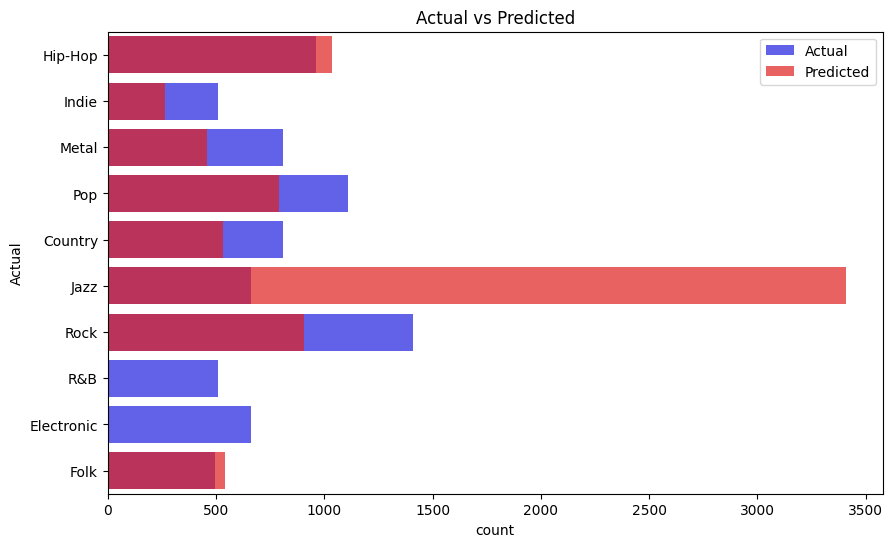

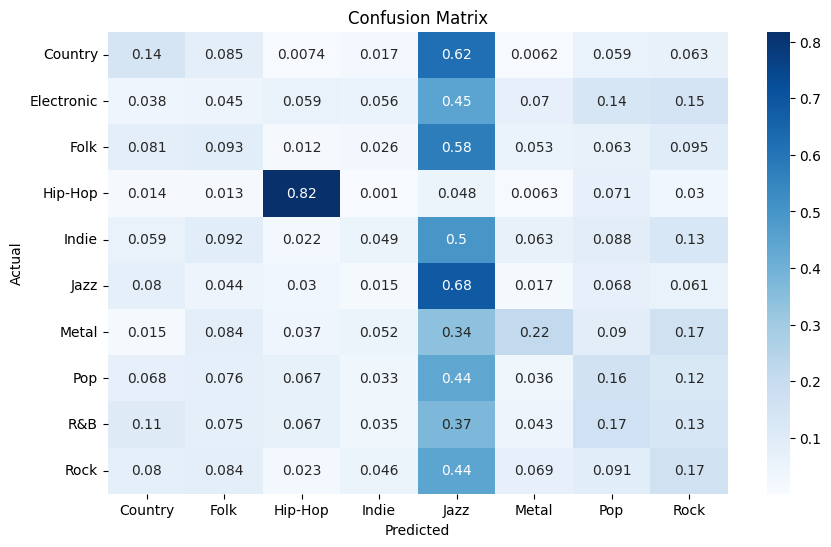

In [100]:
# plot the training results
plot_training_results(basic_cnn_model_history.history)
plot_training_results(basic_cnn_model_history.history, metric='loss')

# evaluate the model
evaluate_model(basic_cnn_model, X_test_lyrics, y_test, le)

# save the model
basic_cnn_model.save('models/basic_cnn_model.keras')

# save the history
basic_cnn_model_history_df = pd.DataFrame(basic_cnn_model_history.history)

# save the history to a csv file
basic_cnn_model_history_df.to_csv('results/basic_cnn_model_history.csv', index=False)

#### Comparison to Non-Neural Methods
Select a non-neural method of your choosing, e.g, SVM, Naive Bayes, Random Forests, and
compare the performance of one of your best performing neural models against the non-neural
method.

In [22]:
def create_rf_model():
    """
    Creates and returns a RandomForestClassifier model with predefined parameters.

    The model is initialized with 100 estimators and a random state of 42 for reproducibility.

    Returns:
        RandomForestClassifier: A configured RandomForestClassifier model.
    """
    model = RandomForestClassifier(
                n_estimators=100, 
                random_state=42
            )
    return model

In [23]:
# create the model
rf_model = create_rf_model()

In [24]:
# train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

##### Results

In [ ]:
y_pred = rf_model.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.01      0.01       810
           1       0.86      0.01      0.02       660
           2       0.47      0.02      0.04       495
           3       0.82      0.39      0.53       960
           4       0.80      0.01      0.02       510
           5       0.87      0.07      0.13       660
           6       0.58      0.01      0.02       810
           7       0.25      0.00      0.00      1110
           8       0.20      0.00      0.01       510
           9       0.55      0.00      0.01      1410

   micro avg       0.79      0.06      0.11      7935
   macro avg       0.64      0.05      0.08      7935
weighted avg       0.63      0.06      0.08      7935
 samples avg       0.06      0.06      0.06      7935

0.05784499054820416


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Base Models Lyrics and Artist

##### Training and Evaluation RNN Model, Lyrics and Artist

In [58]:
# Create the combined RNN model
combined_rnn_model = create_rnn_model(
    input_dim=vocab_size_lyrics, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=max_length_lyrics, 
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER, 
    max_length_artist=max_length_artist,
    artist_vocab_size=vocab_size_artist
)

# Train the combined RNN model
combined_rnn_model_history = combined_rnn_model.fit(
    [X_train_lyrics, X_train_artist], y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    callbacks=callbacks
)

Artist information included
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 130s 272ms/step - accuracy: 0.3028 - loss: 1.8523 - val_accuracy: 0.0000e+00 - val_loss: 6.1514 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 127s 269ms/step - accuracy: 0.8247 - loss: 0.5952 - val_accuracy: 0.0000e+00 - val_loss: 10.1541 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 131s 277ms/step - accuracy: 0.9250 - loss: 0.2904 - val_accuracy: 0.0000e+00 - val_loss: 13.4307 - learning_rate: 0.0010


###### Results

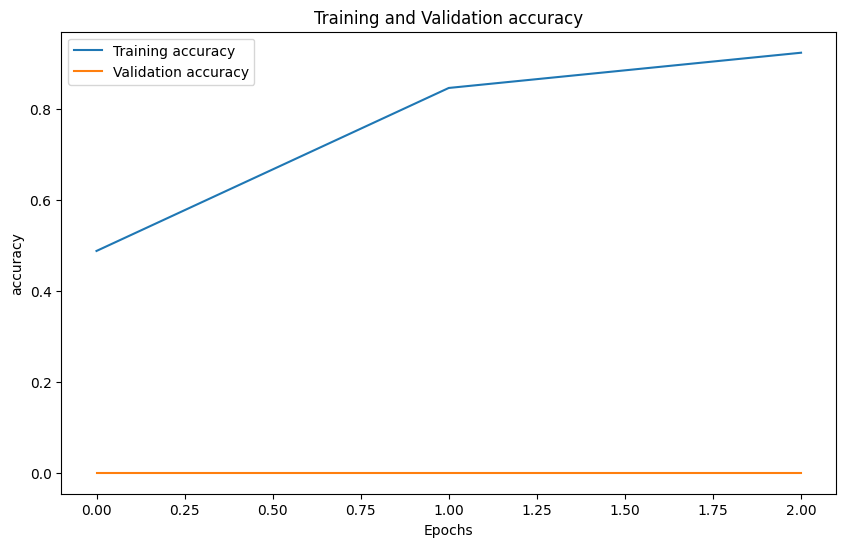

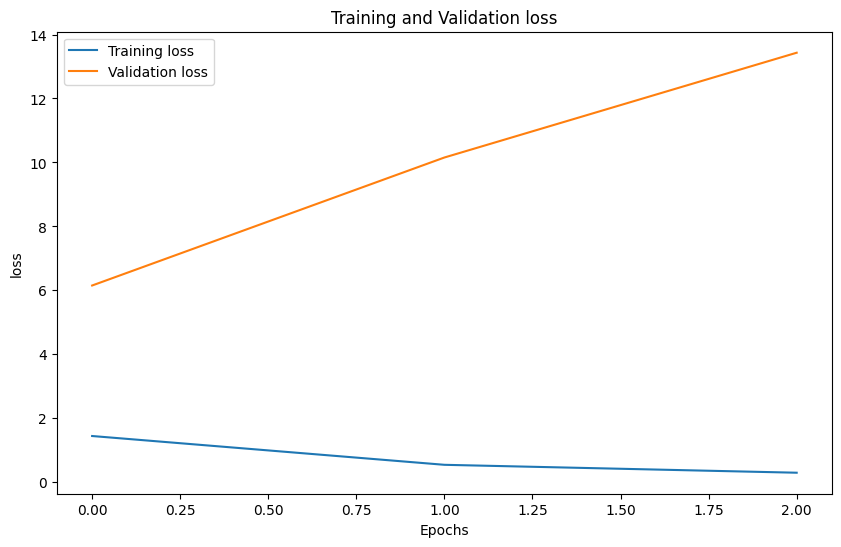

248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.5100 - loss: 1.9978
Loss: 1.9998743534088135
Accuracy: 0.5072463750839233
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step
0.5072463768115942
              precision    recall  f1-score   support

     Country       0.68      0.94      0.79       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.74      0.71      0.73       495
     Hip-Hop       0.73      0.83      0.78       960
       Indie       0.42      0.68      0.52       510
        Jazz       0.58      0.75      0.66       660
       Metal       0.53      0.39      0.45       810
         Pop       0.29      0.42      0.34      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.36      0.35      0.36      1410

    accuracy                           0.51      7935
   macro avg       0.43      0.51      0.46      7935
weighted avg       0.44      0.51      0.46      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

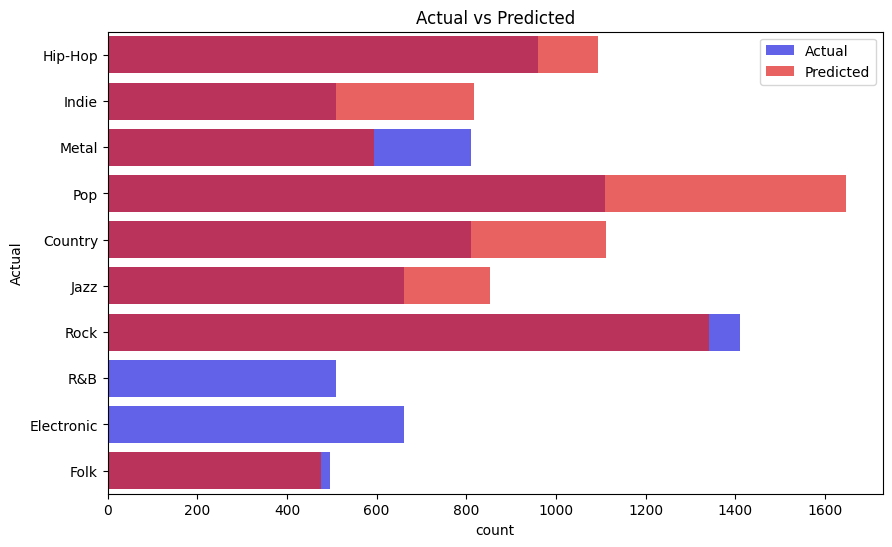

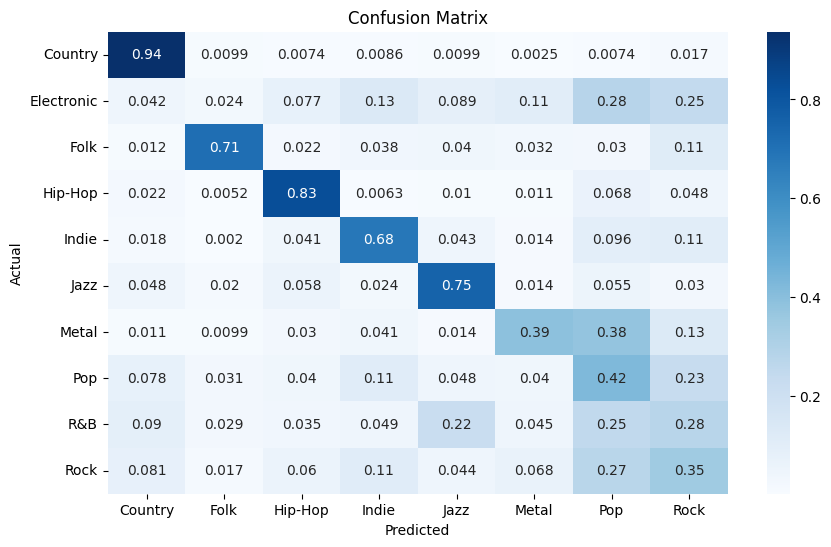

In [101]:
# plot the training results
plot_training_results(combined_rnn_model_history.history)
plot_training_results(combined_rnn_model_history.history, metric='loss')

# Evaluate the model
evaluate_model(combined_rnn_model, [X_test_lyrics, X_test_artist], y_test, le)

# Save the model
combined_rnn_model.save("models/combined_rnn_model.keras")

# Save the history
combined_rnn_model_history_df = pd.DataFrame(combined_rnn_model_history.history)

# Save the history to a CSV file
combined_rnn_model_history_df.to_csv("results/combined_rnn_model_history.csv", index=False)

##### Single Layer LSTM Training and Evaluation, Lyrics and Artist

In [60]:
# Create combined model
combined_lstm_single_layer_model = create_single_lstm_model(
    input_dim=vocab_size_lyrics, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=max_length_lyrics, 
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER, 
    max_length_artist=max_length_artist,
    artist_vocab_size=vocab_size_artist, 
)

# print the model summary
combined_lstm_single_layer_model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Lyrics_Input        │ (None, 2009)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Artist_Input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 2009, 100) │  8,113,600 │ Lyrics_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 7, 100)    │    542,500 │ Artist_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     42,240 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 64)        │     42,240 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ lstm_3[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 100)       │      6,500 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 164)       │          0 │ dropout_11[0][0], │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │     10,560 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 10)        │        650 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,758,290 (33.41 MB)

 Trainable params: 8,758,290 (33.41 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Train combined model
combined_lstm_single_layer_model_history = combined_lstm_single_layer_model.fit(
    [X_train_lyrics, X_train_artist], y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    callbacks=callbacks
)

Epoch 1/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 280s 589ms/step - accuracy: 0.1918 - loss: 2.0308 - val_accuracy: 0.0000e+00 - val_loss: 8.9243 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 282s 596ms/step - accuracy: 0.7932 - loss: 0.7035 - val_accuracy: 0.0000e+00 - val_loss: 10.0238 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 276s 584ms/step - accuracy: 0.9110 - loss: 0.3415 - val_accuracy: 0.0000e+00 - val_loss: 12.3270 - learning_rate: 0.0010


###### Results

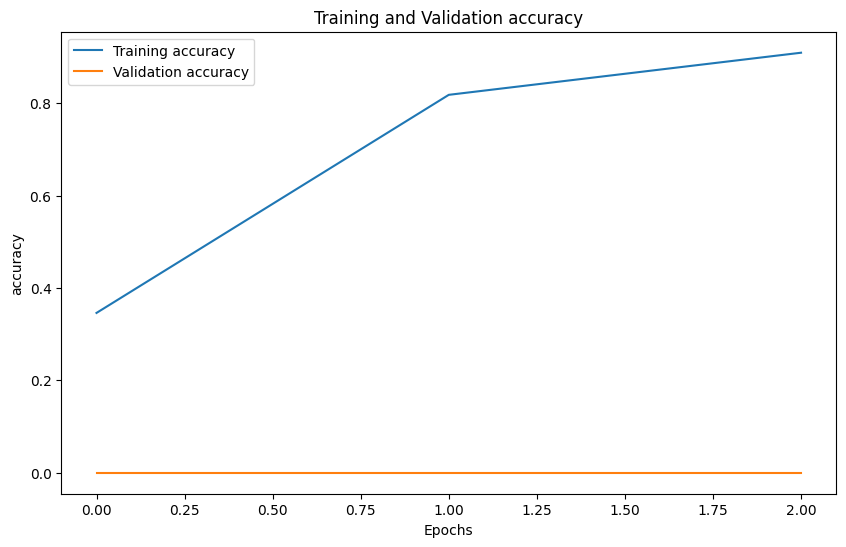

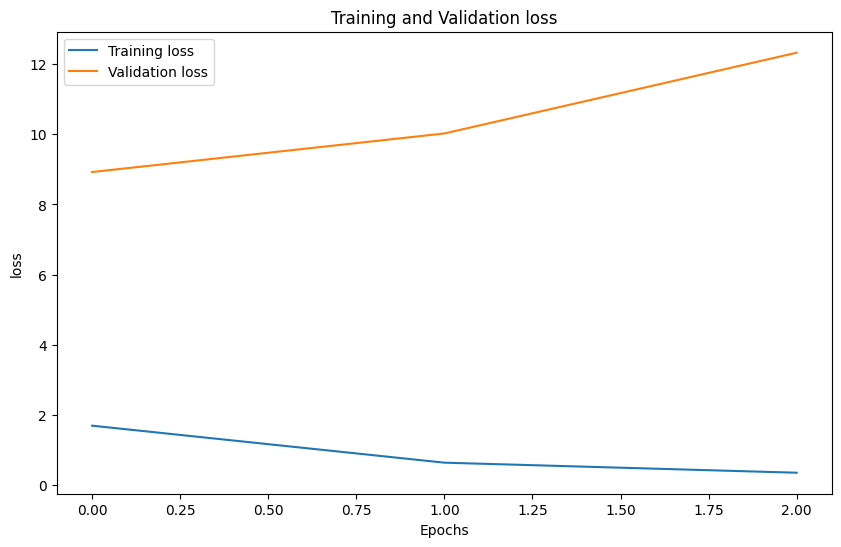

248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.4381 - loss: 2.5252
Loss: 2.5680551528930664
Accuracy: 0.43679898977279663
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step
0.4367989918084436
              precision    recall  f1-score   support

     Country       0.66      0.87      0.75       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.80      0.42      0.55       495
     Hip-Hop       0.53      0.83      0.65       960
       Indie       0.55      0.45      0.50       510
        Jazz       0.56      0.62      0.58       660
       Metal       0.46      0.30      0.37       810
         Pop       0.22      0.46      0.30      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.32      0.26      0.28      1410

    accuracy                           0.44      7935
   macro avg       0.41      0.42      0.40      7935
weighted avg       0.40      0.44      0.40      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [102]:
# plot the training results
plot_training_results(combined_lstm_single_layer_model_history.history)
plot_training_results(combined_lstm_single_layer_model_history.history, metric='loss')

# Evaluate combined model
evaluate_model(combined_lstm_single_layer_model, [X_test_lyrics, X_test_artist], y_test, le)

# save the model
combined_lstm_single_layer_model.save('models/combined_lstm_single_layer_model.keras')

# save the history
combined_lstm_single_layer_model_history_df = pd.DataFrame(combined_lstm_single_layer_model_history.history)

# save the history to a csv file
combined_lstm_single_layer_model_history_df.to_csv('results/combined_lstm_single_layer_model_history.csv', index=False)

##### Multi-Layer LSTM Training and Evaluation, Lyrics and Artist

In [63]:
# create the model
combined_multi_layer_lstm_model = create_multi_lstm_model(
    input_dim=vocab_size_lyrics, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=max_length_lyrics, 
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER, 
    max_length_artist=max_length_artist,
    artist_vocab_size=vocab_size_artist
)

combined_multi_layer_lstm_model.summary()

# train the model
combined_multi_layer_lstm_model_history = combined_multi_layer_lstm_model.fit([X_train_lyrics, X_train_artist], y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=callbacks)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Lyrics_Input        │ (None, 2009)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 2009, 100) │  8,113,600 │ Lyrics_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Artist_Input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 2009, 64)  │     42,240 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 7, 100)    │    542,500 │ Artist_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 64)        │     33,024 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 64)        │     42,240 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ lstm_6[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 100)       │      6,500 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 164)       │          0 │ dropout_13[0][0], │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │     10,560 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 10)        │        650 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,791,314 (33.54 MB)

 Trainable params: 8,791,314 (33.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 544s 1s/step - accuracy: 0.1786 - loss: 2.0490 - val_accuracy: 0.0000e+00 - val_loss: 7.5281 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - accuracy: 0.6717 - loss: 0.9421 - val_accuracy: 0.0000e+00 - val_loss: 11.3637 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.8441 - loss: 0.5141 - val_accuracy: 0.0000e+00 - val_loss: 13.5130 - learning_rate: 0.0010


###### Results

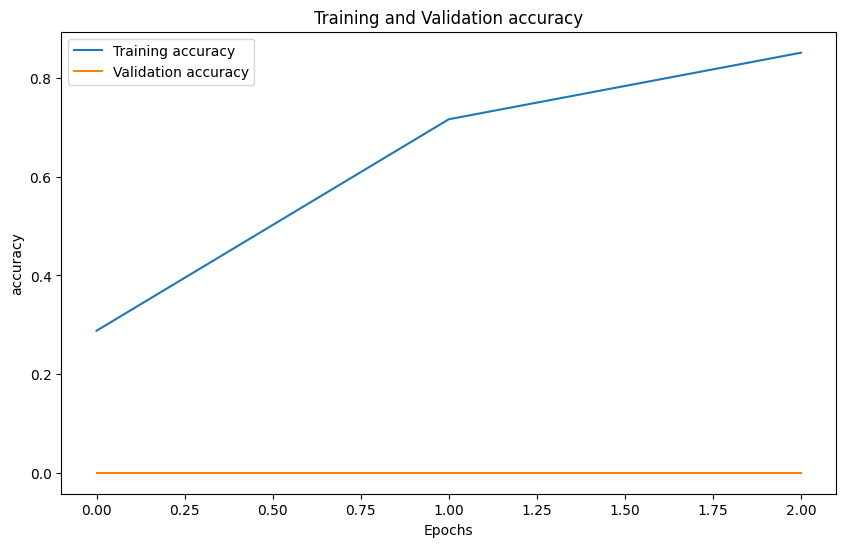

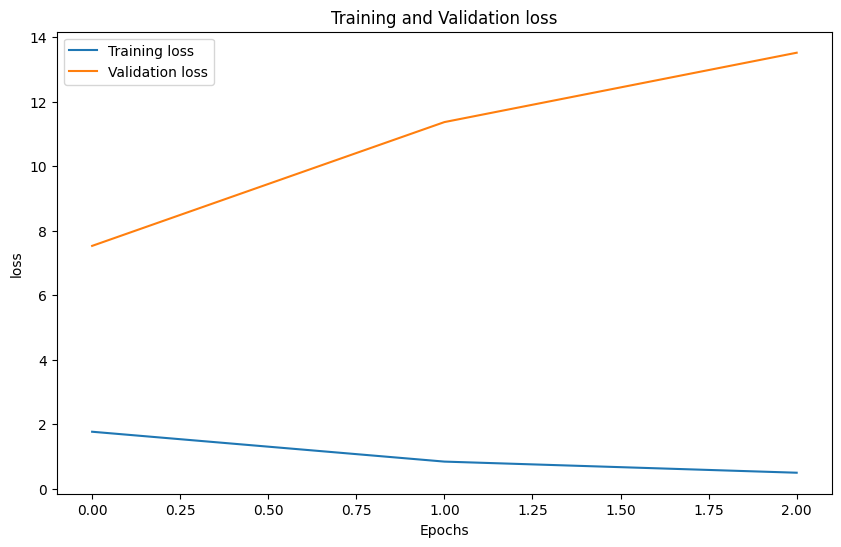

248/248 ━━━━━━━━━━━━━━━━━━━━ 56s 227ms/step - accuracy: 0.3784 - loss: 2.4261
Loss: 2.4356942176818848
Accuracy: 0.3752993047237396
248/248 ━━━━━━━━━━━━━━━━━━━━ 56s 226ms/step
0.375299306868305
              precision    recall  f1-score   support

     Country       0.70      0.90      0.79       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.37      0.63      0.46       495
     Hip-Hop       0.36      0.80      0.50       960
       Indie       0.28      0.31      0.29       510
        Jazz       0.50      0.42      0.45       660
       Metal       0.55      0.24      0.33       810
         Pop       0.22      0.43      0.29      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.23      0.04      0.07      1410

    accuracy                           0.38      7935
   macro avg       0.32      0.38      0.32      7935
weighted avg       0.33      0.38      0.31      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

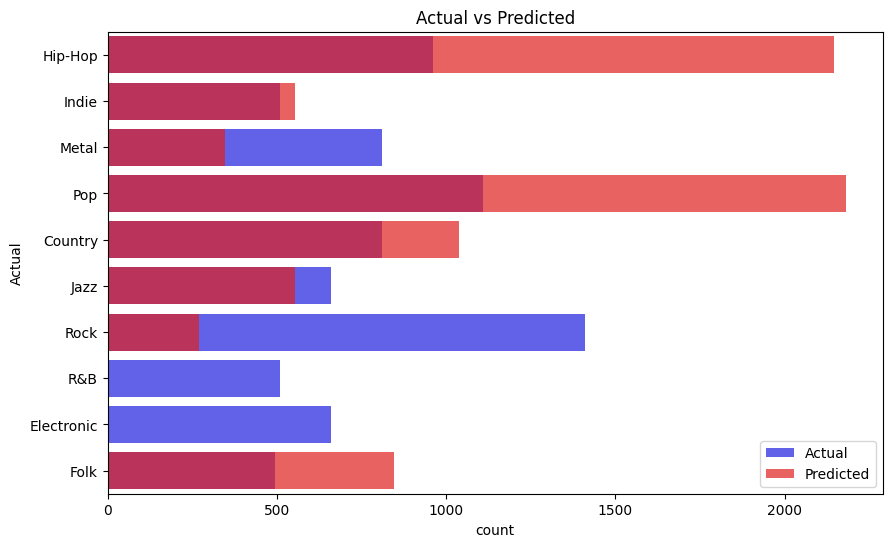

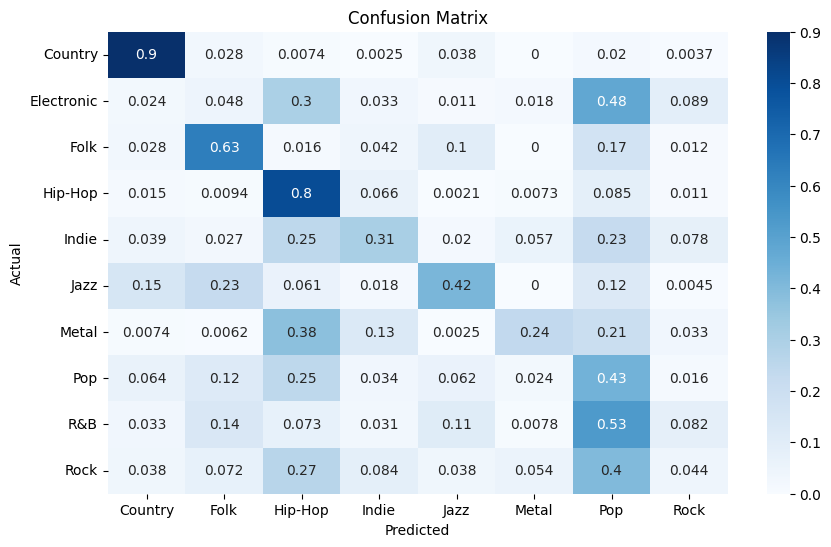

In [103]:
# plot the training results
plot_training_results(combined_multi_layer_lstm_model_history.history)
plot_training_results(combined_multi_layer_lstm_model_history.history, metric='loss')

# evaluate the model
evaluate_model(combined_multi_layer_lstm_model, [X_test_lyrics, X_test_artist], y_test, le)

# save the model
combined_multi_layer_lstm_model.save('models/combined_multi_layer_lstm_model.keras')

# save the history
combined_multi_layer_lstm_model_history_df = pd.DataFrame(combined_multi_layer_lstm_model_history.history)

# save the history to a csv file
combined_multi_layer_lstm_model_history_df.to_csv('results/combined_multi_layer_lstm_model_history.csv', index=False)

#### Multi LSTM Layer + Pretrained Embeddings
Distributed embeddings provide a lot of power in text classification, but there are many different
Embeddings types that can be used. Compare classification between Embeddings learned on the
fly to any pre-trained word embedding available from the Tensorflow Hub or similar sources.
Compare embeddings based approaches to a more traditional text encoding approach.

In [ ]:
def create_multi_lstm_model_with_pretrained_embedding(
    embedding_matrix,
    dense_units,
    dropout_rate,
    max_length,
    dense_activation='relu',
    optimizer='adam',
    max_length_artist=None,
    artist_vocab_size=None,
    artist_embedding_matrix=None
):
    """
    Create a multi-layer LSTM model using pretrained embeddings.
    
    Parameters:
        embedding_matrix (np.ndarray): Pretrained embedding matrix for lyrics.
        dense_units (int): Number of units in LSTM and dense layers.
        dropout_rate (float): Dropout rate for regularization.
        max_length (int): Maximum sequence length for lyrics.
        dense_activation (str): Activation function for dense layers.
        optimizer (str): Optimizer for model training.
        artist_vocab_size (int): Vocabulary size for artist data (optional).
        artist_embedding_matrix (np.ndarray): Pretrained embedding matrix for artist data (optional).
    
    Returns:
        model (keras.Model): Compiled Keras model.
    """
    inputs_combined = []
    features = []
    
    # Lyrics input and embedding
    vocab_size, embedding_dim = embedding_matrix.shape
    lyrics_input = Input(shape=(max_length,), name="Lyrics_Input")
    lyrics_embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False,  # Set to True to fine-tune embeddings
        name="Lyrics_Embedding"
    )(lyrics_input)
    
    # Multi-layer LSTM for lyrics
    lstm_layer_1 = LSTM(dense_units, return_sequences=True)(lyrics_embedding)
    lstm_layer_2 = LSTM(dense_units)(lstm_layer_1)

    # Dropout layer
    lyrics_dropout = Dropout(dropout_rate)(lstm_layer_2)
    features.append(lyrics_dropout)
    inputs_combined.append(lyrics_input)

    artist_input = Input(shape=(max_length_artist,), name="Artist_Input")
    artist_vocab_size, artist_embedding_dim = artist_embedding_matrix.shape
    artist_embedding_layer = Embedding(
        input_dim=artist_vocab_size,
        output_dim=artist_embedding_dim,
        weights=[artist_embedding_matrix],
        input_length=max_length_artist,
        trainable=False,  # Set to True to fine-tune embeddings
        name="Artist_Embedding"
    )(artist_input)
    artist_lstm = LSTM(dense_units)(artist_embedding_layer)
    artist_dense = Dense(embedding_dim, activation=dense_activation)(artist_lstm)
    inputs_combined.append(artist_input)
    features.append(artist_dense)

    combined_features = Concatenate()(features)
    
    # Fully connected layers
    dense_layer = Dense(dense_units, activation=dense_activation)(combined_features)
    dropout_layer = Dropout(dropout_rate)(dense_layer)
    
    # Output layer
    output = Dense(OUTPUT_DIM, activation='softmax', name="Output")(dropout_layer)
    
    # Build and compile the model
    model = Model(inputs=inputs_combined, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [66]:
# Retrieve the word_index
lyrics_word_index = lyrics_tokenizer.word_index

# Output word_index
print("Lyrics Word Index:", lyrics_word_index)
print("Lyrics Vocabulary Size:", len(lyrics_word_index) + 1)

# Retrieve the artist word_index
artist_word_index = artist_tokenizer.word_index

# Output artist_word_index
print("Artist Word Index:", artist_word_index)
print("Artist Vocabulary Size:", len(artist_word_index) + 1)

Lyrics Word Index: {'<UNK>': 1, 'the': 2, 'you': 3, 'and': 4, 'to': 5, 'me': 6, 'my': 7, 'in': 8, 'it': 9, 'of': 10, 'that': 11, 'your': 12, 'on': 13, 'im': 14, 'all': 15, 'is': 16, 'for': 17, 'be': 18, 'we': 19, 'no': 20, 'love': 21, 'so': 22, 'dont': 23, 'with': 24, 'like': 25, 'but': 26, 'its': 27, 'know': 28, 'up': 29, 'this': 30, 'just': 31, 'when': 32, 'what': 33, 'do': 34, 'get': 35, 'got': 36, 'now': 37, 'can': 38, 'if': 39, 'oh': 40, 'out': 41, 'go': 42, 'was': 43, 'they': 44, 'down': 45, 'one': 46, 'time': 47, 'see': 48, 'never': 49, 'youre': 50, 'are': 51, 'from': 52, 'cant': 53, 'have': 54, 'will': 55, 'not': 56, 'want': 57, 'baby': 58, 'she': 59, 'come': 60, 'at': 61, 'say': 62, 'cause': 63, 'yeah': 64, 'back': 65, 'as': 66, 'way': 67, 'let': 68, 'make': 69, 'he': 70, 'ill': 71, 'her': 72, 'how': 73, 'take': 74, 'aint': 75, 'were': 76, 'there': 77, 'life': 78, 'feel': 79, 'here': 80, 'right': 81, 'away': 82, 'been': 83, 'que': 84, 'heart': 85, 'tell': 86, 'ive': 87, 'where

In [67]:
# Initialize the embedding matrix
lyrics_vocab_size = len(lyrics_word_index) + 1  # Include padding
embedding_matrix = np.zeros((lyrics_vocab_size, EMBEDDING_DIM))

# Path to GloVe file
glove_path = './data/embeddings/glove.6B/glove.6B.100d.txt'

# Load GloVe embeddings
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        if word in artist_word_index:
            idx = artist_word_index[word]
            embedding_matrix[idx] = np.array(vector, dtype=np.float32)

print("Lyrics mbedding matrix shape:", embedding_matrix.shape)

# Initialize the embedding matrix
artist_vocab_size = len(artist_word_index) + 1  # Include padding
artist_embedding_matrix = np.zeros((artist_vocab_size, EMBEDDING_DIM))

# Load GloVe embeddings
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        if word in artist_word_index:
            idx = artist_word_index[word]
            artist_embedding_matrix[idx] = np.array(vector, dtype=np.float32)

print("Artist mbedding matrix shape:", artist_embedding_matrix.shape)


Lyrics mbedding matrix shape: (81136, 100)
Artist mbedding matrix shape: (5425, 100)


In [68]:
multi_layer_lstm_pretrained_model = create_multi_lstm_model_with_pretrained_embedding(
    embedding_matrix=embedding_matrix,
    dense_units=UNITS,
    dropout_rate=DROPOUT_RATE,
    max_length=max_length_lyrics,
    dense_activation='relu',
    optimizer='adam',
    max_length_artist=max_length_artist,
    artist_vocab_size=artist_vocab_size,
    artist_embedding_matrix=artist_embedding_matrix
)

multi_layer_lstm_pretrained_model.summary()

# Train the model
multi_layer_lstm_pretrained_model_history = multi_layer_lstm_pretrained_model.fit(
    [X_train_lyrics, X_train_artist], y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    callbacks=callbacks
)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Lyrics_Input        │ (None, 2009)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Lyrics_Embedding    │ (None, 2009, 100) │  8,113,600 │ Lyrics_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Artist_Input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 2009, 64)  │     42,240 │ Lyrics_Embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Artist_Embedding    │ (None, 7, 100)    │    542,500 │ Artist_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 64)        │     33,024 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 64)        │     42,240 │ Artist_Embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 100)       │      6,500 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 164)       │          0 │ dropout_15[0][0], │
│ (Concatenate)       │                   │            │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │     10,560 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 10)        │        650 │ dropout_16[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,791,314 (33.54 MB)

 Trainable params: 135,214 (528.18 KB)

 Non-trainable params: 8,656,100 (33.02 MB)

Epoch 1/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 446s 939ms/step - accuracy: 0.2668 - loss: 1.9339 - val_accuracy: 0.0000e+00 - val_loss: 7.5559 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 446s 942ms/step - accuracy: 0.5815 - loss: 1.2584 - val_accuracy: 0.0000e+00 - val_loss: 10.4974 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 445s 941ms/step - accuracy: 0.6896 - loss: 0.9679 - val_accuracy: 0.0000e+00 - val_loss: 12.1356 - learning_rate: 0.0010


##### Results

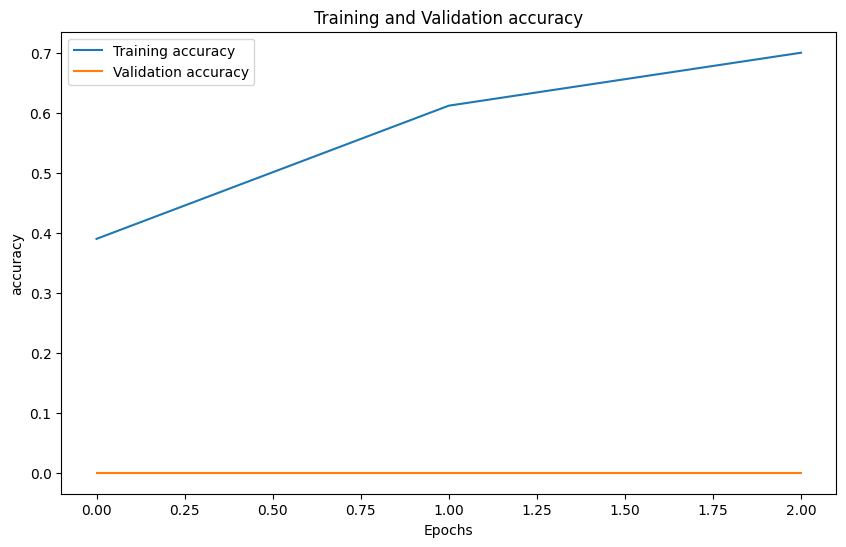

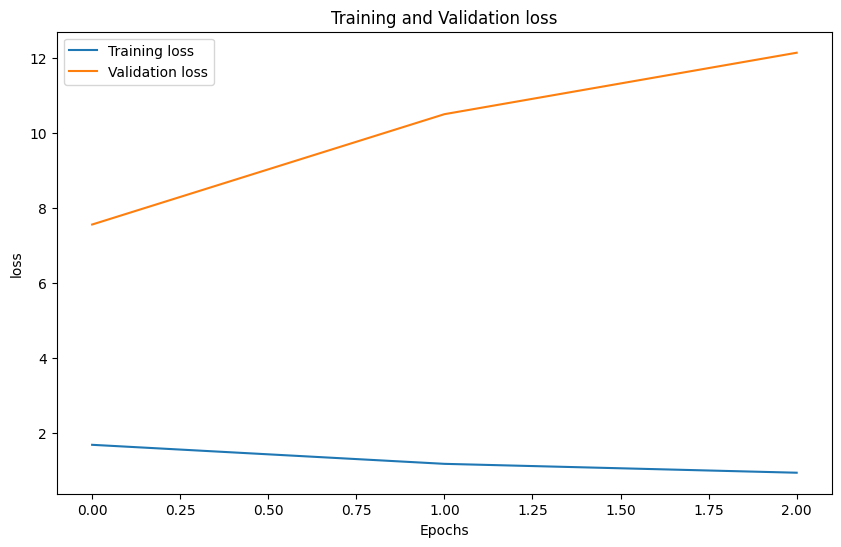

248/248 ━━━━━━━━━━━━━━━━━━━━ 57s 230ms/step - accuracy: 0.3522 - loss: 2.3982
Loss: 2.4155237674713135
Accuracy: 0.3493383824825287
248/248 ━━━━━━━━━━━━━━━━━━━━ 56s 227ms/step
0.3493383742911153
              precision    recall  f1-score   support

     Country       0.58      0.71      0.64       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.31      0.27      0.29       495
     Hip-Hop       0.50      0.65      0.57       960
       Indie       0.11      0.52      0.18       510
        Jazz       0.44      0.56      0.49       660
       Metal       0.43      0.42      0.43       810
         Pop       0.41      0.26      0.32      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.41      0.12      0.19      1410

    accuracy                           0.35      7935
   macro avg       0.32      0.35      0.31      7935
weighted avg       0.36      0.35      0.33      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

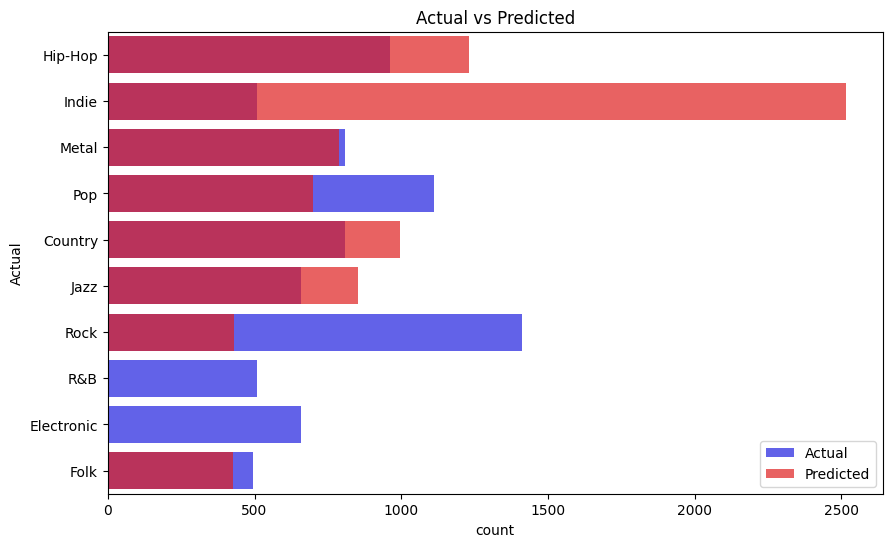

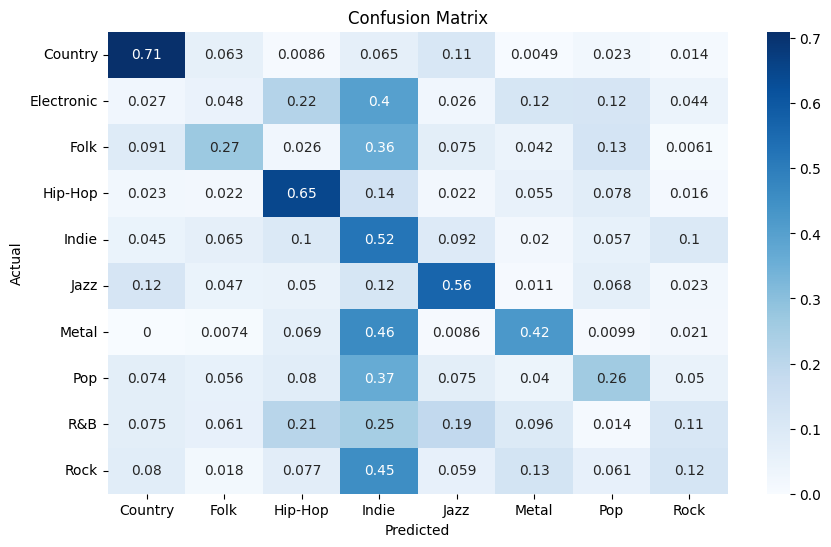

In [104]:
# plot the training results
plot_training_results(multi_layer_lstm_pretrained_model_history.history)
plot_training_results(multi_layer_lstm_pretrained_model_history.history, metric='loss')

# Evaluate the model
evaluate_model(multi_layer_lstm_pretrained_model, [X_test_lyrics, X_test_artist], y_test, le)

# Save the model
multi_layer_lstm_pretrained_model.save("models/multi_lstm_pretrained_embedding_model.keras")

# Save the history
multi_layer_lstm_pretrained_model_history_df = pd.DataFrame(multi_layer_lstm_pretrained_model_history.history)

# Save the history to a CSV file
multi_layer_lstm_pretrained_model_history_df.to_csv("results/multi_lstm_pretrained_embedding_model_history.csv", index=False)

#### CNN Variants

##### CNN Lyrics & Artist Training & Evaluation

In [70]:
# create the model with artist information
cnn_model_combined = create_cnn_model(
    input_dim=vocab_size_lyrics, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=max_length_lyrics, 
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER, 
    max_length_artist=max_length_artist,
    artist_vocab_size=vocab_size_artist
)

# train the model
cnn_model_combined_history = cnn_model_combined.fit([X_train_lyrics, X_train_artist], y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, callbacks=callbacks)


Artist information included
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 0.1595 - loss: 2.1182 - val_accuracy: 0.0000e+00 - val_loss: 6.4133 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.6281 - loss: 1.0375 - val_accuracy: 0.0000e+00 - val_loss: 9.2295 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.8336 - loss: 0.5393 - val_accuracy: 0.0000e+00 - val_loss: 10.3648 - learning_rate: 0.0010


In [71]:
# model summary
cnn_model_combined.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Artist_Input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2009)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 7, 100)    │    542,500 │ Artist_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 2009, 100) │  8,113,600 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 7, 100)    │          0 │ embedding_11[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2007, 128) │     38,528 │ embedding_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 3, 128)    │     64,128 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64)        │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ dropout_17[0][0], │
│ (Concatenate)       │                   │            │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      8,256 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 10)        │        650 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,352,524 (100.53 MB)

 Trainable params: 8,784,174 (33.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,568,350 (67.02 MB)

###### Results

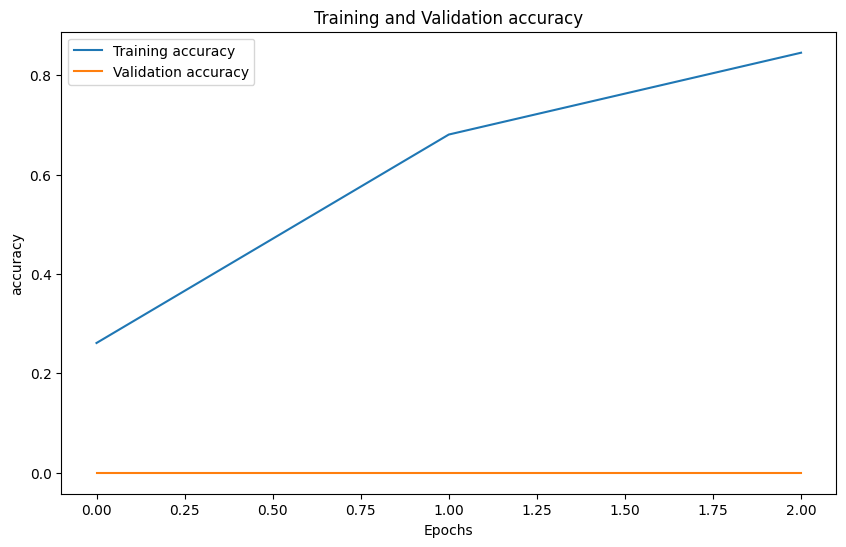

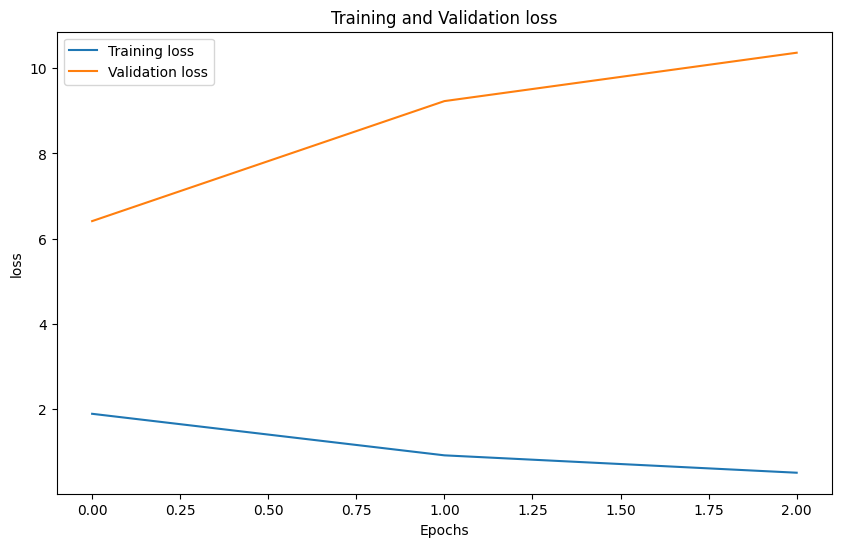

248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4320 - loss: 2.0731
Loss: 2.097790479660034
Accuracy: 0.43049779534339905
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
0.43049779458097037
              precision    recall  f1-score   support

     Country       0.65      0.87      0.74       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.43      0.55      0.48       495
     Hip-Hop       0.59      0.88      0.71       960
       Indie       0.40      0.34      0.37       510
        Jazz       0.57      0.45      0.51       660
       Metal       0.28      0.72      0.41       810
         Pop       0.32      0.11      0.16      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.30      0.30      0.30      1410

    accuracy                           0.43      7935
   macro avg       0.35      0.42      0.37      7935
weighted avg       0.37      0.43      0.37      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

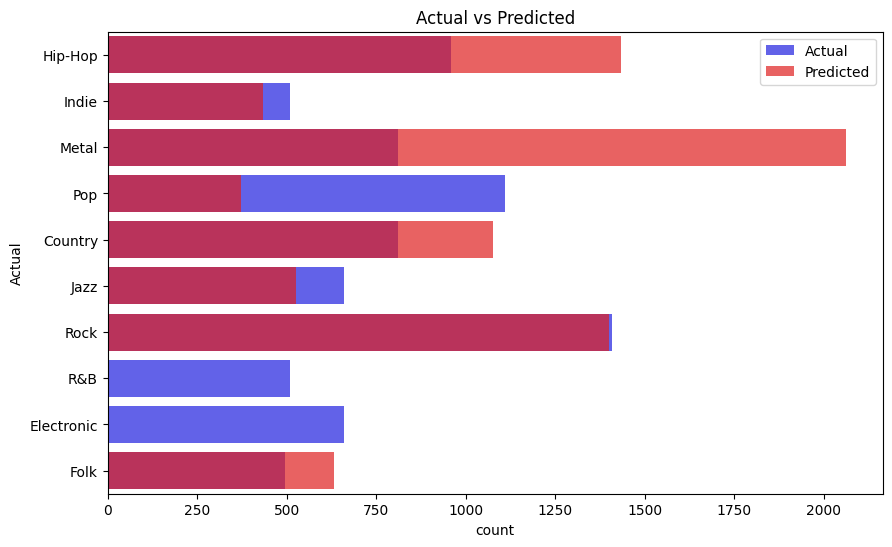

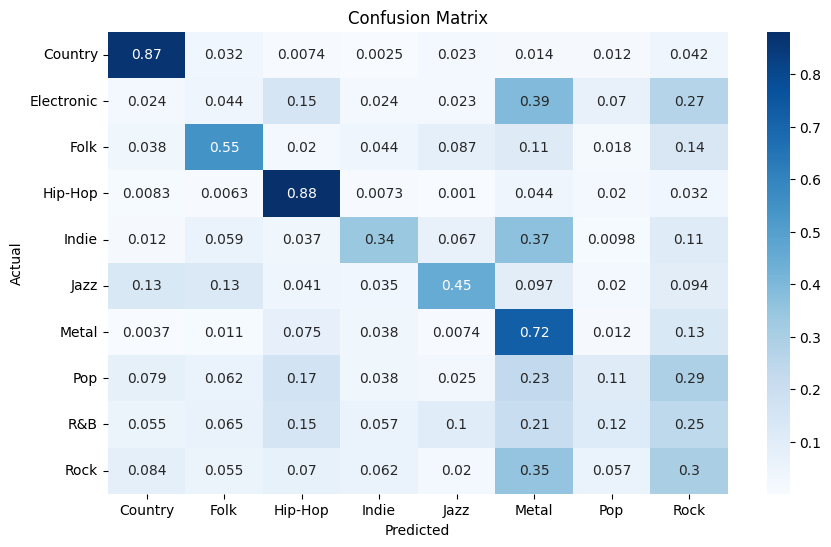

In [105]:
# plot the training results
plot_training_results(cnn_model_combined_history.history)
plot_training_results(cnn_model_combined_history.history, metric='loss')

# evaluate the model
evaluate_model(cnn_model_combined, [X_test_lyrics, X_test_artist], y_test, le)

# save the model
cnn_model_combined.save('models/cnn_model_combined.keras')

# save the history
cnn_model_combined_history_df = pd.DataFrame(cnn_model_combined_history.history)

# save the history to a csv file
cnn_model_combined_history_df.to_csv('results/cnn_model_combined_history.csv', index=False)

###### Kernal Size Comparison Results

Artist information included
Training model with kernel size: 3
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.1935 - loss: 2.0539 - val_accuracy: 0.0000e+00 - val_loss: 6.0381 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.6619 - loss: 0.9810 - val_accuracy: 0.0000e+00 - val_loss: 8.7436 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.8443 - loss: 0.5146 - val_accuracy: 0.0000e+00 - val_loss: 10.5515 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4403 - loss: 2.0250
Loss: 2.037802219390869
Accuracy: 0.44183996319770813
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
0.44183994959042217
              precision    recall  f1-score   support

     Country       0.67      0.88      0.76       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.41      0.69      0.51       495
     Hip-Hop       0.74      0.86      0.80       960
       Indie       0.28      0.57      0.38       510
        Jazz       0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

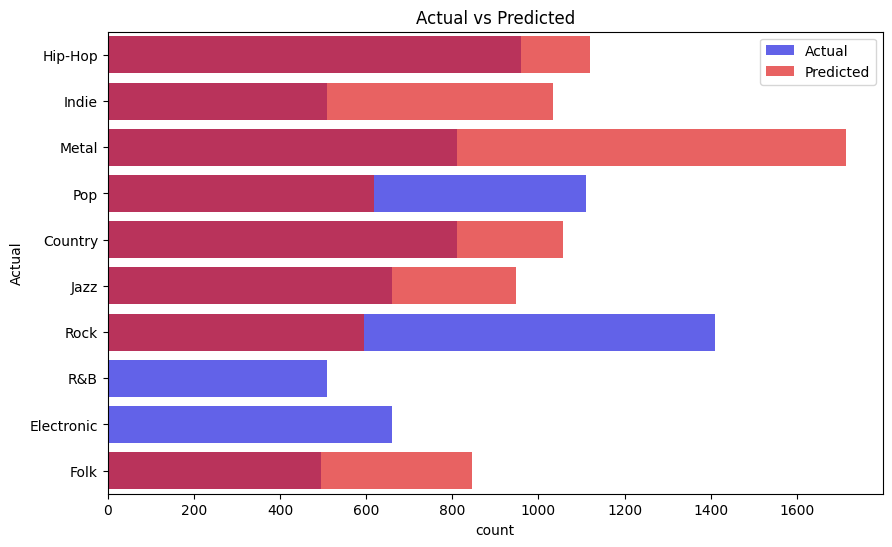

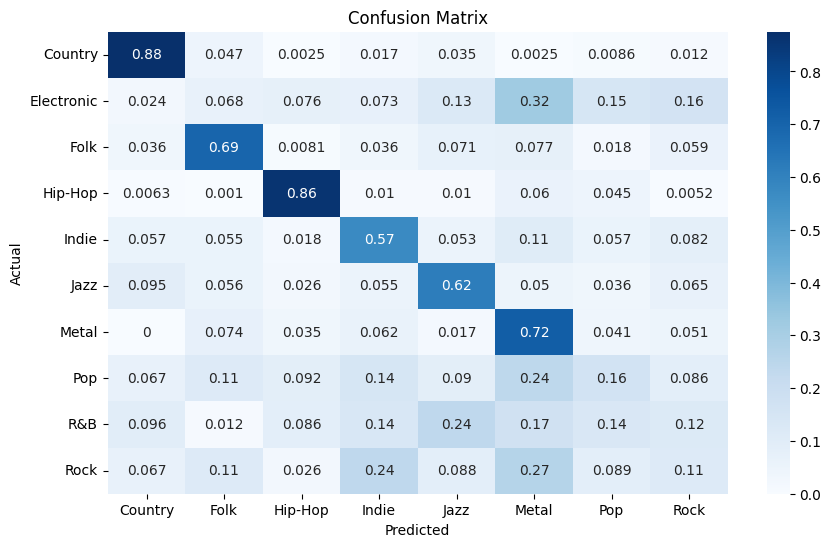

Artist information included
Training model with kernel size: 5
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 45s 92ms/step - accuracy: 0.1864 - loss: 2.0868 - val_accuracy: 0.0000e+00 - val_loss: 6.9292 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.6830 - loss: 0.9495 - val_accuracy: 0.0000e+00 - val_loss: 9.1761 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - accuracy: 0.8575 - loss: 0.4916 - val_accuracy: 0.0000e+00 - val_loss: 11.7881 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4415 - loss: 2.1217
Loss: 2.14302921295166
Accuracy: 0.44221803545951843
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
0.4422180214240706
              precision    recall  f1-score   support

     Country       0.75      0.86      0.80       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.53      0.62      0.57       495
     Hip-Hop       0.69      0.84      0.76       960
       Indie       0.38      0.49      0.43       510
        Jazz       0.29

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

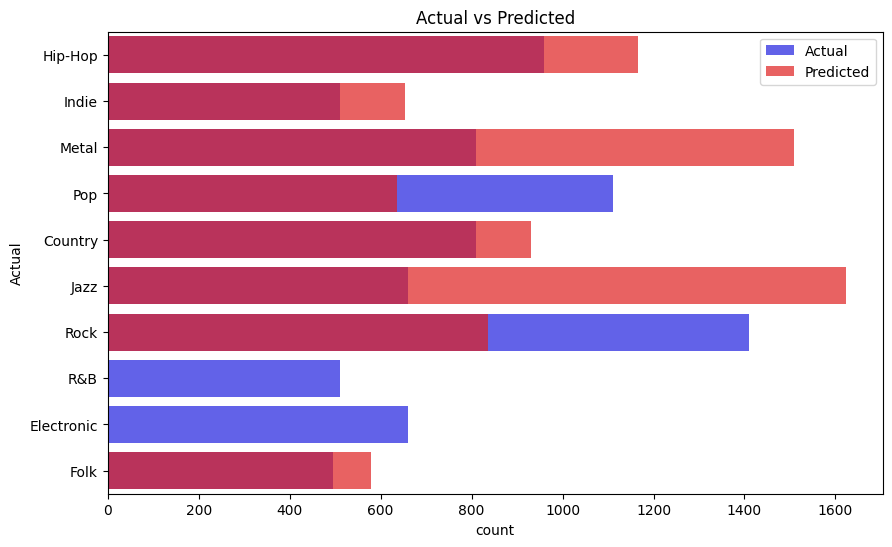

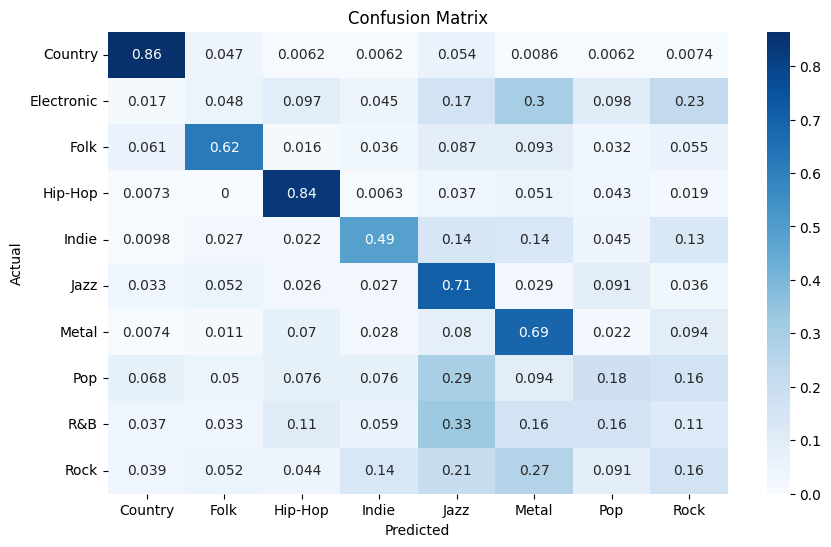

Artist information included
Training model with kernel size: 7
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.1585 - loss: 2.1315 - val_accuracy: 0.0000e+00 - val_loss: 6.3196 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 55s 116ms/step - accuracy: 0.6426 - loss: 1.0158 - val_accuracy: 0.0000e+00 - val_loss: 9.5223 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 55s 116ms/step - accuracy: 0.8386 - loss: 0.5257 - val_accuracy: 0.0000e+00 - val_loss: 10.7345 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.4253 - loss: 2.0631
Loss: 2.0767617225646973
Accuracy: 0.4221802055835724
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step
0.42218021424070573
              precision    recall  f1-score   support

     Country       0.52      0.88      0.65       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.60      0.55      0.57       495
     Hip-Hop       0.66      0.85      0.74       960
       Indie       0.39      0.54      0.45       510
        Jazz      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

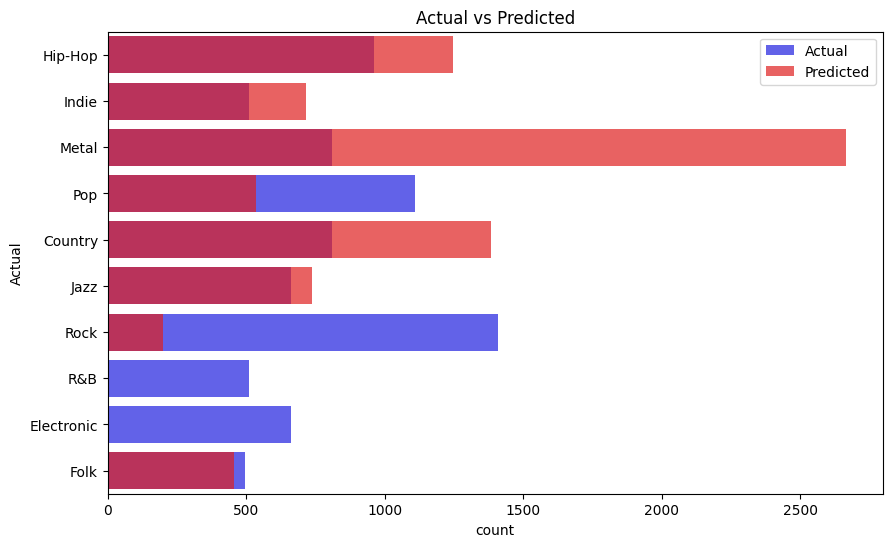

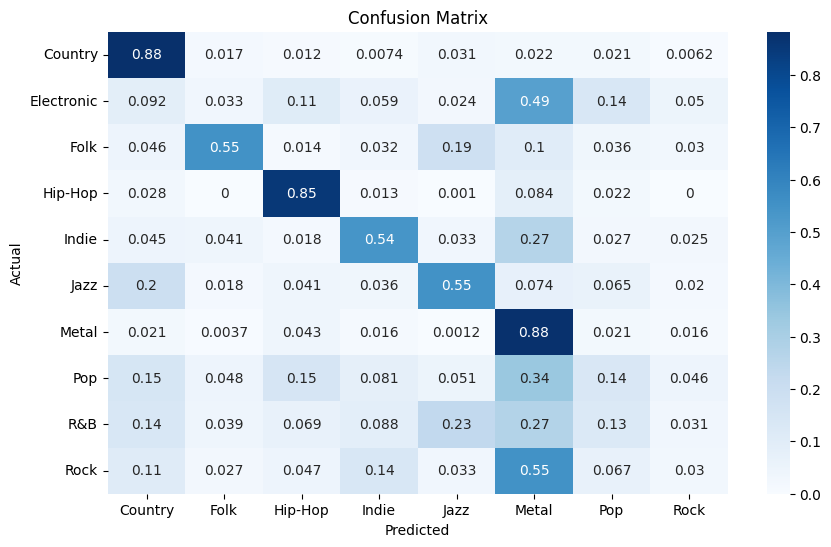

Artist information included
Training model with kernel size: 10
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 70s 146ms/step - accuracy: 0.1550 - loss: 2.1145 - val_accuracy: 0.0000e+00 - val_loss: 6.8898 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 70s 148ms/step - accuracy: 0.6446 - loss: 1.0264 - val_accuracy: 0.0000e+00 - val_loss: 9.3919 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 75s 158ms/step - accuracy: 0.8414 - loss: 0.5069 - val_accuracy: 0.0000e+00 - val_loss: 10.2117 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.3967 - loss: 2.2113
Loss: 2.223782777786255
Accuracy: 0.3978576064109802
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step
0.3978575929426591
              precision    recall  f1-score   support

     Country       0.75      0.88      0.81       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.37      0.59      0.45       495
     Hip-Hop       0.60      0.86      0.71       960
       Indie       0.30      0.43      0.36       510
        Jazz      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

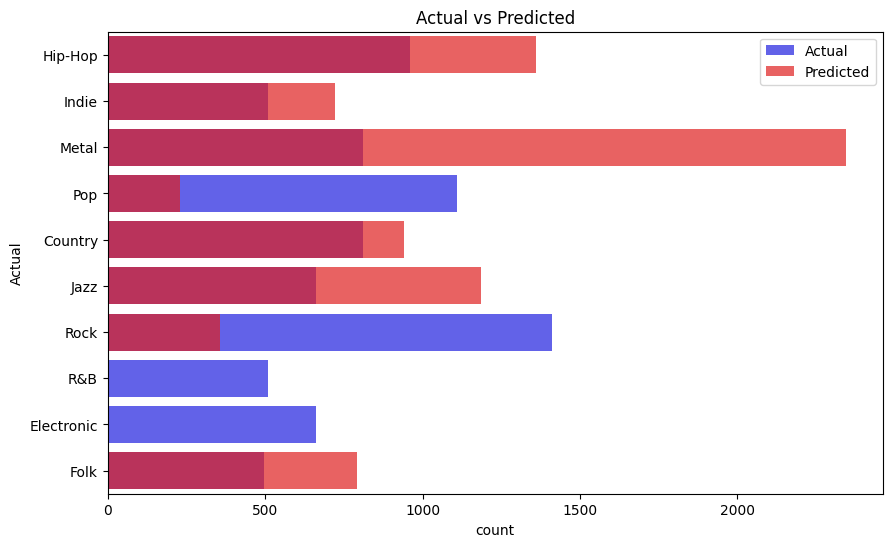

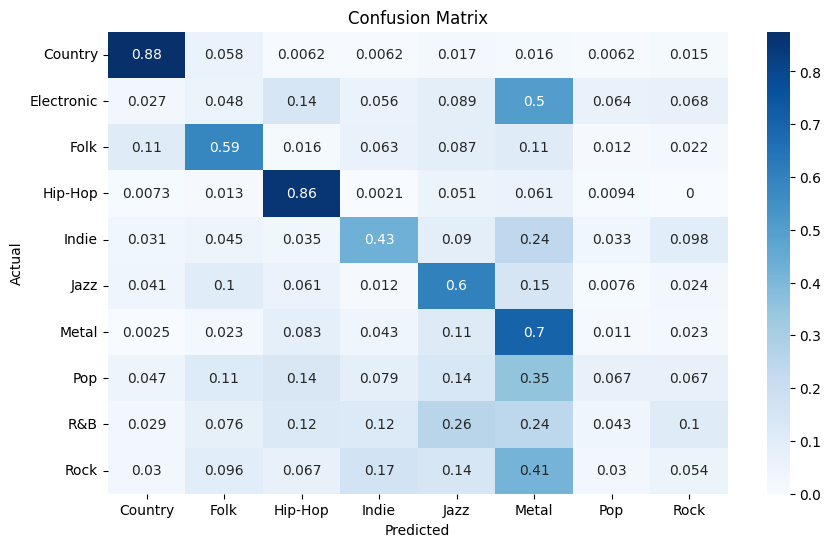

Artist information included
Training model with kernel size: 15
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 102s 214ms/step - accuracy: 0.1552 - loss: 2.1326 - val_accuracy: 0.0000e+00 - val_loss: 7.0602 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 100s 212ms/step - accuracy: 0.6493 - loss: 1.0251 - val_accuracy: 0.0000e+00 - val_loss: 8.5534 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 99s 210ms/step - accuracy: 0.8393 - loss: 0.5097 - val_accuracy: 0.0000e+00 - val_loss: 10.1530 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.4485 - loss: 2.1549
Loss: 2.17659330368042
Accuracy: 0.4439823627471924
248/248 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step
0.4439823566477631
              precision    recall  f1-score   support

     Country       0.74      0.83      0.78       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.47      0.67      0.55       495
     Hip-Hop       0.66      0.85      0.74       960
       Indie       0.32      0.47      0.38       510
        Jazz     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

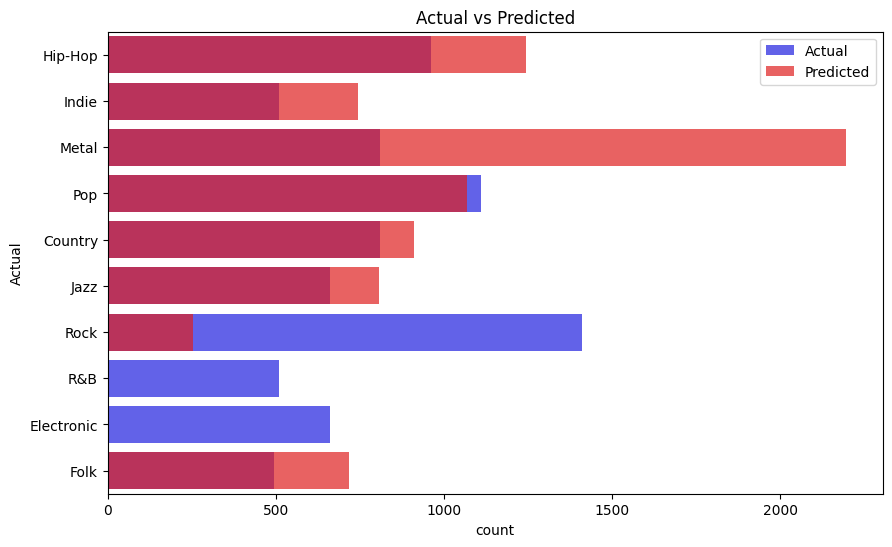

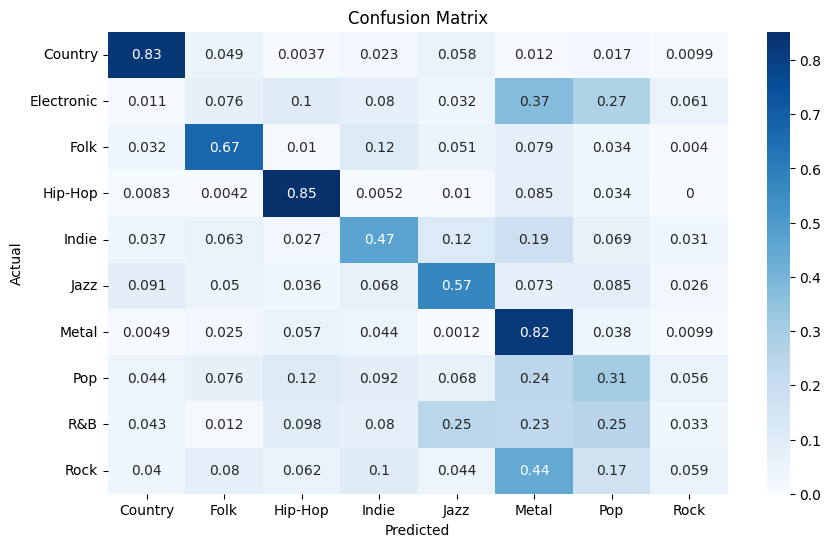

In [ ]:
# create a kernel size hyper param grid
kernel_sizes = [3, 5, 7, 10, 15]

# create a list to store the models
cnn_models = []

# loop through the kernel sizes
for kernel_size in kernel_sizes:
   
    # create the model with artist and lyrics
    model = create_cnn_model(
        input_dim=vocab_size_lyrics, 
        embedding_dim=EMBEDDING_DIM, 
        dense_units=UNITS, 
        dropout_rate=DROPOUT_RATE, 
        max_length=max_length_lyrics, 
        dense_activation=DENSE_ACTIVATION, 
        optimizer=OPTIMIZER, 
        max_length_artist=max_length_artist,
        artist_vocab_size=vocab_size_artist,
        kernel_size=kernel_size
    )
    print(f"Training model with kernel size: {kernel_size}")
    # train the model
    model_history = model.fit([X_train_lyrics, X_train_artist], y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, callbacks=callbacks)

    # plot the training results
    plot_training_results(model_history.history)
    plot_training_results(model_history.history, metric='loss')
    
    # evaluate the model
    evaluate_model(model, [X_test_lyrics, X_test_artist], y_test, le)

    # save the model with the kernel size in the filename
    model.save(f'models/combined_cnn_model_kernel_{kernel_size}.keras')


#### CNN & LSTM Combined
Finally, investigate the use of a CNN layer followed by an LSTM layer.

In [35]:
def create_cnn_lstm_model(input_dim,
                          embedding_dim,
                          dense_units,
                          dropout_rate,
                          max_length,
                          dense_activation='relu',
                          optimizer='adam',
                          max_length_artist=None,
                          artist_vocab_size=None,
                          kernel_size=5):
    # Create a list to store the inputs and features
    inputs_combined = []
    features = []
                
    # Create an embedding layer
    embedding = Embedding(input_dim, embedding_dim, input_length=max_length)
    inputs = Input(shape=(max_length,))  # Define the input layer

    # Create embedding layer
    input_embedding = embedding(inputs)  # Add the Embedding layer

    # CNN layer
    conv_layer = Conv1D(128, kernel_size, activation=dense_activation)(input_embedding)
    pooling_layer = MaxPooling1D(2)(conv_layer)

    # LSTM layer
    lstm_layer = LSTM(128, return_sequences=True)(pooling_layer)  # Add an LSTM layer with return sequences
    lstm_layer = LSTM(dense_units)(lstm_layer)  # Add another LSTM layer without return sequences

    # Dropout layer
    dense_layer = Dense(dense_units, activation=dense_activation)(lstm_layer)  # Add a Dense layer
    dropout_layer = Dropout(dropout_rate)(dense_layer)  # Add a Dropout layer
    features.append(dropout_layer)  # Add layers to the features list
    inputs_combined.append(inputs)  # Append the input layer to the inputs list

    # Conditionally include artist input if vocab size is provided
    if artist_vocab_size is not None:
        print("Artist information included")

        # Artist input
        artist_input = Input(shape=(max_length_artist,), name="Artist_Input")

        # Artist embedding
        artist_embedding = Embedding(artist_vocab_size, embedding_dim, input_length=max_length_artist)(artist_input)

        # CNN for artist
        artist_conv = Conv1D(filters=128, kernel_size=kernel_size, activation=dense_activation)(artist_embedding)
        artist_pool = MaxPooling1D(pool_size=2)(artist_conv)

        # LSTM for artist (ensure 3D input)
        artist_lstm = LSTM(dense_units, return_sequences=True)(artist_pool)
        artist_lstm = LSTM(dense_units)(artist_lstm)
        
        # Alternative pathway: Dense processing (ensure 2D input)
        artist_flat = GlobalMaxPooling1D()(artist_conv)
        artist_dense = Dense(dense_units, activation=dense_activation)(artist_flat)
        artist_dropout = Dropout(dropout_rate)(artist_dense)

        # Choose the pathway you want to include
        features.append(artist_dropout)  # or features.append(artist_lstm)
        inputs_combined.append(artist_input)

        # Combine features if both are present
        if len(features) > 1:
            combined = Concatenate()(features)
        else:
            combined = features[0]

    # Dense layers
    combined_dense = Dense(dense_units, activation=dense_activation)(combined)
    combined_dropout = Dropout(dropout_rate)(combined_dense)

    # Output layer
    output = Dense(OUTPUT_DIM, activation='softmax', name="Output")(combined_dropout)

    # Build and compile the model
    model = Model(inputs=inputs_combined, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Return the model
    return model

In [75]:
# create cnn lstm model with artist and lyrics
lstm_cnn_model = create_cnn_lstm_model(
    input_dim=vocab_size_lyrics, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=max_length_lyrics, 
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER, 
    max_length_artist=max_length_artist,
    artist_vocab_size=vocab_size_artist,
    kernel_size=3
)

# model summary
lstm_cnn_model.summary()

# train the model
lstm_cnn_model_history = lstm_cnn_model.fit([X_train_lyrics, X_train_artist], y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, callbacks=callbacks)

Artist information included


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 2009)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (None, 2009, 100) │  8,113,600 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 2007, 128) │     38,528 │ embedding_22[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Artist_Input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1003, 128) │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_23        │ (None, 7, 100)    │    542,500 │ Artist_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 1003, 128) │    131,584 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 5, 128)    │     38,528 │ embedding_23[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 64)        │     49,408 │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_14[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │      4,160 │ lstm_12[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 64)        │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 64)        │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 128)       │          0 │ dropout_41[0][0], │
│ (Concatenate)       │                   │            │ dropout_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 64)        │      8,256 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 64)        │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 10)        │        650 │ dropout_43[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,935,470 (34.09 MB)

 Trainable params: 8,935,470 (34.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 638s 1s/step - accuracy: 0.1980 - loss: 2.0463 - val_accuracy: 0.0000e+00 - val_loss: 7.3527 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.7600 - loss: 0.7738 - val_accuracy: 0.0000e+00 - val_loss: 9.2654 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 651s 1s/step - accuracy: 0.9116 - loss: 0.3517 - val_accuracy: 0.0000e+00 - val_loss: 10.6077 - learning_rate: 0.0010


###### Results

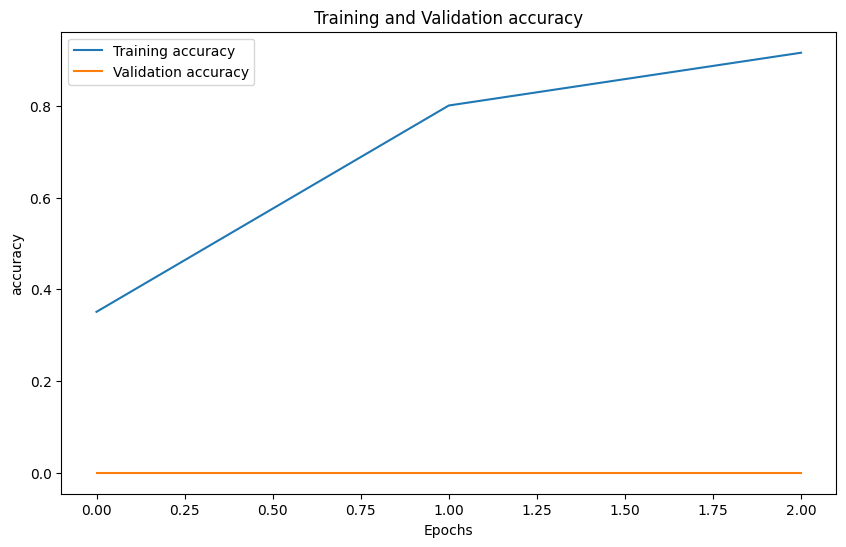

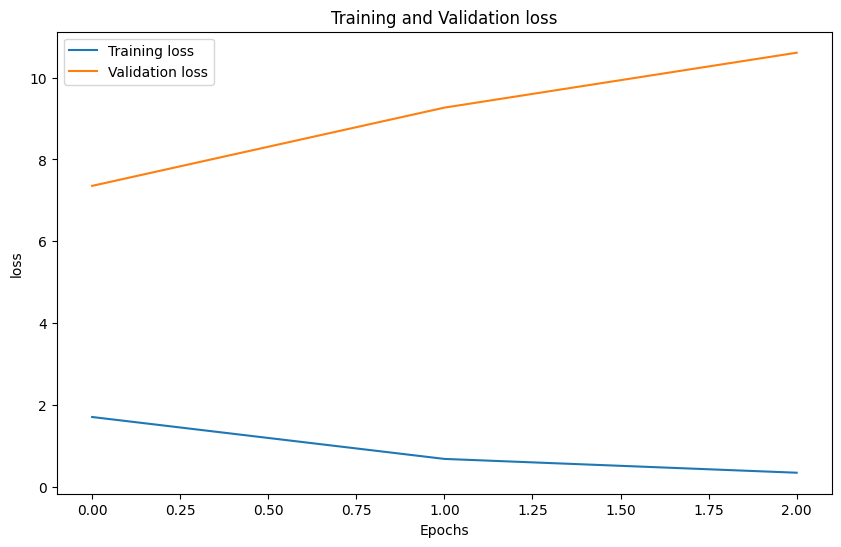

248/248 ━━━━━━━━━━━━━━━━━━━━ 68s 275ms/step - accuracy: 0.4906 - loss: 2.2577
Loss: 2.263538122177124
Accuracy: 0.4829237461090088
248/248 ━━━━━━━━━━━━━━━━━━━━ 71s 287ms/step
0.48292375551354755
              precision    recall  f1-score   support

     Country       0.81      0.88      0.85       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.59      0.71      0.65       495
     Hip-Hop       0.70      0.75      0.72       960
       Indie       0.39      0.58      0.47       510
        Jazz       0.66      0.68      0.67       660
       Metal       0.44      0.38      0.41       810
         Pop       0.24      0.38      0.29      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.38      0.40      0.39      1410

    accuracy                           0.48      7935
   macro avg       0.42      0.48      0.44      7935
weighted avg       0.43      0.48      0.45      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

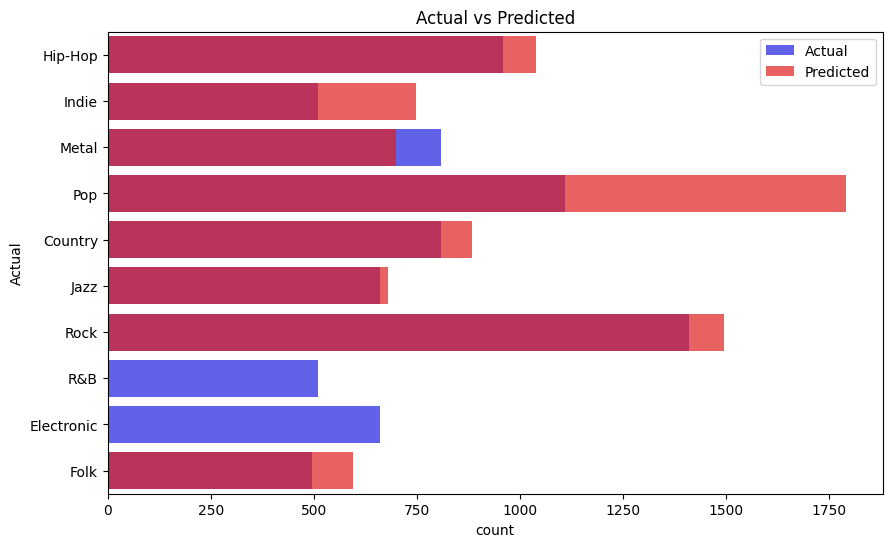

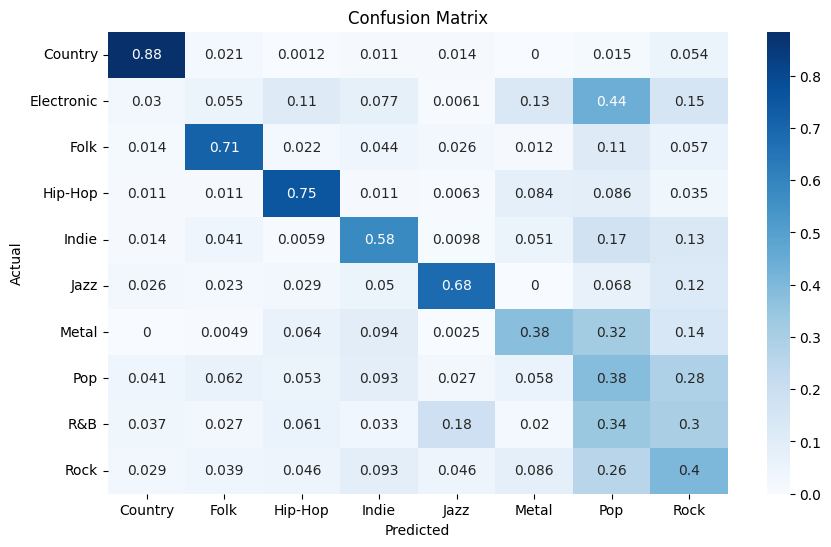

In [106]:
# plot the training results
plot_training_results(lstm_cnn_model_history.history)
plot_training_results(lstm_cnn_model_history.history, metric='loss')

# evaluate the model
evaluate_model(lstm_cnn_model, [X_test_lyrics, X_test_artist], y_test, le)

# save the model
lstm_cnn_model.save('models/lstm_cnn_model.keras')

# save the history
lstm_cnn_model_history_df = pd.DataFrame(lstm_cnn_model_history.history)

# save the history to a csv file
lstm_cnn_model_history_df.to_csv('results/lstm_cnn_model_history.csv', index=False)

### Hyper Parameter Tuning

In [ ]:
common_param_grid = {
    'dense_units': [64, 128],               # Number of units in dense layer
    'activation': ['relu', 'tanh'],         # Activation function for dense layer
    'dropout_rate': [0.0, 0.2],             # Dropout rate to prevent overfitting
    'optimizer': [
        Adam(learning_rate=0.001), 
        SGD(learning_rate=0.001)
    ],                                       # Optimizer with different learning rates
    'batch_size': [32, 64, 128],             # Batch size for training
    'epochs': [15],                          # Maximum epochs, early stopping will likely end sooner
}

# Define the model type parameters
rnn_model_type_param = {'model_type': ['RNN']}
lstm_single_model_type_param = {'model_type': ['LSTM_SINGLE']}
lstm_multi_model_type_param = {'model_type': ['LSTM_MULTI']}
lstm_pretrained_model_type_param = {'model_type': ['LSTM_PRETRAINED']}
cnn_model_type_param = {'model_type': ['CNN']}
lstm_cnn_model_type_param = {'model_type': ['LSTM_CNN']}

# Combine the common parameters with the model type parameters
rnn_param_grid = {**common_param_grid, **rnn_model_type_param}
lstm_single_param_grid = {**common_param_grid, **lstm_single_model_type_param}
lstm_multi_param_grid = {**common_param_grid, **lstm_multi_model_type_param}
lstm_pretrained_param_grid = {**common_param_grid, **lstm_pretrained_model_type_param}
cnn_param_grid = {**common_param_grid, **cnn_model_type_param}
lstm_cnn_grid = {**common_param_grid, **lstm_cnn_model_type_param}


rnn_param_grid = list(ParameterGrid(rnn_param_grid))
lstm_single_param_grid = list(ParameterGrid(lstm_single_param_grid))
lstm_multi_param_grid = list(ParameterGrid(lstm_multi_param_grid))
lstm_pretrained_param_grid = list(ParameterGrid(lstm_pretrained_param_grid))
cnn_param_grid = list(ParameterGrid(cnn_param_grid))
lstm_cnn_grid = list(ParameterGrid(lstm_cnn_grid))

# print the number of combinations for each model type
print(f'RNN: {len(rnn_param_grid)}')
print(f'LSTM SINGLE: {len(lstm_single_param_grid)}')
print(f'LSTM MULTI: {len(lstm_multi_param_grid)}')
print(f'LSTM PRETRAINED: {len(lstm_pretrained_param_grid)}')
print(f'CNN: {len(cnn_param_grid)}')
print(f'LSTM CNN: {len(lstm_cnn_grid)}')


RNN: 48
LSTM SINGLE: 48
LSTM MULTI: 48
LSTM PRETRAINED: 48
CNN: 48
LSTM CNN: 48


In [112]:
import time
# Hyperparameter Tuning Function
def tune_hyperparameters(X_train, 
                         y_train, 
                         X_test, 
                         y_test, 
                         param_grid_combinations,
                         vocab_size_lyrics=vocab_size_lyrics, 
                         max_length_lyrics=max_length_lyrics, 
                         optimizer=OPTIMIZER, 
                         max_length_artist=max_length_artist, 
                         vocab_size_artist=vocab_size_artist):
    results = []
    for params in param_grid_combinations:
        print(f"Training model with parameters: {params}")

        # Recreate optimizer instance
        optimizer = params['optimizer'].__class__(**params['optimizer'].get_config())

        # create a map of model types to model creation functions
        model_creation_functions = {
            'RNN': create_rnn_model,
            'LSTM_SINGLE': create_single_lstm_model,
            'LSTM_MULTI': create_multi_lstm_model,
            'CNN': create_cnn_model,
            'LSTM_CNN': create_cnn_lstm_model
        }

        # Create model
        model = model_creation_functions[params['model_type']](
            input_dim=vocab_size_lyrics, 
            embedding_dim=EMBEDDING_DIM, 
            dense_units=params['dense_units'], 
            dropout_rate=params['dropout_rate'], 
            max_length=max_length_lyrics, 
            dense_activation=params['activation'], 
            optimizer=optimizer,
            max_length_artist=max_length_artist,
            artist_vocab_size=vocab_size_artist
        )

        # Train model
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            callbacks=callbacks,
            verbose=1
        )
        end_time = time.time()

        # Evaluate model
        loss, accuracy = model.evaluate(X_test, y_test)

        # Save results
        results.append({
            'params': params,
            'loss': loss,
            'accuracy': accuracy,
            'time': end_time - start_time,
            'trained_model': model,
            'history': history
        })

    return pd.DataFrame(results).sort_values(by='accuracy', ascending=False)

#### RNN Hyperparameter Tuning

In [136]:
# Tune RNN hyperparameters
tuned_rnn_results_df = tune_hyperparameters([X_train_lyrics, X_train_artist], y_train, [X_test_lyrics, X_test_artist], y_test, rnn_param_grid)

Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'RNN', 'optimizer': <keras.src.optimizers.adam.Adam object at 0x3c3da4530>}
Artist information included
Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 130s 272ms/step - accuracy: 0.4824 - loss: 1.4575 - val_accuracy: 0.0000e+00 - val_loss: 9.0567 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 129s 274ms/step - accuracy: 0.9370 - loss: 0.2165 - val_accuracy: 0.0000e+00 - val_loss: 10.1096 - learning_rate: 0.0010
Epoch 3/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 130s 276ms/step - accuracy: 0.9643 - loss: 0.1113 - val_accuracy: 0.0000e+00 - val_loss: 10.5886 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.5273 - loss: 2.3735
Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'RNN', 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x404991130>}
Artist information included
Epoch 1/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 128s 270ms/step - accuracy: 0.1129 - loss: 2.2801 - val_accuracy: 0.0000e+00 - val_loss: 2.7095 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 127s 269m

##### Results

In [ ]:
# best rnn model
best_rnn_model = tuned_rnn_results_df['trained_model'].values[0]

best_rnn_model.summary()

# save the best rnn model
# save the tuned_results_df
tuned_rnn_results_df.to_csv('results/tuned_cnn_results_df.csv', index=False)
best_rnn_model.save('models/best_rnn_model.keras')

Model: "functional_302"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Lyrics_Input        │ (None, 2009)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Artist_Input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_598       │ (None, 2009, 100) │  8,113,600 │ Lyrics_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_599       │ (None, 7, 100)    │    542,500 │ Artist_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_77       │ (None, 128)       │     29,312 │ embedding_598[0]… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_78       │ (None, 128)       │     29,312 │ embedding_599[0]… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_946         │ (None, 128)       │          0 │ simple_rnn_77[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_947         │ (None, 128)       │          0 │ simple_rnn_78[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_298     │ (None, 256)       │          0 │ dropout_946[0][0… │
│ (Concatenate)       │                   │            │ dropout_947[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_715 (Dense)   │ (None, 128)       │     32,896 │ concatenate_298[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_948         │ (None, 128)       │          0 │ dense_715[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 10)        │      1,290 │ dropout_948[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,246,732 (100.12 MB)

 Trainable params: 8,748,910 (33.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,497,822 (66.75 MB)

248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.5556 - loss: 1.8693
Loss: 1.9061477184295654
Accuracy: 0.5489603281021118
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step
              precision    recall  f1-score   support

     Country       0.85      0.93      0.89       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.62      0.78      0.69       495
     Hip-Hop       0.71      0.87      0.78       960
       Indie       0.51      0.73      0.60       510
        Jazz       0.56      0.72      0.63       660
       Metal       0.39      0.83      0.53       810
         Pop       0.40      0.34      0.37      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.48      0.34      0.40      1410

    accuracy                           0.55      7935
   macro avg       0.45      0.55      0.49      7935
weighted avg       0.47      0.55      0.50      7935

[[750   0  24   0   6  10   6   9   0   5]
 [ 15   0  27  84  77  4

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

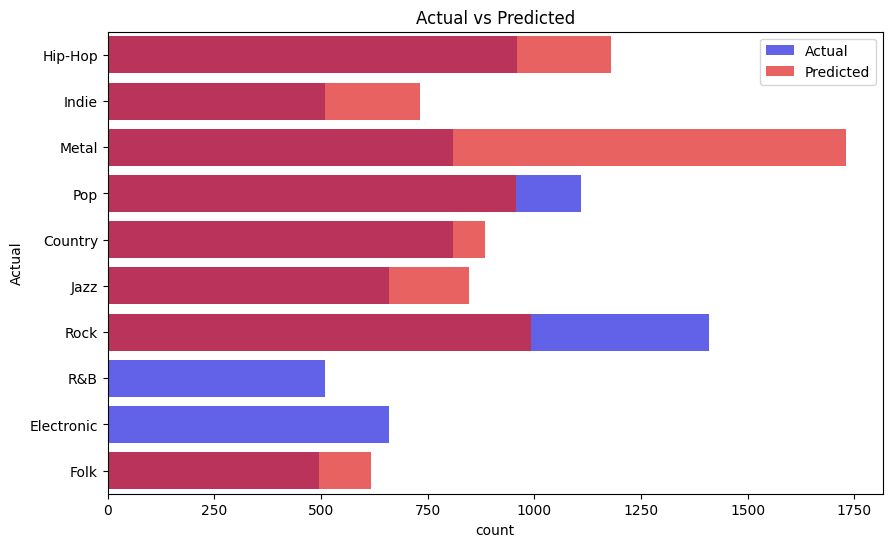

In [60]:
# evaluate the best rnn model
# evaluate the model
evaluate_model(best_rnn_model, [X_test_lyrics, X_test_artist], y_test, le)

#### CNN Hyperparameter Tuning

In [ ]:
# Tune CNN hyperparameters
tuned_cnn_results_df = tune_hyperparameters([X_train_lyrics, X_train_artist], y_train, [X_test_lyrics, X_test_artist], y_test, cnn_param_grid)

##### Results

In [ ]:
from tensorflow.keras.models import load_model
# best cnn model from disk if it's already been trained if not take it from the results
if os.path.exists('models/best_cnn_model.keras'):
    best_cnn_model = load_model('models/best_cnn_model.keras')
else:   
    best_cnn_model = tuned_cnn_results_df['trained_model'].values[0]

# get the results from disk if it's already been trained if not take it from the results
if os.path.exists('results/tuned_cnn_results_df.csv'):
    tuned_cnn_results_df = pd.read_csv('results/tuned_cnn_results_df.csv')
else:
    tuned_cnn_results_df = tuned_cnn_results_df

# print the model parameters
best_cnn_model.summary()

# save the best cnn model
tuned_cnn_results_df.to_csv('results/tuned_cnn_results_df.csv', index=False)

# evaluate the best model
evaluate_model(best_cnn_model, [X_test_lyrics, X_test_artist], y_test, le)

Model: "functional_93"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Artist_Input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_35      │ (None, 2009)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_183       │ (None, 7, 100)    │    542,400 │ Artist_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_182       │ (None, 2009, 100) │  8,113,500 │ input_layer_35[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_308         │ (None, 7, 100)    │          0 │ embedding_183[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 2005, 128) │     64,128 │ embedding_182[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 3, 128)    │     64,128 │ dropout_308[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_69[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_70[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_164 (Dense)   │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_165 (Dense)   │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_307         │ (None, 64)        │          0 │ dense_164[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_309         │ (None, 64)        │          0 │ dense_165[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_89      │ (None, 128)       │          0 │ dropout_307[0][0… │
│ (Concatenate)       │                   │            │ dropout_309[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_166 (Dense)   │ (None, 64)        │      8,256 │ concatenate_89[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_310         │ (None, 64)        │          0 │ dense_166[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 10)        │        650 │ dropout_310[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,428,724 (100.82 MB)

 Trainable params: 8,809,574 (33.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,619,150 (67.21 MB)

NameError: name 'tuned_cnn_results_df' is not defined

In [ ]:

# save the best model
# save the tuned_results_df
tuned_cnn_results_df.to_csv('results/tuned_cnn_results_df.csv', index=False)
best_cnn_model.save('models/best_cnn_model.keras')

#### Single Layer LSTM Hyperparameter Tuning

Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'LSTM_SINGLE', 'optimizer': <keras.src.optimizers.adam.Adam object at 0x3f97985c0>}
Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 316s 664ms/step - accuracy: 0.2842 - loss: 1.8188 - val_accuracy: 0.0000e+00 - val_loss: 10.9199 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 317s 670ms/step - accuracy: 0.8503 - loss: 0.5174 - val_accuracy: 0.0000e+00 - val_loss: 12.2867 - learning_rate: 0.0010
Epoch 3/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 317s 671ms/step - accuracy: 0.9283 - loss: 0.2677 - val_accuracy: 0.0000e+00 - val_loss: 14.1376 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - accuracy: 0.4935 - loss: 2.7271
Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'LSTM_SINGLE', 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x44a6eac90>}
Epoch 1/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 294s 617ms/step - accuracy: 0.0975 - loss: 2.2950 - val_accuracy: 0.0000e+00 - val_loss: 2.4381 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 304s 642ms/step - accuracy:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

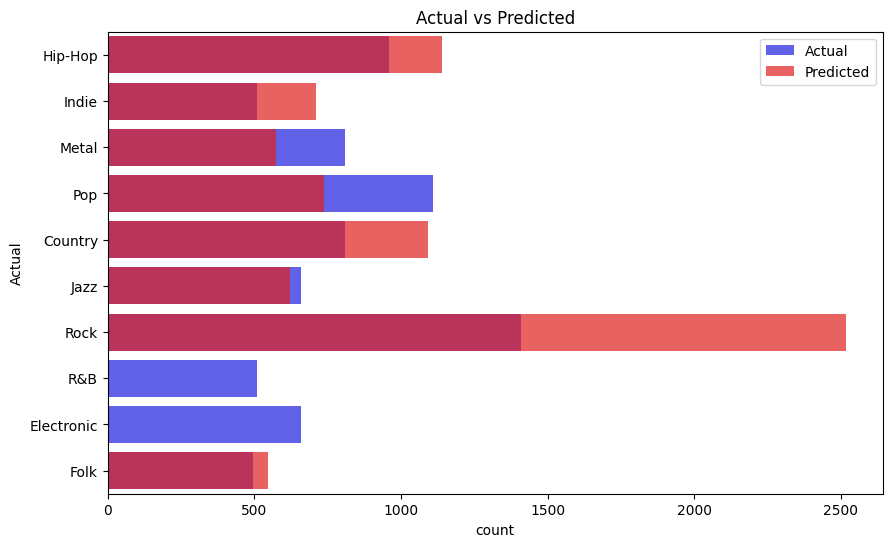

In [ ]:
# Tune LSTM hyperparameters
tuned_single_layer_lstm_results_df = tune_hyperparameters([X_train_lyrics, X_train_artist], y_train, [X_test_lyrics, X_test_artist], y_test, lstm_single_param_grid)

##### Results

In [ ]:
# best lstm model
best_sinlge_lstm_model = tuned_single_layer_lstm_results_df['trained_model'].values[0]

# evaluate the best model
evaluate_model(best_sinlge_lstm_model, [X_test_lyrics, X_test_artist], y_test, le)

# save the best model
# save the tuned_results_df
tuned_single_layer_lstm_results_df.to_csv('results/tuned_multi_layer_lstm_results_df.csv', index=False)
best_sinlge_lstm_model.save('models/best_lstm_model.keras')

#### Multi-Layer LSTM Hyperparameter Tuning

Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'LSTM_MULTI', 'optimizer': <keras.src.optimizers.adam.Adam object at 0x3f97985c0>}
Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - accuracy: 0.2253 - loss: 1.8985 - val_accuracy: 0.0000e+00 - val_loss: 12.3284 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - accuracy: 0.8122 - loss: 0.6040 - val_accuracy: 0.0000e+00 - val_loss: 11.8300 - learning_rate: 0.0010
Epoch 3/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 1531s 3s/step - accuracy: 0.9254 - loss: 0.2501 - val_accuracy: 0.0000e+00 - val_loss: 13.8087 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.4693 - loss: 2.9769
Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'LSTM_MULTI', 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x44a6eac90>}
Epoch 1/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 1743s 4s/step - accuracy: 0.1239 - loss: 2.2951 - val_accuracy: 0.0000e+00 - val_loss: 2.4245 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.1312 - loss

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

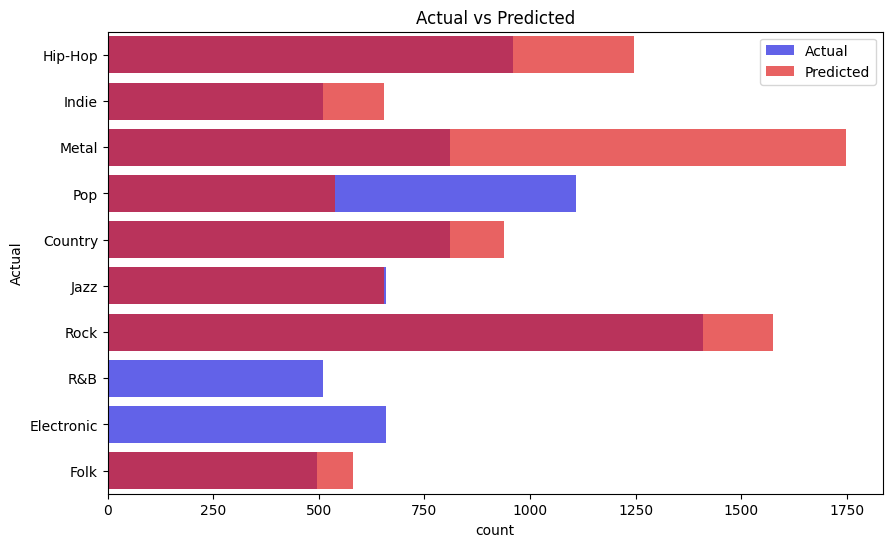

In [ ]:
# Tune LSTM hyperparameters
tuned_multi_layer_lstm_results_df = tune_hyperparameters([X_train_lyrics, X_train_artist], y_train, [X_test_lyrics, X_test_artist], y_test, lstm_multi_param_grid)

##### Results

In [ ]:
# best lstm model
best_multi_lstm_model = tuned_multi_layer_lstm_results_df['trained_model'].values[0]

# evaluate the best model
evaluate_model(best_multi_lstm_model, [X_test_lyrics, X_test_artist], y_test, le)

# save the best model
# save the tuned_results_df
tuned_multi_layer_lstm_results_df.to_csv('results/tuned_multi_layer_lstm_results_df.csv', index=False)
best_multi_lstm_model.save('models/best_lstm_model.keras')

#### LSTM CNN Combined Hyperparameter Tuning

In [113]:
# lstm cnn model
tuned_lstm_cnn_results_df = tune_hyperparameters([X_train_lyrics, X_train_artist], y_train, [X_test_lyrics, X_test_artist], y_test, lstm_cnn_grid)

# best lstm cnn model
best_lstm_cnn_model = tuned_lstm_cnn_results_df['trained_model'].values[0]

Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'LSTM_CNN', 'optimizer': <keras.src.optimizers.adam.Adam object at 0x407462900>}
Artist information included
Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.3424 - loss: 1.7179 - val_accuracy: 0.0000e+00 - val_loss: 11.0976 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 632s 1s/step - accuracy: 0.9117 - loss: 0.3124 - val_accuracy: 0.0000e+00 - val_loss: 12.0329 - learning_rate: 0.0010
Epoch 3/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 605s 1s/step - accuracy: 0.9665 - loss: 0.1152 - val_accuracy: 0.0000e+00 - val_loss: 12.6497 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 331ms/step - accuracy: 0.5098 - loss: 2.7237
Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'LSTM_CNN', 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x3f53a8530>}
Artist information included
Epoch 1/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 636s 1s/step - accuracy: 0.1220 - loss: 2.2971 - val_accuracy: 0.0000e+00 - val_loss: 2.3997 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 673s 1s/step -

##### Results

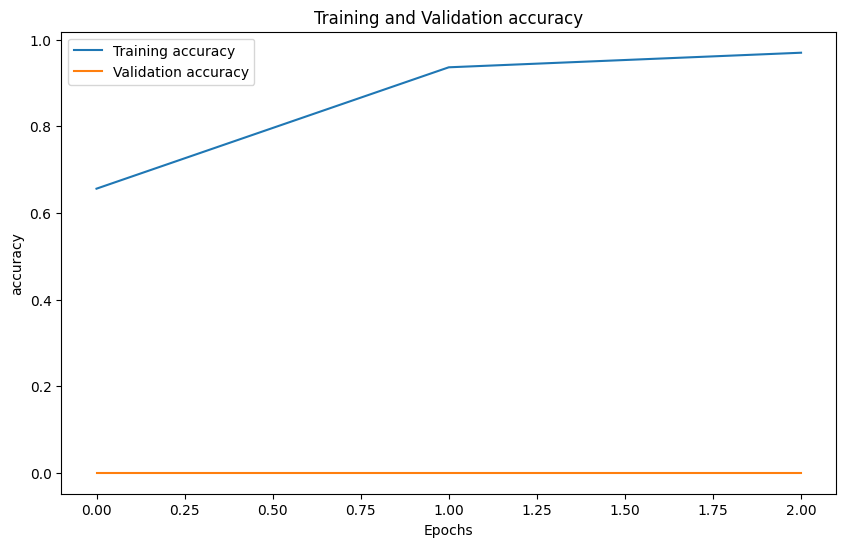

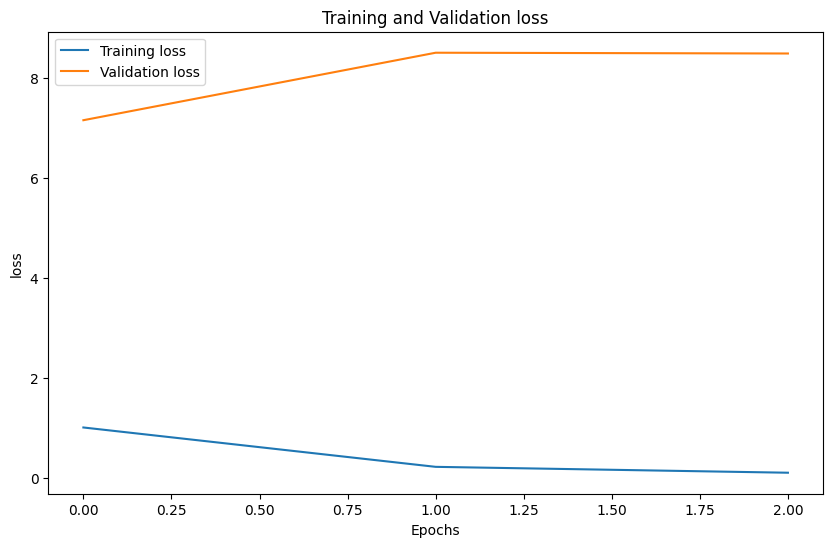

248/248 ━━━━━━━━━━━━━━━━━━━━ 211s 854ms/step - accuracy: 0.5738 - loss: 1.9824
Loss: 2.0092570781707764
Accuracy: 0.5674858093261719
248/248 ━━━━━━━━━━━━━━━━━━━━ 245s 990ms/step
0.5674858223062382
              precision    recall  f1-score   support

     Country       0.82      0.93      0.87       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.67      0.81      0.74       495
     Hip-Hop       0.82      0.88      0.85       960
       Indie       0.66      0.73      0.69       510
        Jazz       0.73      0.74      0.73       660
       Metal       0.46      0.78      0.58       810
         Pop       0.33      0.32      0.33      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.39      0.47      0.42      1410

    accuracy                           0.57      7935
   macro avg       0.49      0.57      0.52      7935
weighted avg       0.49      0.57      0.52      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

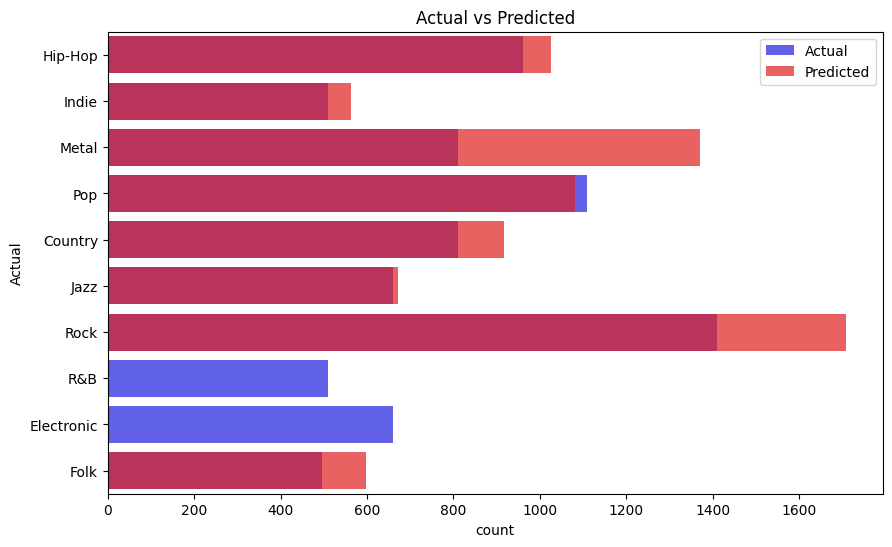

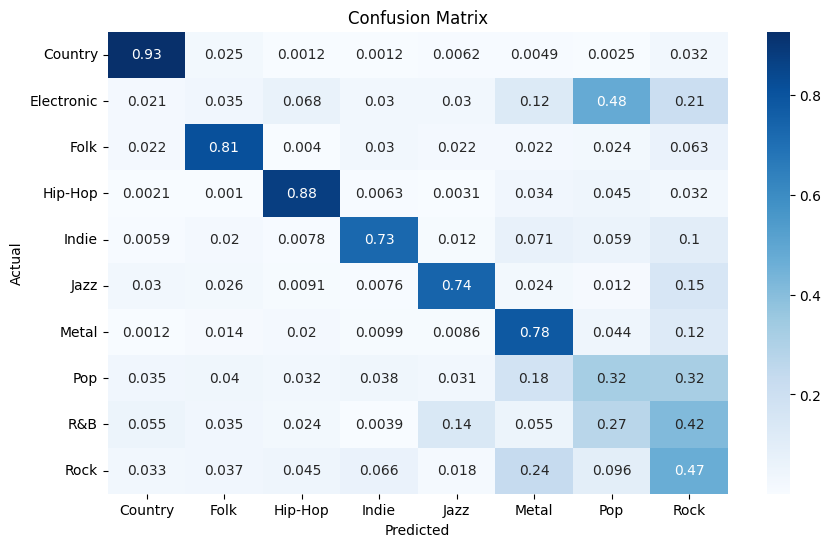

In [116]:
# get the history from the best model
best_lstm_cnn_model_history = tuned_lstm_cnn_results_df['history'].values[0]

# plot the training results
plot_training_results(best_lstm_cnn_model_history.history)
plot_training_results(best_lstm_cnn_model_history.history, metric='loss')

# evaluate the best model
evaluate_model(best_lstm_cnn_model, [X_test_lyrics, X_test_artist], y_test, le)

# save the best model
# save the tuned_results_df
# tuned_lstm_cnn_results_df.to_csv('results/tuned_lstm_cnn_results_df.csv', index=False)
best_lstm_cnn_model.save('models/best_lstm_cnn_model.keras')

In [117]:
tuned_lstm_cnn_results_df.to_csv('results/tuned_lstm_cnn_results_df.csv', index=False)
print(tuned_lstm_cnn_results_df['params'][0])

{'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'LSTM_CNN', 'optimizer': <keras.src.optimizers.adam.Adam object at 0x407462900>}


In [ ]:
# load the best_lstm_cnn_model from disk
best_lstm_cnn_model = load_model('models/best_lstm_cnn_model.keras')
best_lstm_cnn_model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 2009)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_70        │ (None, 2009, 100) │  8,113,600 │ input_layer_36[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 2005, 128) │     64,128 │ embedding_70[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Artist_Input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_66    │ (None, 1002, 128) │          0 │ conv1d_69[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_71        │ (None, 7, 100)    │    542,500 │ Artist_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_136 (LSTM)     │ (None, 1002, 128) │    131,584 │ max_pooling1d_66… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 3, 128)    │     64,128 │ embedding_71[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_137 (LSTM)     │ (None, 128)       │    131,584 │ lstm_136[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_70[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 128)       │     16,512 │ lstm_137[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_97 (Dense)    │ (None, 128)       │     16,512 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_96          │ (None, 128)       │          0 │ dense_96[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_97          │ (None, 128)       │          0 │ dense_97[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 256)       │          0 │ dropout_96[0][0], │
│ (Concatenate)       │                   │            │ dropout_97[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_98 (Dense)    │ (None, 128)       │     32,896 │ concatenate_31[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_98          │ (None, 128)       │          0 │ dense_98[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 10)        │      1,290 │ dropout_98[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,344,204 (104.31 MB)

 Trainable params: 9,114,734 (34.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,229,470 (69.54 MB)

### Model Saving
From the various models above, save the two top performing models. Your demo code should be
able to load these saved models and demonstrate performance.

In [118]:
# save the history
best_lstm_cnn_model_history_df = pd.DataFrame(best_lstm_cnn_model_history.history)

# save the history to a csv file
best_lstm_cnn_model_history_df.to_csv('results/best_lstm_cnn_model_history.csv', index=False)

In [ ]:
# save the rf_model
joblib.dump(rf_model, 'models/rf_model.pkl')

# save the le
import pickle
with open('models/le.pkl', 'wb') as f:
    pickle.dump(le, f)

# save the tokenizer
with open('models/lyrics_tokenizer.pkl', 'wb') as f:
    pickle.dump(lyrics_tokenizer, f)

# save the artist tokenizer
with open('models/artist_tokenizer.pkl', 'wb') as f:
    pickle.dump(artist_tokenizer, f)

# save the downsampled data
train_downsampled.to_csv('data/train_downsampled.csv', index=False)
test.to_csv('data/test.csv', index=False)


### Word2Vec Encoding Exploration

In [ ]:
def prepare_data_word2vec(train, test, embedding_dim=EMBEDDING_DIM):
    """
    Prepare the data using Word2Vec embeddings for lyrics and artist features.
    
    Parameters:
        train (pd.DataFrame): Training data with 'Lyrics' and 'Artist'.
        test (pd.DataFrame): Testing data with 'Lyrics' and 'Artist'.
        embedding_dim (int): Dimension of Word2Vec embeddings.
    
    Returns:
        x_train, x_test, y_train, y_test, vocab_size_lyrics, vocab_size_artist, le
    """
    # Encode the target variable
    le = LabelEncoder()
    y_train = to_categorical(le.fit_transform(train['Genre'])) 
    y_test = to_categorical(le.transform(test['Genre']))
    
    # Word2Vec for lyrics
    lyrics_sentences = [text.split() for text in train['Lyrics']]
    word2vec_lyrics = Word2Vec(lyrics_sentences, vector_size=embedding_dim, window=8, min_count=1, workers=4)
    
    x_train_lyrics = np.array([np.mean([word2vec_lyrics.wv[word] for word in text.split() if word in word2vec_lyrics.wv] or [np.zeros(embedding_dim)], axis=0) for text in train['Lyrics']])
    x_test_lyrics = np.array([np.mean([word2vec_lyrics.wv[word] for word in text.split() if word in word2vec_lyrics.wv] or [np.zeros(embedding_dim)], axis=0) for text in test['Lyrics']])
    
    # Word2Vec for artist
    artist_sentences = [text.split() for text in train['Artist']]
    word2vec_artist = Word2Vec(artist_sentences, vector_size=embedding_dim, window=10, min_count=1, workers=4)
    
    x_train_artist = np.array([np.mean([word2vec_artist.wv[word] for word in text.split() if word in word2vec_artist.wv] or [np.zeros(embedding_dim)], axis=0) for text in train['Artist']])
    x_test_artist = np.array([np.mean([word2vec_artist.wv[word] for word in text.split() if word in word2vec_artist.wv] or [np.zeros(embedding_dim)], axis=0) for text in test['Artist']])
    
    # Combine lyrics and artist features
    x_train = np.concatenate([x_train_lyrics, x_train_artist], axis=1)
    x_test = np.concatenate([x_test_lyrics, x_test_artist], axis=1)
    
    vocab_size_lyrics = len(word2vec_lyrics.wv)
    vocab_size_artist = len(word2vec_artist.wv)
    
    return x_train, x_test, y_train, y_test, vocab_size_lyrics, vocab_size_artist, le

In [65]:
# Prepare the data using Word2Vec embeddings
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec, vocab_size_lyrics_word2vec, vocab_size_artist_word2vec, le_word2vec = prepare_data_word2vec(train_downsampled, test, embedding_dim=EMBEDDING_DIM)

# Split the lyrics and artist features
X_train_lyrics_word2vec = X_train_word2vec[:, :EMBEDDING_DIM]
X_train_artist_word2vec = X_train_word2vec[:, EMBEDDING_DIM:]

X_test_lyrics_word2vec = X_test_word2vec[:, :EMBEDDING_DIM]
X_test_artist_word2vec = X_test_word2vec[:, EMBEDDING_DIM:]

print("Shape of X_train_lyrics_word2vec:", X_train_lyrics_word2vec.shape)
print("Shape of X_train_artist_word2vec:", X_train_artist_word2vec.shape)
print("Shape of X_test_lyrics_word2vec:", X_test_lyrics_word2vec.shape)
print("Shape of X_test_artist_word2vec:", X_test_artist_word2vec.shape)
print("Vocab size lyrics:", vocab_size_lyrics_word2vec)
print("Vocab size artist:", vocab_size_artist_word2vec)

Shape of X_train_lyrics_word2vec: (18900, 100)
Shape of X_train_artist_word2vec: (18900, 100)
Shape of X_test_lyrics_word2vec: (7935, 100)
Shape of X_test_artist_word2vec: (7935, 100)
Vocab size lyrics: 82591
Vocab size artist: 5508


In [66]:
# create a evaluation function for the word2vec model
def evaluate_model_word2vec(model, X_test_lyrics, X_test_artist, y_test, le):
    """
    Evaluate the model using the test data and label encoder.
    
    Parameters:
        model (keras.Model): The trained model to evaluate.
        X_test_lyrics (ndarray): The test data for the lyrics.
        X_test_artist (ndarray): The test data for the artist.
        y_test (ndarray): The test labels.
        le (LabelEncoder): The label encoder for the labels.
    """
    # Evaluate the model
    loss, accuracy = model.evaluate([X_test_lyrics, X_test_artist], y_test)
    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Test Loss: {loss:.3f}")
    
    # Make predictions
    y_pred = model.predict([X_test_lyrics, X_test_artist])
    y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
    y_test_labels = le.inverse_transform(np.argmax(y_test, axis=1))
    
    # Print classification report
    print(classification_report(y_test_labels, y_pred_labels))

    # create a results df
    results_df = pd.DataFrame({
        'Actual': y_test_labels,
        'Predicted': y_pred_labels
    })

    # plot the results
    plt.figure(figsize=(10, 6))
    sns.countplot(results_df['Actual'], color='blue', alpha=0.7, label='Actual')
    sns.countplot(results_df['Predicted'], color='red', alpha=0.7, label='Predicted')
    plt.legend()
    plt.title('Actual vs Predicted')
    plt.show()

    # visualize the results
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.crosstab(results_df['Actual'], results_df['Predicted'], normalize='index'), annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    

#### RNN Word2Vec Training and Evaluation, Lyrics & Artist

In [67]:
# Create and evaluate combined RNN model
combined_rnn_model_word2vec = create_rnn_model(
    input_dim=vocab_size_lyrics_word2vec, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=EMBEDDING_DIM,  # Since we are using Word2Vec embeddings for lyrics
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER,
    max_length_artist=EMBEDDING_DIM,
    artist_vocab_size=vocab_size_artist_word2vec
)

# train the model
combined_rnn_model_word2vec.fit(
    [X_train_lyrics_word2vec, X_train_artist_word2vec], 
    y_train_word2vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    callbacks=[]
)


Artist information included
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.1516 - loss: 2.1563 - val_accuracy: 0.0000e+00 - val_loss: 5.6753
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.2119 - loss: 2.0029 - val_accuracy: 0.0000e+00 - val_loss: 6.5909
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.2216 - loss: 1.9870 - val_accuracy: 0.0000e+00 - val_loss: 8.4661
Epoch 4/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.2346 - loss: 1.9622 - val_accuracy: 0.0000e+00 - val_loss: 8.5751
Epoch 5/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.2230 - loss: 1.9830 - val_accuracy: 0.0000e+00 - val_loss: 15.0249


##### Results

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1916 - loss: 3.8224
Test Accuracy: 0.192
Test Loss: 3.856
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

     Country       0.11      0.08      0.09       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.12      0.18      0.14       495
     Hip-Hop       0.43      0.70      0.53       960
       Indie       0.06      0.01      0.02       510
        Jazz       0.13      0.48      0.20       660
       Metal       0.16      0.46      0.23       810
         Pop       0.09      0.00      0.01      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.14      0.00      0.01      1410

    accuracy                           0.19      7935
   macro avg       0.12      0.19      0.12      7935
weighted avg       0.14      0.19      0.13      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

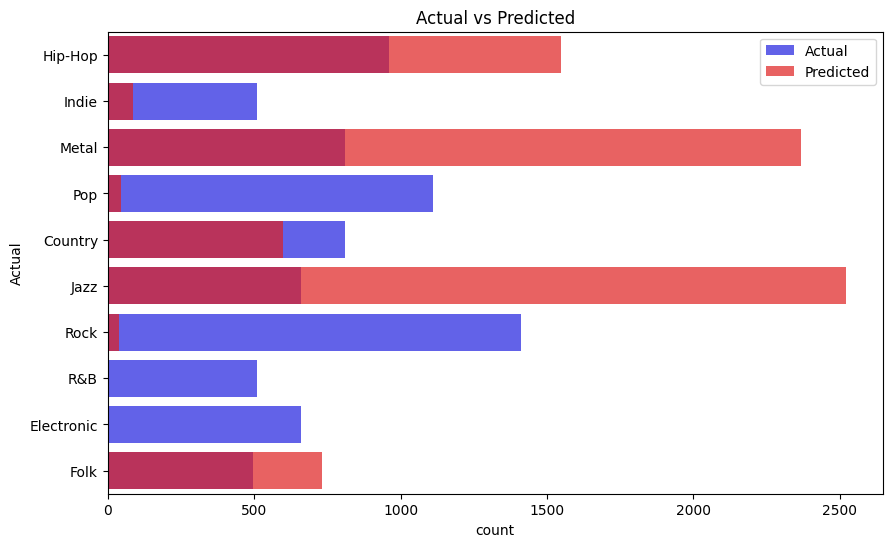

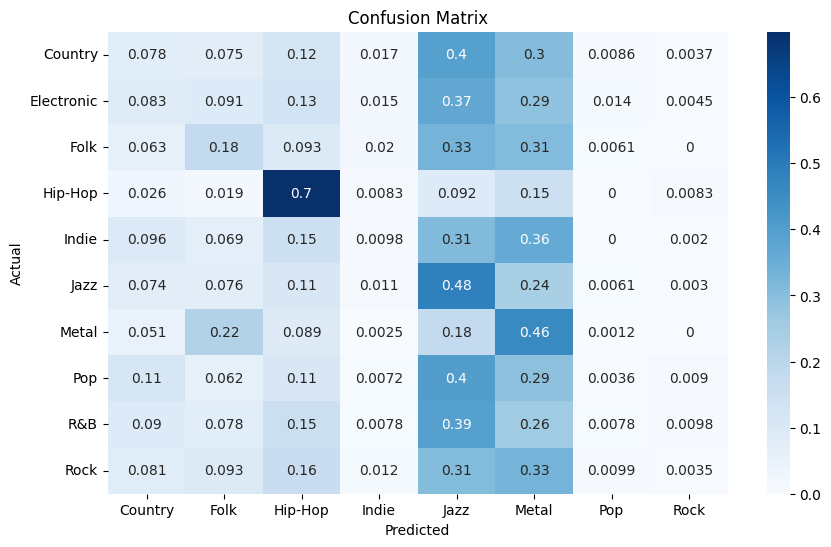

In [68]:
# evaluate the model
evaluate_model_word2vec(combined_rnn_model_word2vec, X_test_lyrics_word2vec, X_test_artist_word2vec, y_test_word2vec, le_word2vec)

# save the model
combined_rnn_model_word2vec.save('models/combined_rnn_model_word2vec.keras')

#### Single LSTM Layer Word2Vec Training and Evaluation, Lyrics & Artist

In [ ]:
# Create and evaluate combined LSTM model
combined_lstm_single_layer_model_word2vec = create_single_lstm_model(
    input_dim=vocab_size_lyrics_word2vec, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=EMBEDDING_DIM,  # Since we are using Word2Vec embeddings for lyrics
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER,
    max_length_artist=EMBEDDING_DIM,
    artist_vocab_size=vocab_size_artist_word2vec
)

combined_lstm_single_layer_model_word2vec.summary()

# train the model
combined_lstm_single_layer_model_word2vec.fit(
    [X_train_lyrics_word2vec, X_train_artist_word2vec], 
    y_train_word2vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    callbacks=[callbacks]
)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Lyrics_Input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Artist_Input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, 100, 100)  │  8,259,100 │ Lyrics_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, 100, 100)  │    550,800 │ Artist_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 64)        │     42,240 │ embedding_16[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 64)        │     42,240 │ embedding_17[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 64)        │          0 │ lstm_14[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 100)       │      6,500 │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 164)       │          0 │ dropout_26[0][0], │
│ (Concatenate)       │                   │            │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │     10,560 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 64)        │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 10)        │        650 │ dropout_27[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,912,090 (34.00 MB)

 Trainable params: 8,912,090 (34.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.1320 - loss: 2.1643 - val_accuracy: 0.0000e+00 - val_loss: 5.6022 - learning_rate: 0.0010
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.2033 - loss: 2.0316 - val_accuracy: 0.0000e+00 - val_loss: 7.3676 - learning_rate: 0.0010
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - accuracy: 0.2175 - loss: 1.9849 - val_accuracy: 0.0000e+00 - val_loss: 6.8433 - learning_rate: 0.0010


##### Results

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1916 - loss: 3.8224
Test Accuracy: 0.192
Test Loss: 3.856
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

     Country       0.11      0.08      0.09       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.12      0.18      0.14       495
     Hip-Hop       0.43      0.70      0.53       960
       Indie       0.06      0.01      0.02       510
        Jazz       0.13      0.48      0.20       660
       Metal       0.16      0.46      0.23       810
         Pop       0.09      0.00      0.01      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.14      0.00      0.01      1410

    accuracy                           0.19      7935
   macro avg       0.12      0.19      0.12      7935
weighted avg       0.14      0.19      0.13      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

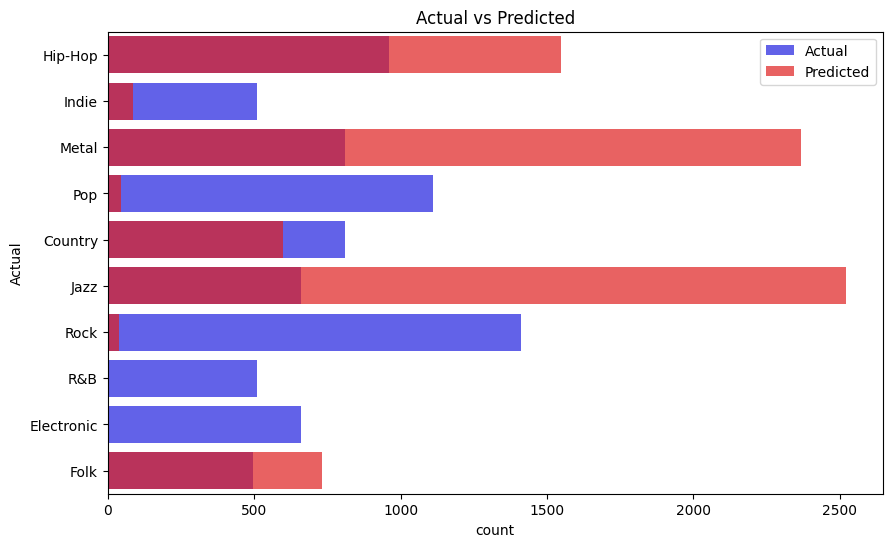

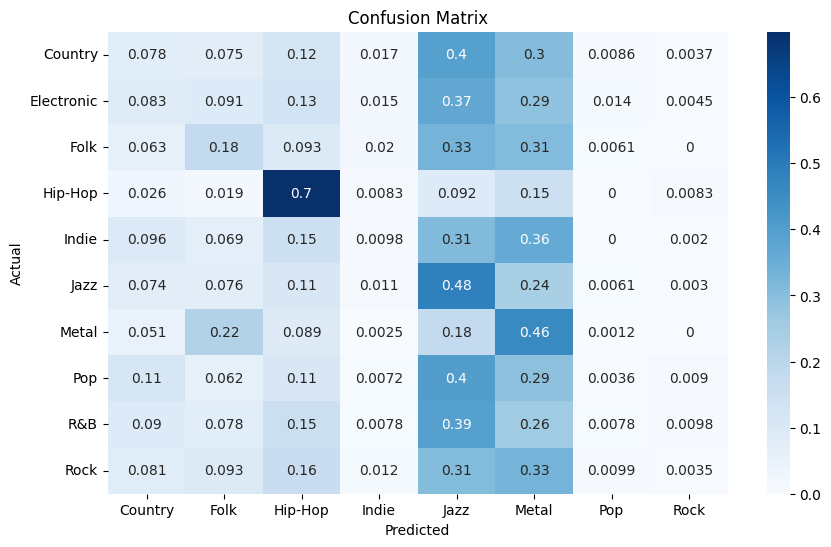

In [70]:
# evaluate the model
evaluate_model_word2vec(combined_rnn_model_word2vec, X_test_lyrics_word2vec, X_test_artist_word2vec, y_test_word2vec, le_word2vec)

# save the model
combined_lstm_single_layer_model_word2vec.save('models/combined_lstm_single_layer_model_word2vec.keras')

#### Multi LSTM Layer Word2Vec Training and Evaluation, Lyrics & Artist

In [71]:
# Create and evaluate combined multi-layer LSTM model
combined_multi_layer_lstm_model_word2vec = create_multi_lstm_model(
    input_dim=vocab_size_lyrics_word2vec, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=EMBEDDING_DIM,  # Since we are using Word2Vec embeddings for lyrics
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER,
    max_length_artist=EMBEDDING_DIM,
    artist_vocab_size=vocab_size_artist_word2vec
)

# train the model
combined_multi_layer_lstm_model_word2vec.fit(
    [X_train_lyrics_word2vec, X_train_artist_word2vec], 
    y_train_word2vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    callbacks=[]
)

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.1287 - loss: 2.1614 - val_accuracy: 0.0000e+00 - val_loss: 5.4724
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.1850 - loss: 2.0503 - val_accuracy: 0.0000e+00 - val_loss: 7.6749
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.2224 - loss: 1.9897 - val_accuracy: 0.0000e+00 - val_loss: 7.3896
Epoch 4/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.2301 - loss: 1.9675 - val_accuracy: 0.0000e+00 - val_loss: 9.3087
Epoch 5/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.2356 - loss: 1.9539 - val_accuracy: 0.0000e+00 - val_loss: 8.8018


##### Results

248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2202 - loss: 2.9197
Test Accuracy: 0.222
Test Loss: 2.933
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
              precision    recall  f1-score   support

     Country       0.12      0.24      0.16       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.12      0.23      0.16       495
     Hip-Hop       0.41      0.73      0.52       960
       Indie       0.14      0.00      0.01       510
        Jazz       0.13      0.31      0.18       660
       Metal       0.27      0.45      0.34       810
         Pop       0.17      0.04      0.06      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.27      0.09      0.14      1410

    accuracy                           0.22      7935
   macro avg       0.16      0.21      0.16      7935
weighted avg       0.19      0.22      0.17      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

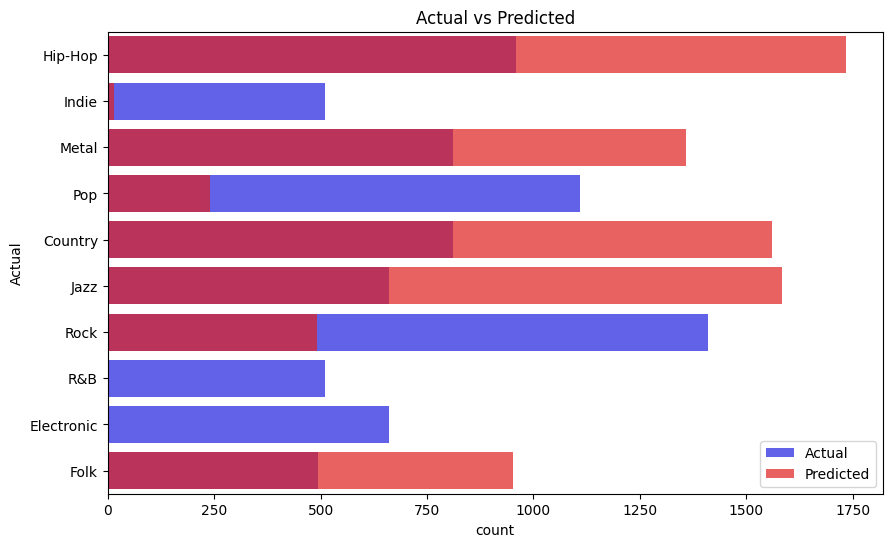

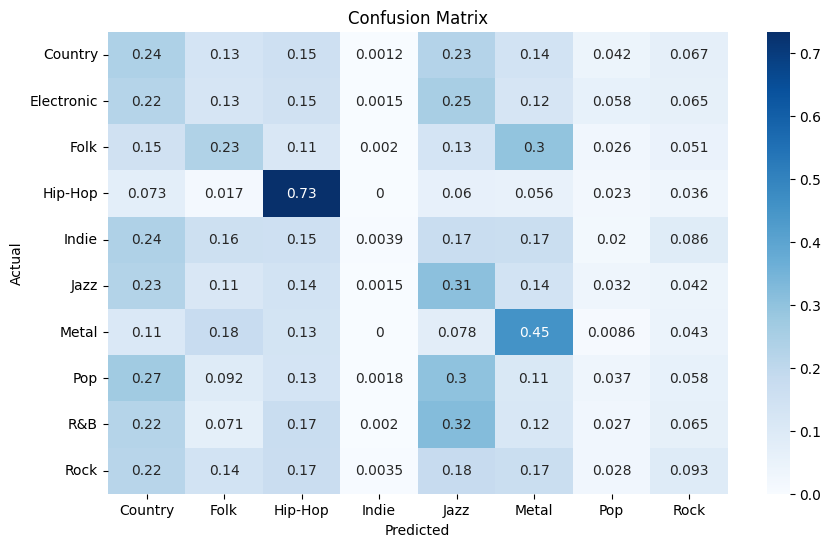

In [72]:
# evaluate the model
evaluate_model_word2vec(combined_multi_layer_lstm_model_word2vec, X_test_lyrics_word2vec, X_test_artist_word2vec, y_test_word2vec, le_word2vec)

# save the model
combined_multi_layer_lstm_model_word2vec.save('models/combined_multi_layer_lstm_model_word2vec.keras')

#### CNN Word2Vec Training and Evaluation, Lyrics & Artist

In [73]:
# Create and evaluate combined CNN model
combined_cnn_model_word2vec = create_cnn_model(
    input_dim=vocab_size_lyrics_word2vec, 
    embedding_dim=EMBEDDING_DIM, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=EMBEDDING_DIM,  # Since we are using Word2Vec embeddings for lyrics
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER,
    max_length_artist=EMBEDDING_DIM,
    artist_vocab_size=vocab_size_artist_word2vec
)

# train the model
combined_cnn_model_word2vec.fit(
    [X_train_lyrics_word2vec, X_train_artist_word2vec], 
    y_train_word2vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    callbacks=[]
)

Artist information included
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.1402 - loss: 2.1761 - val_accuracy: 0.0000e+00 - val_loss: 5.0697
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1904 - loss: 2.0348 - val_accuracy: 0.0000e+00 - val_loss: 6.2737
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.2116 - loss: 1.9941 - val_accuracy: 0.0000e+00 - val_loss: 6.6790
Epoch 4/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.2167 - loss: 1.9763 - val_accuracy: 0.0000e+00 - val_loss: 8.1475
Epoch 5/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.2400 - loss: 1.9414 - val_accuracy: 0.0000e+00 - val_loss: 8.1129


##### Results

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2157 - loss: 2.7930
Test Accuracy: 0.210
Test Loss: 2.821
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

     Country       0.14      0.46      0.22       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.00      0.00      0.00       495
     Hip-Hop       0.28      0.86      0.42       960
       Indie       0.06      0.00      0.01       510
        Jazz       0.12      0.10      0.11       660
       Metal       0.22      0.47      0.30       810
         Pop       0.31      0.01      0.02      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.00      0.00      0.00      1410

    accuracy                           0.21      7935
   macro avg       0.11      0.19      0.11      7935
weighted avg       0.13      0.21      0.12      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

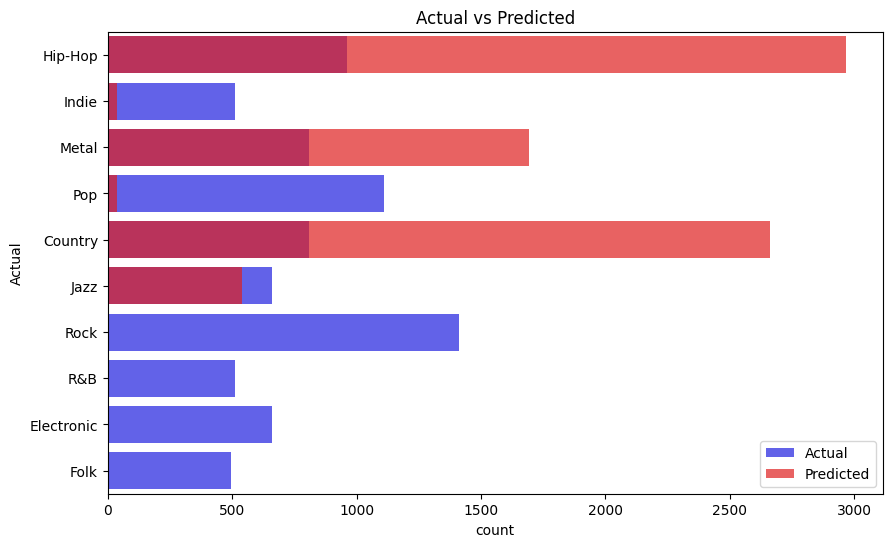

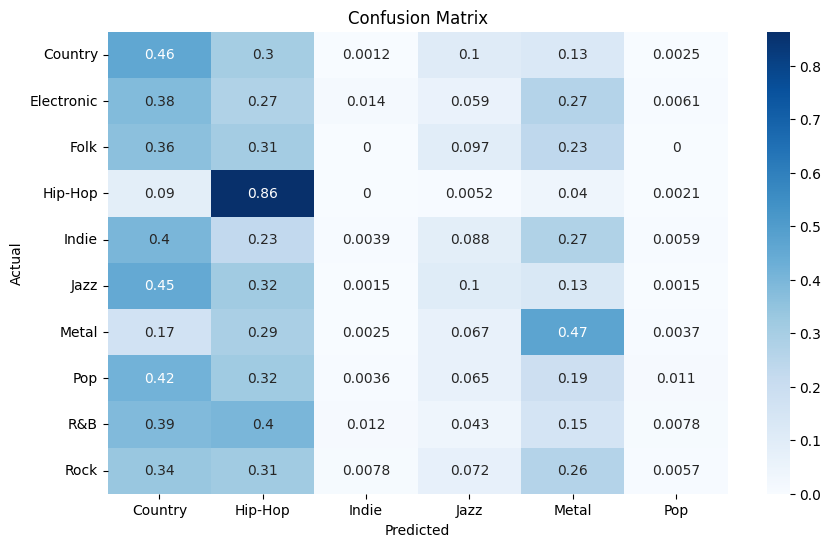

In [ ]:
# evaluate the model
evaluate_model_word2vec(combined_cnn_model_word2vec, X_test_lyrics_word2vec, X_test_artist_word2vec, y_test_word2vec, le_word2vec)

# save the model
combined_cnn_model_word2vec.save('models/combined_multi_layer_lstm_model_word2vec.keras')



### Hyperparameter Tuning for Word2Vec

#### RNN Hyperparameter Tuning

In [80]:
# Tune RNN hyperparameters
tuned_rnn_results_df_word2vec = tune_hyperparameters([
    X_train_lyrics_word2vec, 
    X_train_artist_word2vec], 
    y_train_word2vec, 
    [X_test_lyrics_word2vec, X_test_artist_word2vec], 
    y_test_word2vec,
    cnn_param_grid,
    vocab_size_lyrics=vocab_size_lyrics_word2vec, 
    max_length_lyrics=EMBEDDING_DIM,  # Since we are using Word2Vec embeddings for lyrics
    optimizer=OPTIMIZER,
    max_length_artist=EMBEDDING_DIM,
    vocab_size_artist=vocab_size_artist_word2vec)

# best rnn model
best_rnn_model_word2vec = tuned_rnn_results_df_word2vec['trained_model'].values[0]

Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'CNN', 'optimizer': <keras.src.optimizers.adam.Adam object at 0x3c3da4530>}
Artist information included
Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.1681 - loss: 2.0870 - val_accuracy: 0.0000e+00 - val_loss: 8.1280 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.2433 - loss: 1.9244 - val_accuracy: 0.0000e+00 - val_loss: 9.7518 - learning_rate: 0.0010
Epoch 3/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.2601 - loss: 1.8968 - val_accuracy: 0.0000e+00 - val_loss: 10.0127 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2101 - loss: 2.8410
Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'CNN', 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x404991130>}
Artist information included
Epoch 1/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.1258 - loss: 2.2962 - val_accuracy: 0.0000e+00 - val_loss: 2.4471 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accurac

##### Results

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2449 - loss: 2.5545
Test Accuracy: 0.236
Test Loss: 2.569
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

     Country       0.19      0.14      0.16       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.07      0.00      0.00       495
     Hip-Hop       0.30      0.82      0.44       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.13      0.28      0.18       660
       Metal       0.25      0.52      0.33       810
         Pop       0.23      0.21      0.22      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.23      0.09      0.13      1410

    accuracy                           0.24      7935
   macro avg       0.14      0.21      0.15      7935
weighted avg       0.17      0.24      0.17      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

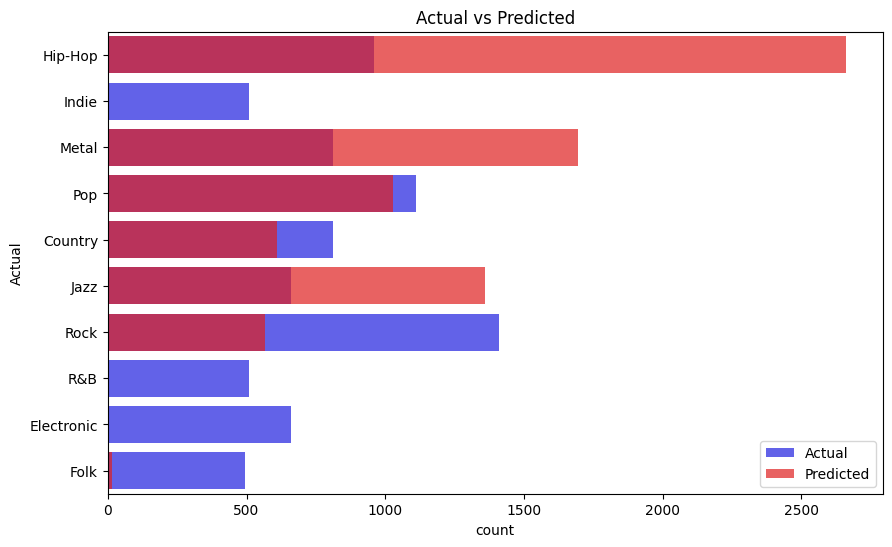

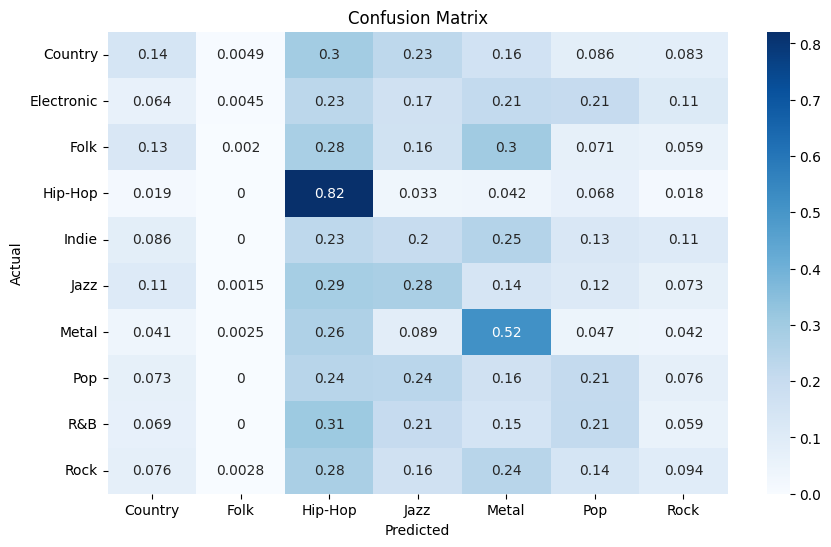

In [ ]:
# save the best rnn model
best_rnn_model_word2vec.save('models/best_rnn_model_word2vec.keras')

# save the tuned_results_df
tuned_rnn_results_df_word2vec.to_csv('results/tuned_rnn_results_df_word2vec.csv', index=False)

# evaluate the best rnn model
evaluate_model_word2vec(best_rnn_model_word2vec, X_test_lyrics_word2vec, X_test_artist_word2vec, y_test_word2vec, le_word2vec)

#### LSTM Hyperparameter Tuning

In [82]:
# tune the single layer lstm model
tuned_single_layer_lstm_results_df_word2vec = tune_hyperparameters([
    X_train_lyrics_word2vec, 
    X_train_artist_word2vec], 
    y_train_word2vec, 
    [X_test_lyrics_word2vec, X_test_artist_word2vec], 
    y_test_word2vec,
    lstm_single_param_grid,
    vocab_size_lyrics=vocab_size_lyrics_word2vec, 
    max_length_lyrics=EMBEDDING_DIM,  # Since we are using Word2Vec embeddings for lyrics
    optimizer=OPTIMIZER,
    max_length_artist=EMBEDDING_DIM,
    vocab_size_artist=vocab_size_artist_word2vec)

# best lstm model
best_single_lstm_model_word2vec = tuned_single_layer_lstm_results_df_word2vec['trained_model'].values[0]


Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'LSTM_SINGLE', 'optimizer': <keras.src.optimizers.adam.Adam object at 0x3c3da4530>}
Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.1428 - loss: 2.0960 - val_accuracy: 0.0000e+00 - val_loss: 7.3882 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.2382 - loss: 1.9469 - val_accuracy: 0.0000e+00 - val_loss: 7.9379 - learning_rate: 0.0010
Epoch 3/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - accuracy: 0.2557 - loss: 1.9212 - val_accuracy: 0.0000e+00 - val_loss: 8.9198 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2127 - loss: 2.7231
Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'LSTM_SINGLE', 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x404991130>}
Epoch 1/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.0781 - loss: 2.2970 - val_accuracy: 0.0000e+00 - val_loss: 2.3976 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.1272 - loss: 

##### Results

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2136 - loss: 2.6921
Test Accuracy: 0.212
Test Loss: 2.710
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
              precision    recall  f1-score   support

     Country       0.15      0.01      0.02       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.00      0.00      0.00       495
     Hip-Hop       0.38      0.71      0.49       960
       Indie       0.07      0.00      0.00       510
        Jazz       0.14      0.18      0.16       660
       Metal       0.16      0.82      0.27       810
         Pop       0.20      0.20      0.20      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.00      0.00      0.00      1410

    accuracy                           0.21      7935
   macro avg       0.11      0.19      0.11      7935
weighted avg       0.12      0.21      0.13      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

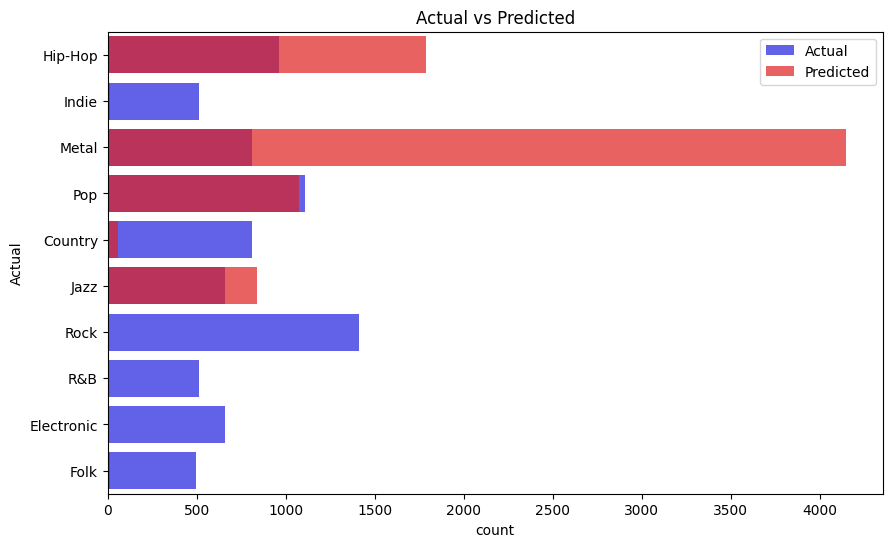

In [ ]:
# save the best lstm model
best_single_lstm_model_word2vec.save('models/best_single_lstm_model_word2vec.keras')

# save the tuned results
tuned_single_layer_lstm_results_df_word2vec.to_csv('results/tuned_single_layer_lstm_results_df_word2vec.csv', index=False)

# evaluate the best lstm model
evaluate_model_word2vec(best_single_lstm_model_word2vec, X_test_lyrics_word2vec, X_test_artist_word2vec, y_test_word2vec, le_word2vec)

#### Multi LSTM Hyperparameter Tuning

In [84]:
# tune the multi layer lstm model
tuned_multi_layer_lstm_results_df_word2vec = tune_hyperparameters([
    X_train_lyrics_word2vec, 
    X_train_artist_word2vec], 
    y_train_word2vec, 
    [X_test_lyrics_word2vec, X_test_artist_word2vec], 
    y_test_word2vec,
    lstm_multi_param_grid,
    vocab_size_lyrics=vocab_size_lyrics_word2vec, 
    max_length_lyrics=EMBEDDING_DIM,  # Since we are using Word2Vec embeddings for lyrics
    optimizer=OPTIMIZER,
    max_length_artist=EMBEDDING_DIM,
    vocab_size_artist=vocab_size_artist_word2vec)

# best lstm model
best_multi_lstm_model_word2vec = tuned_multi_layer_lstm_results_df_word2vec['trained_model'].values[0]

Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'LSTM_MULTI', 'optimizer': <keras.src.optimizers.adam.Adam object at 0x3c3da4530>}
Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.1362 - loss: 2.1205 - val_accuracy: 0.0000e+00 - val_loss: 6.7088 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.2088 - loss: 2.0126 - val_accuracy: 0.0000e+00 - val_loss: 8.3365 - learning_rate: 0.0010
Epoch 3/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.2359 - loss: 1.9501 - val_accuracy: 0.0000e+00 - val_loss: 9.1410 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1443 - loss: 2.7112
Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'LSTM_MULTI', 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x404991130>}
Epoch 1/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 33s 68ms/step - accuracy: 0.1270 - loss: 2.2898 - val_accuracy: 0.0000e+00 - val_loss: 2.4657 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.1241 - loss: 

##### Results

248/248 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.2131 - loss: 2.6568
Test Accuracy: 0.211
Test Loss: 2.674
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step
              precision    recall  f1-score   support

     Country       0.12      0.43      0.18       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.14      0.20      0.16       495
     Hip-Hop       0.34      0.77      0.47       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.15      0.17      0.16       660
       Metal       0.29      0.44      0.35       810
         Pop       0.16      0.01      0.02      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.17      0.00      0.01      1410

    accuracy                           0.21      7935
   macro avg       0.14      0.20      0.14      7935
weighted avg       0.16      0.21      0.14      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

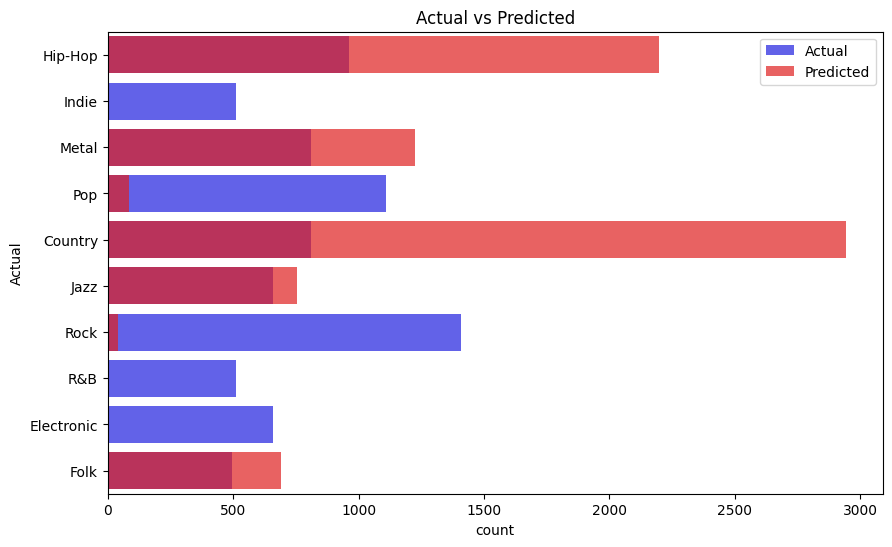

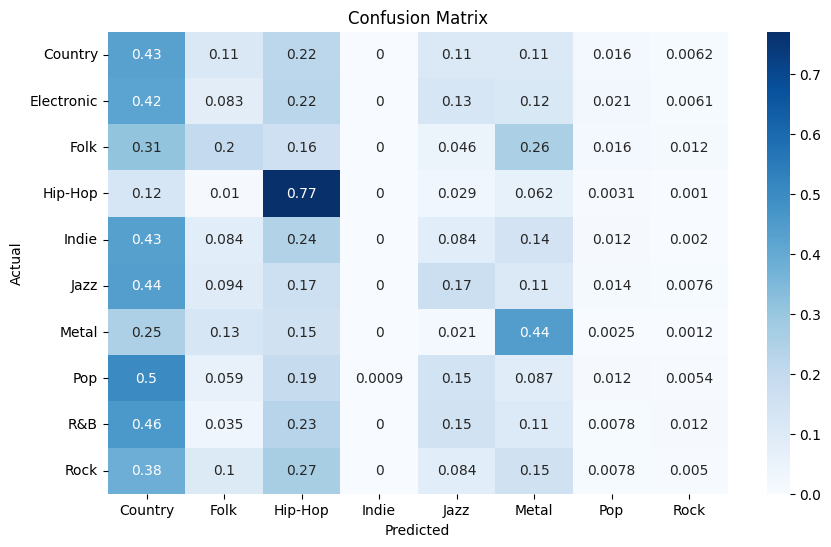

In [85]:
# save the best lstm model
best_multi_lstm_model_word2vec.save('models/best_multi_lstm_model_word2vec.keras')

# evaluate the best lstm model
evaluate_model_word2vec(best_multi_lstm_model_word2vec, X_test_lyrics_word2vec, X_test_artist_word2vec, y_test_word2vec, le_word2vec)

#### CNN Hyperparameter Tuning

In [87]:
# tune the cnn model
tuned_cnn_results_df_word2vec = tune_hyperparameters([
    X_train_lyrics_word2vec, 
    X_train_artist_word2vec], 
    y_train_word2vec, 
    [X_test_lyrics_word2vec, X_test_artist_word2vec], 
    y_test_word2vec,
    cnn_param_grid,
    vocab_size_lyrics=vocab_size_lyrics_word2vec, 
    max_length_lyrics=EMBEDDING_DIM,  # Since we are using Word2Vec embeddings for lyrics
    optimizer=OPTIMIZER,
    max_length_artist=EMBEDDING_DIM,
    vocab_size_artist=vocab_size_artist_word2vec)

# best cnn model
best_cnn_model_word2vec = tuned_cnn_results_df_word2vec['trained_model'].values[0]


Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'CNN', 'optimizer': <keras.src.optimizers.adam.Adam object at 0x3c3da4530>}
Artist information included
Epoch 1/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.1737 - loss: 2.0658 - val_accuracy: 0.0000e+00 - val_loss: 8.6399 - learning_rate: 0.0010
Epoch 2/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2484 - loss: 1.9209 - val_accuracy: 0.0000e+00 - val_loss: 10.4652 - learning_rate: 0.0010
Epoch 3/15
473/473 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2536 - loss: 1.8964 - val_accuracy: 0.0000e+00 - val_loss: 10.6517 - learning_rate: 0.0010
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2062 - loss: 2.9348
Training model with parameters: {'activation': 'relu', 'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.0, 'epochs': 15, 'model_type': 'CNN', 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x404

##### Results

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2368 - loss: 2.6441
Test Accuracy: 0.236
Test Loss: 2.658
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

     Country       0.19      0.28      0.22       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.11      0.13      0.12       495
     Hip-Hop       0.33      0.78      0.46       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.15      0.22      0.18       660
       Metal       0.26      0.42      0.32       810
         Pop       0.23      0.14      0.17      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.23      0.14      0.17      1410

    accuracy                           0.24      7935
   macro avg       0.15      0.21      0.16      7935
weighted avg       0.18      0.24      0.19      7935



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

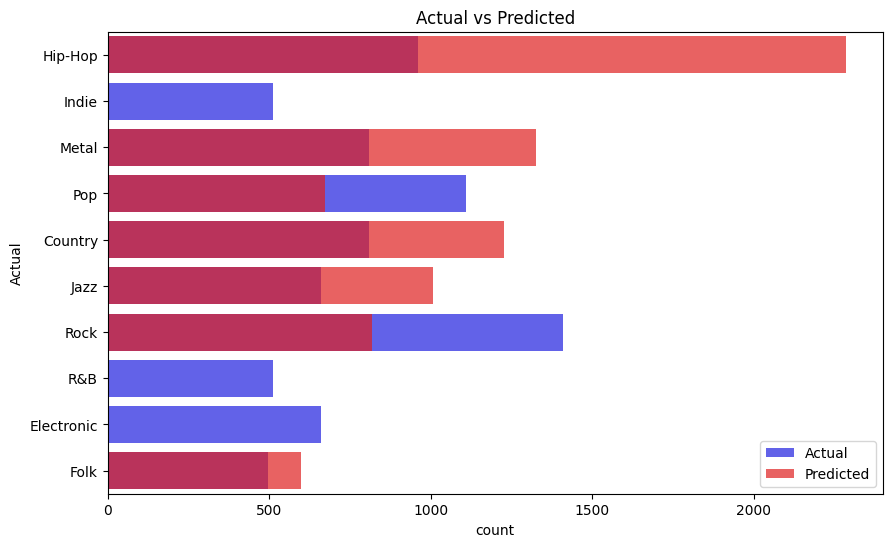

In [88]:
# save the best model
best_cnn_model_word2vec.save('models/best_cnn_model_word2vec.keras')

# evaluate the best model
evaluate_model_word2vec(best_cnn_model_word2vec, X_test_lyrics_word2vec, X_test_artist_word2vec, y_test_word2vec, le_word2vec)

### Exploration/Applying Learnings from the train and evaluation
Consistent poor results for electronic and R&B genres suggest further problems in the train data
downsampled data may not be representative of the entire dataset, the model may be overfitting to the downsampled data
Lyric length was not considered during the data preparation, this may have affected the model performance

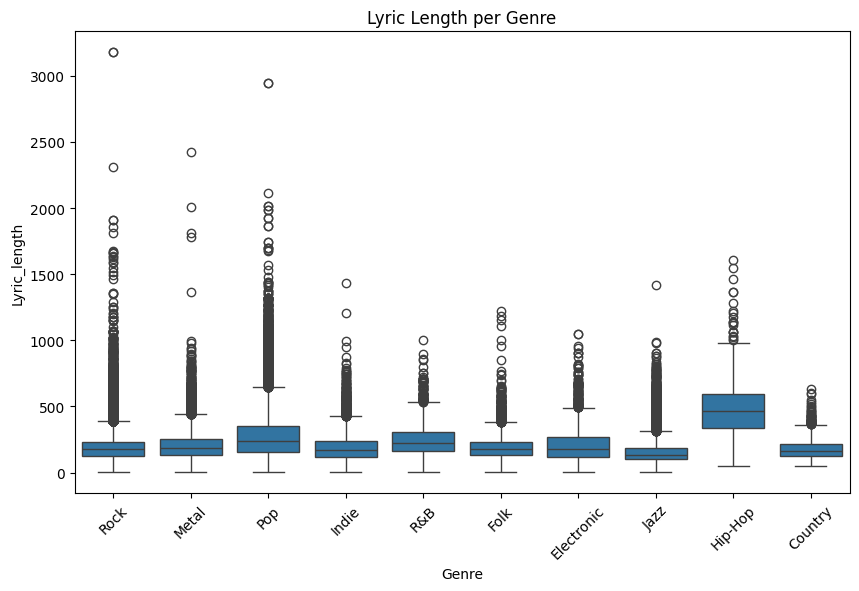

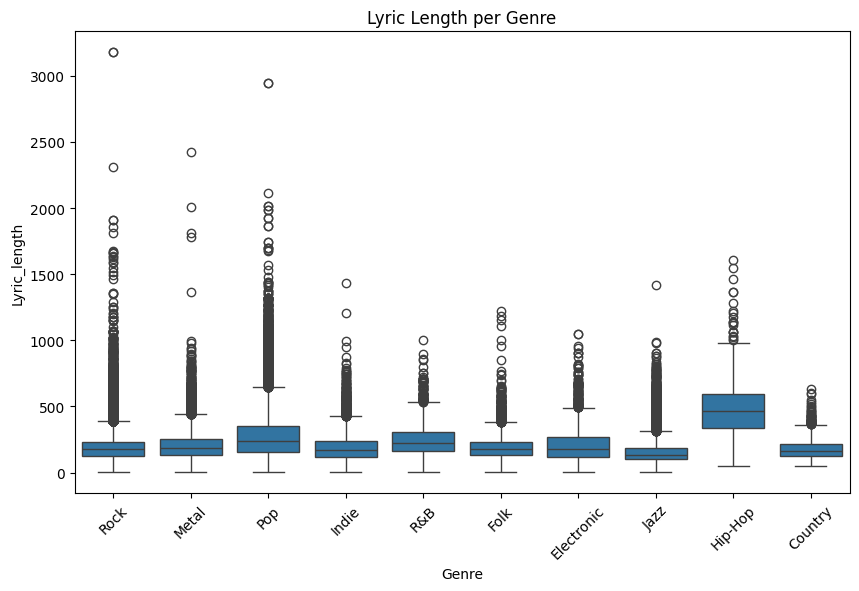

In [ ]:
# Analyze lyric length
train['Lyric_length'] = train['Lyrics'].apply(lambda x: len(str(x).split()))

# print the lyric length per genre
train.groupby('Genre')['Lyric_length'].mean()


# boxplot of the lyric length per genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Lyric_length', data=train)
plt.title('Lyric Length per Genre')
plt.xticks(rotation=45)
plt.show()

# Analyze lyric length
train_downsampled['Lyric_length'] = train_downsampled['Lyrics'].apply(lambda x: len(str(x).split()))

# print the lyric length per genre
train_downsampled.groupby('Genre')['Lyric_length'].mean()

# boxplot of the lyric length per genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Lyric_length', data=train)
plt.title('Lyric Length per Genre')
plt.xticks(rotation=45)
plt.show()

This line of code balances the training dataset by sampling 100 rows from each genre, with replacement if necessary. The groupby method groups the data by genre, the apply method applies the sampling function to each group, and the reset_index method resets the index of the resulting DataFrame. The resulting train_balanced DataFrame ensures that each genre is equally represented, which can improve the performance and fairness of machine learning models trained on this data.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Country'),
  Text(1, 0, 'Rock'),
  Text(2, 0, 'Pop'),
  Text(3, 0, 'Metal'),
  Text(4, 0, 'Jazz'),
  Text(5, 0, 'Hip-Hop'),
  Text(6, 0, 'Folk'),
  Text(7, 0, 'Indie'),
  Text(8, 0, 'R&B'),
  Text(9, 0, 'Electronic')])

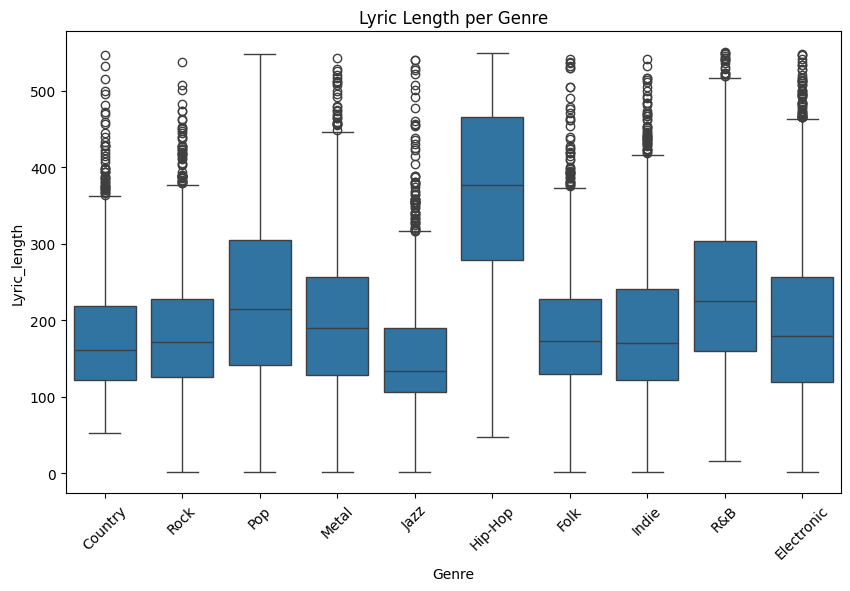

In [22]:
# remove outliers from the data based on the lyric length
# remove the top and bottom 5% of the data
train_balanced = train_downsampled[train_downsampled['Lyric_length'] > train_downsampled['Lyric_length'].quantile(0.05)]
train_balanced = train_downsampled[train_downsampled['Lyric_length'] < train_downsampled['Lyric_length'].quantile(0.95)]

# boxplot of the lyric length per genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Lyric_length', data=train_balanced)
plt.title('Lyric Length per Genre')
plt.xticks(rotation=45)



In [23]:
# remove any lyrics with less than 90 words
train_balanced = train_balanced[train_balanced['Lyric_length'] > 90]

# boxplot of the lyric length per genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Lyric_length', data=train_balanced)
plt.title('Lyric Length per Genre')
plt.xticks(rotation=45)
plt.show()


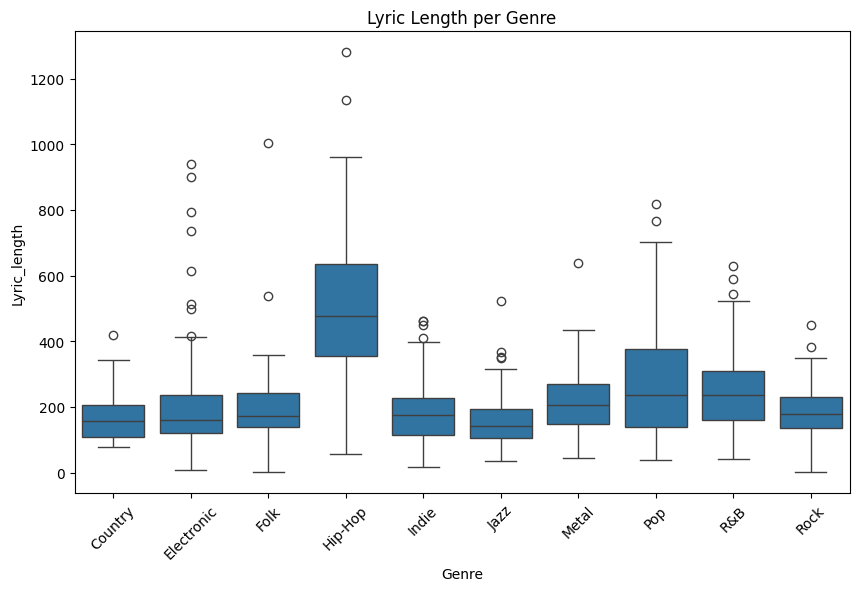

In [58]:
# balance the train dataset based on the lyric length
train_balanced = train_downsampled.groupby('Genre').apply(lambda x: x.sample(n=100, replace=True)).reset_index(drop=True)

# print the lyric length per genre
train_balanced.groupby('Genre')['Lyric_length'].mean()

# print(train.groupby('Genre')['Lyric_length'].mean())

# print(train.groupby('Genre')['Lyric_length'].max())

# print(train.groupby('Genre')['Lyric_length'].min())

# boxplot of the lyric length per genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Lyric_length', data=train_balanced)
plt.title('Lyric Length per Genre')
plt.xticks(rotation=45)
plt.show()

In [59]:
# further downsample the data
train_balanced = train_balanced.groupby('Genre').apply(lambda x: x.sample(n=100, replace=True)).reset_index(drop=True)

# print the lyric length per genre
train_balanced.groupby('Genre')['Lyric_length'].mean()

# print(train.groupby('Genre')['Lyric_length'].mean())

# print(train.groupby('Genre')['Lyric_length'].max())

# print(train.groupby('Genre')['Lyric_length'].min())

# boxplot of the lyric length per genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Lyric_length', data=train_balanced)
plt.title('Lyric Length per Genre')
plt.xticks(rotation=45)
plt.show()

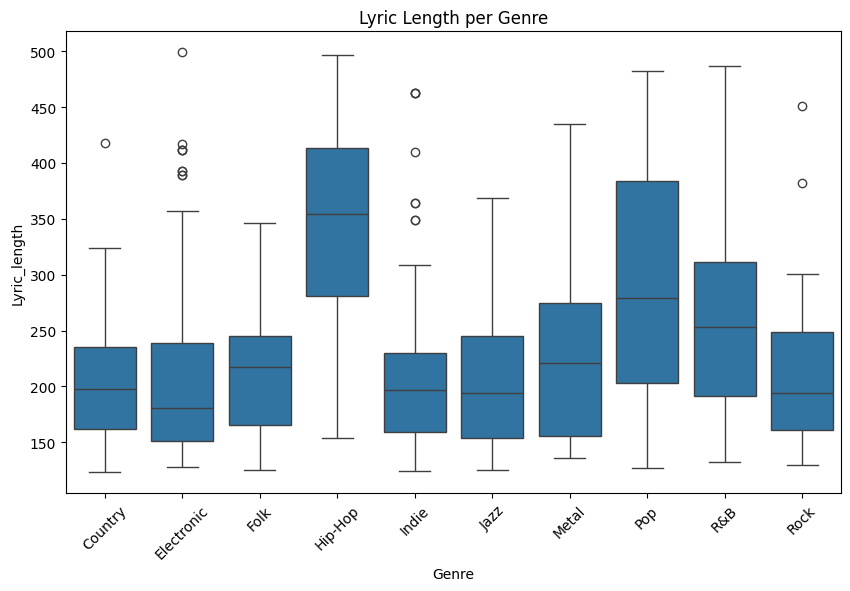

In [ ]:
# remove outliers
train_balanced = train_balanced[train_balanced['Lyric_length'] < 500]
train_balanced = train_balanced[train_balanced['Lyric_length'] > 120]

# print the lyric length per genre
train_balanced.groupby('Genre')['Lyric_length'].mean()

# boxplot of the lyric length per genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Lyric_length', data=train_balanced)
plt.title('Lyric Length per Genre')
plt.xticks(rotation=45)
plt.show()


In [62]:
# preare the balanced data
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced, vocab_size_lyrics_balanced, vocab_size_artist_balanced, max_length_lyrics_balanced, max_length_artist_balanced, le_balanced, lyrics_tokenizer_balanced, artist_tokenizer_balanced = prepare_data(
    train_balanced, test
)

# Separate lyrics and artist features
X_train_lyrics_balanced = X_train_balanced[:, :max_length_lyrics_balanced]
X_train_artist_balanced = X_train_balanced[:, max_length_lyrics_balanced:]
X_test_lyrics_balanced = X_test_balanced[:, :max_length_lyrics_balanced]
X_test_artist_balanced = X_test_balanced[:, max_length_lyrics_balanced:]

print("Shape of X_train_lyrics_balanced:", X_train_lyrics_balanced.shape)
print("Shape of X_train_artist_balanced:", X_train_artist_balanced.shape)

Shape of X_train_lyrics_balanced: (742, 499)
Shape of X_train_artist_balanced: (742, 5)


In [63]:
# create a CNN model for lyrics and artist with the balanced data
combined_cnn_lstm_model_balanced = create_cnn_lstm_model(
    input_dim=vocab_size_lyrics_balanced, 
    embedding_dim=100, 
    dense_units=UNITS, 
    dropout_rate=DROPOUT_RATE, 
    max_length=max_length_lyrics_balanced, 
    dense_activation=DENSE_ACTIVATION, 
    optimizer=OPTIMIZER,
    max_length_artist=max_length_artist_balanced,
    artist_vocab_size=vocab_size_artist_balanced
)

# train the model
combined_cnn_lstm_history = combined_cnn_lstm_model_balanced.fit(
    [X_train_lyrics_balanced, X_train_artist_balanced], 
    y_train_balanced, 
    batch_size=BATCH_SIZE, 
    epochs=20, 
    validation_split=VALIDATION_SPLIT, 
    callbacks=[]
)

Artist information included
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.1337 - loss: 2.2646 - val_accuracy: 0.0000e+00 - val_loss: 3.3741
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step - accuracy: 0.1759 - loss: 2.1708 - val_accuracy: 0.0000e+00 - val_loss: 3.0717
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 438ms/step - accuracy: 0.1530 - loss: 2.1650 - val_accuracy: 0.0000e+00 - val_loss: 3.5314
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - accuracy: 0.2060 - loss: 2.1065 - val_accuracy: 0.0000e+00 - val_loss: 3.6274
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.2917 - loss: 1.9454 - val_accuracy: 0.0000e+00 - val_loss: 3.9184
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 409ms/step - accuracy: 0.4201 - loss: 1.6789 - val_accuracy: 0.0000e+00 - val_loss: 4.5321
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 437ms/step - accuracy: 0.5341 - loss: 1.3221 - val_accuracy: 0.0000e+00 - val_loss: 5.5448
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 419ms/step - accuracy: 0.6265 - loss: 1.0768 

248/248 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.2593 - loss: 3.8088
Loss: 3.798313617706299
Accuracy: 0.2616257071495056
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step
0.2616257088846881


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

     Country       0.71      0.40      0.51       810
  Electronic       0.48      0.19      0.27       660
        Folk       0.12      0.11      0.12       495
     Hip-Hop       0.73      0.41      0.53       960
       Indie       0.23      0.10      0.14       510
        Jazz       0.14      0.71      0.23       660
       Metal       0.27      0.61      0.38       810
         Pop       0.14      0.10      0.12      1110
         R&B       0.84      0.10      0.18       510
        Rock       0.00      0.00      0.00      1410

    accuracy                           0.26      7935
   macro avg       0.37      0.27      0.25      7935
weighted avg       0.34      0.26      0.24      7935



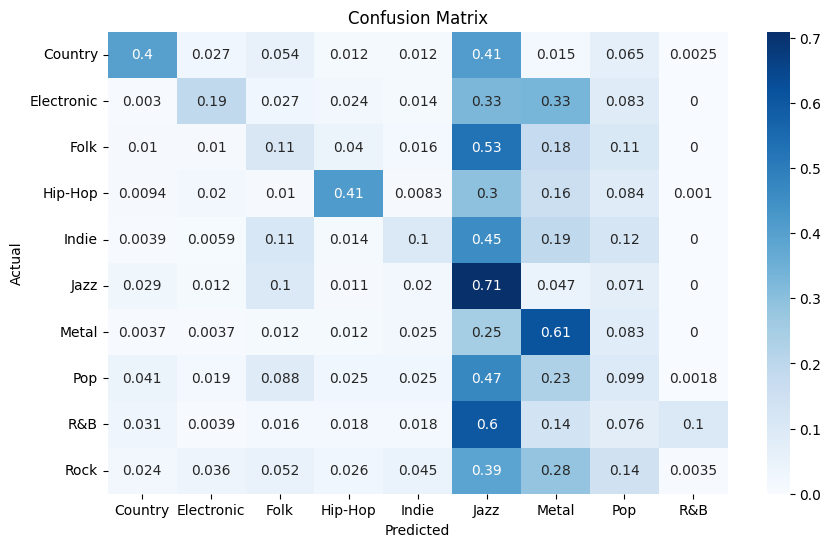

In [64]:
# evaluate the model
evaluate_model(combined_cnn_lstm_model_balanced, [X_test_lyrics_balanced, X_test_artist_balanced], y_test_balanced, le_balanced)

# save the model
combined_cnn_lstm_model_balanced.save('models/combined_cnn_lstm_model_balanced.keras')